# # Network_Threat_Analysis_System
# ## Comprehensive Feature Extraction and Machine Learning Framework
# 
# This notebook integrates three analysis approaches:
# 1. Statistical flow analysis
# 2. Semantic content analysis  
# 3. Visual pattern generation
#
# Output includes both human-readable reports and ML-ready datasets.


# ### Step 1: Environment Setup and Dependency Installation

# ### Step 1:  Setup and Imports


In [1]:
# Cell 1: Setup and Imports - Complete Environment Initialization
"""
PURPOSE: Initialize the complete analysis environment with all required libraries
This cell sets up the entire working environment for network packet analysis.

WHAT THIS CELL DOES:
1. Imports all necessary Python libraries for:
   - Network packet parsing (scapy, pyshark)
   - Data processing (pandas, numpy)
   - Machine learning (sklearn, xgboost, lightgbm)
   - Visualization (plotly, matplotlib, seaborn)
   - System monitoring (psutil for memory tracking)
   - File operations (parquet for efficient storage, no HDF5)
2. Configures display settings for better readability
3. Shows system information (total RAM, available memory)
4. Timestamps when analysis starts

WHY THESE LIBRARIES:
- scapy/pyshark: Parse PCAP files and extract packet information
- pandas/numpy: Handle large datasets efficiently with DataFrames
- sklearn: Provides ML algorithms and feature selection tools
- SGDClassifier: Enables incremental learning for large datasets
- xgboost/lightgbm: High-performance gradient boosting for classification
- plotly: Creates interactive visualizations
- psutil: Monitors memory usage to prevent crashes
- pyarrow: Enables Parquet storage without file locking issues on Windows

IMPORTANT CHANGES:
- Removed h5py/HDF5 (unreliable on Windows)
- Added pyarrow for Parquet support (better compression, no locking)
- Added lightgbm as alternative to xgboost
"""

import os
import gc
import warnings
import json
import pickle
import hashlib
import re
import psutil
import glob
import time
from datetime import datetime
from collections import defaultdict, Counter, deque
from typing import Dict, List, Tuple, Optional, Any, Generator
from dataclasses import dataclass, field

# Data processing libraries
import numpy as np
import pandas as pd
from scipy import stats

# Parquet support (replacing HDF5)
import pyarrow as pa
import pyarrow.parquet as pq

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier  # For incremental learning when data doesn't fit in memory
from sklearn.cluster import MiniBatchKMeans

# Gradient boosting libraries
import xgboost as xgb
import lightgbm as lgb  # Often faster than XGBoost on CPU

# Network analysis libraries
from scapy.all import *  # For packet parsing
import pyshark  # Alternative packet parser with better protocol support

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.subplots import make_subplots

# Jupyter notebook specific
from IPython.display import display, clear_output, HTML
from tqdm.notebook import tqdm  # Progress bars for loops

# Interactive widgets for configuration
import ipywidgets as widgets

# Parallel processing
from joblib import Parallel, delayed
import multiprocessing

# Global configuration
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output
pd.set_option('display.max_columns', 50)  # Show more columns in DataFrame display
pd.set_option('display.max_rows', 100)  # Show more rows in DataFrame display

# Display system information
print("="*70)
print("MEMORY-OPTIMIZED NETWORK ANALYSIS PIPELINE V2.0")
print("="*70)
print(f"System Memory: {psutil.virtual_memory().total / (1024**3):.1f} GB")
print(f"Available Memory: {psutil.virtual_memory().available / (1024**3):.1f} GB")
print(f"CPU Cores: {psutil.cpu_count()} ({multiprocessing.cpu_count()} usable)")
print(f"Storage Backend: Parquet (no file locking issues)")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)

MEMORY-OPTIMIZED NETWORK ANALYSIS PIPELINE V2.0
System Memory: 31.4 GB
Available Memory: 12.6 GB
CPU Cores: 12 (12 usable)
Storage Backend: Parquet (no file locking issues)
Analysis started at: 2025-08-31 04:34:20


# ### Step 1.5: Clear Temporary Files Before Analysis 

In [2]:
# Cell 1.5: Cleanup - Clear Temporary Files Before Analysis
"""
PURPOSE: Clean up temporary files from previous runs
This cell ensures a clean start by removing old temporary files that could
interfere with the current analysis.

WHAT THIS CELL DOES:
1. Checks for existing temporary directories
2. Removes old flow, semantic, combined, and labeled features
3. Clears any cached files from previous runs
4. Recreates clean directory structure
5. Optionally clears output directory

WHY THIS MATTERS:
- Prevents mixing data from different PCAP files
- Avoids file naming conflicts
- Ensures consistent results
- Frees up disk space
- Prevents loading old data accidentally

RUN THIS:
- Before starting a new analysis
- After a failed/interrupted run
- When switching between different PCAP files
"""

import os
import shutil
import psutil

def cleanup_temp_files(clear_output=False):
    """
    Remove temporary files from previous pipeline runs.
    
    Args:
        clear_output: If True, also clears the output directory (default: False)
    """
    print("="*60)
    print("CLEANING UP TEMPORARY FILES")
    print("="*60)
    
    # Check if Config is defined
    try:
        temp_dir = Config.TEMP_DIR
        output_dir = Config.OUTPUT_DIR
    except NameError:
        # Use default values if Config not yet defined
        temp_dir = './temp_processing'
        output_dir = './analysis_output'
        print("⚠ Config not defined, using default directories")
    
    # List of temporary directories to clean
    temp_dirs = [
        os.path.join(temp_dir, 'flow_features'),
        os.path.join(temp_dir, 'semantic_features'),
        os.path.join(temp_dir, 'combined_features'),
        os.path.join(temp_dir, 'labeled_features')
    ]
    
    # Clean each temporary directory
    for dir_path in temp_dirs:
        if os.path.exists(dir_path):
            try:
                # Count files before deletion
                file_count = sum(len(files) for _, _, files in os.walk(dir_path))
                size_mb = sum(os.path.getsize(os.path.join(dirpath, filename))
                             for dirpath, _, filenames in os.walk(dir_path)
                             for filename in filenames) / (1024*1024)
                
                # Remove directory
                shutil.rmtree(dir_path)
                print(f"✓ Removed: {os.path.basename(dir_path)}")
                print(f"  Deleted {file_count} files ({size_mb:.1f} MB)")
            except Exception as e:
                print(f"✗ Failed to remove {dir_path}: {e}")
    
    # Clean root temp directory if empty or recreate it
    if os.path.exists(temp_dir):
        try:
            # Check if temp directory has any other files
            remaining_files = os.listdir(temp_dir)
            if not remaining_files:
                shutil.rmtree(temp_dir)
                print(f"✓ Removed empty temp directory")
        except Exception as e:
            print(f"⚠ Could not clean temp directory: {e}")
    
    # Recreate clean directory structure
    os.makedirs(temp_dir, exist_ok=True)
    for dir_name in ['flow_features', 'semantic_features', 'combined_features', 'labeled_features']:
        os.makedirs(os.path.join(temp_dir, dir_name), exist_ok=True)
    print("✓ Created clean directory structure")
    
    # Optionally clear output directory
    if clear_output and os.path.exists(output_dir):
        try:
            # Ask for confirmation
            response = input(f"\n⚠ Clear output directory '{output_dir}'? (y/n): ")
            if response.lower() == 'y':
                shutil.rmtree(output_dir)
                os.makedirs(output_dir, exist_ok=True)
                print(f"✓ Cleared output directory")
            else:
                print("✓ Output directory preserved")
        except Exception as e:
            print(f"✗ Failed to clear output directory: {e}")
    
    # Report disk space
    disk = psutil.disk_usage('/')
    print(f"\nDisk space available: {disk.free / (1024**3):.1f} GB ({100-disk.percent:.1f}% free)")
    
    print("\n✓ Cleanup complete - ready for new analysis")
    print("="*60)

def check_temp_files():
    """
    Check what temporary files currently exist without deleting them.
    """
    print("="*60)
    print("CHECKING TEMPORARY FILES")
    print("="*60)
    
    # Check if Config is defined
    try:
        temp_dir = Config.TEMP_DIR
    except NameError:
        temp_dir = './temp_processing'
        print("⚠ Config not defined, checking default directory")
    
    if not os.path.exists(temp_dir):
        print("No temporary directory found - clean start")
        return
    
    # Check each subdirectory
    total_files = 0
    total_size = 0
    
    for root, dirs, files in os.walk(temp_dir):
        if files:
            dir_size = sum(os.path.getsize(os.path.join(root, f)) for f in files)
            total_files += len(files)
            total_size += dir_size
            
            rel_path = os.path.relpath(root, temp_dir)
            print(f"\n{rel_path}:")
            print(f"  Files: {len(files)}")
            print(f"  Size: {dir_size / (1024*1024):.1f} MB")
            
            # Show sample files
            sample_files = files[:3]
            for f in sample_files:
                print(f"    - {f}")
            if len(files) > 3:
                print(f"    ... and {len(files)-3} more files")
    
    if total_files > 0:
        print(f"\nTotal: {total_files} files, {total_size / (1024*1024):.1f} MB")
        print("\n⚠ Temporary files exist from previous run")
        print("  Run cleanup_temp_files() to remove them")
    else:
        print("\n✓ No temporary files found - clean start")
    
    print("="*60)

# Create interactive cleanup interface
from IPython.display import display
import ipywidgets as widgets

def create_cleanup_ui():
    """
    Create an interactive cleanup interface with buttons.
    """
    display(HTML("<h3>Cleanup Manager</h3>"))
    
    # Output area for messages
    output = widgets.Output()
    
    # Check button
    check_btn = widgets.Button(
        description='Check Temp Files',
        button_style='info',
        tooltip='Check what temporary files exist',
        icon='search'
    )
    
    # Clean temp button
    clean_temp_btn = widgets.Button(
        description='Clean Temp Files',
        button_style='warning',
        tooltip='Remove temporary processing files',
        icon='trash'
    )
    
    # Clean all button
    clean_all_btn = widgets.Button(
        description='Clean Everything',
        button_style='danger',
        tooltip='Remove all temporary and output files',
        icon='exclamation-triangle'
    )
    
    def on_check(b):
        with output:
            clear_output()
            check_temp_files()
    
    def on_clean_temp(b):
        with output:
            clear_output()
            cleanup_temp_files(clear_output=False)
    
    def on_clean_all(b):
        with output:
            clear_output()
            cleanup_temp_files(clear_output=True)
    
    check_btn.on_click(on_check)
    clean_temp_btn.on_click(on_clean_temp)
    clean_all_btn.on_click(on_clean_all)
    
    # Layout
    button_box = widgets.HBox([check_btn, clean_temp_btn, clean_all_btn])
    
    display(widgets.VBox([
        widgets.HTML("<p>Manage temporary files from previous runs:</p>"),
        button_box,
        output
    ]))

# Display the cleanup UI
create_cleanup_ui()

print("\n" + "="*60)
print("QUICK COMMANDS:")
print("="*60)
print("# Check what files exist:")
print("check_temp_files()")
print("")
print("# Clean only temp files (recommended before each run):")
print("cleanup_temp_files()")
print("")
print("# Clean everything including output:")
print("cleanup_temp_files(clear_output=True)")
print("="*60)


QUICK COMMANDS:
# Check what files exist:
check_temp_files()

# Clean only temp files (recommended before each run):
cleanup_temp_files()

# Clean everything including output:
cleanup_temp_files(clear_output=True)


# ### Step 2: Configuration Interface

In [ ]:
# Cell 2: Configuration Class - Interactive Settings & Memory Management with Multi-PCAP Support
"""
PURPOSE: Central configuration hub for all analysis parameters with multi-day CICIDS support
This cell creates an interactive configuration interface using Jupyter widgets.

WHAT THIS CELL DOES:
1. Defines all configurable parameters for the analysis pipeline
2. Creates an interactive UI with sliders, text boxes, and checkboxes
3. Automatically determines optimal processing strategy based on file size
4. Validates user inputs and checks system resources
5. Sets up directory structure for outputs and temporary files
6. ENHANCED: Supports multiple PCAP files for balanced training data

KEY FUNCTIONALITY:
- Multi-PCAP Management: Handles multiple PCAP files for balanced attack representation
- Memory Management: Sets limits on RAM usage and flow storage
- Processing Strategy: Chooses between disk-based or memory-based processing
- ML Configuration: Selects which models to train and sampling strategy
- Feature Settings: Determines number of features and data types to use

CONFIGURATION CATEGORIES:
1. Input/Output: Multiple PCAP files, label files, output directory
2. Memory Settings: MAX_MEMORY_GB, MAX_FLOWS_IN_MEMORY, batch sizes
3. Processing: Chunk sizes, flow timeouts, packet limits
4. Analysis Modes: Flow analysis, semantic analysis, NLP depth
5. ML Settings: Model selection, train/test split, sampling
6. Storage: Parquet format usage, compression, temporary file cleanup

IMPORTANT CHANGES:
- Support for multiple PCAP files for balanced training
- Enhanced Random Forest configuration
- Better evaluation metrics beyond accuracy
- Improved class balancing options

The class uses class methods (@classmethod) so configuration is global
and accessible throughout the entire pipeline.
"""

class Config:
    # ============= FILE PATHS (ENHANCED FOR MULTI-PCAP) =============
    PCAP_FILES = []  # List of PCAP files for multi-day training
    PCAP_FILE = ''  # Primary PCAP file (backward compatibility)
    LABEL_FILE = ''  # Single label file path (will be set if multiple CSVs combined)
    LABEL_FILES = []  # List of CICIDS2017 CSV label files
    OUTPUT_DIR = './analysis_output'  # Where to save results
    
    # ============= MEMORY OPTIMIZATION (Optimized for 32GB System) =============
    MAX_MEMORY_GB = 8.0  # Maximum RAM to use (25% of 32GB, prevents system freeze)
    MAX_FLOWS_IN_MEMORY = 100000  # Flows kept in RAM before disk flush (increased for 32GB)
    MAX_PACKETS_PER_FLOW = 1000  # Cap packets per flow to prevent memory bloat
    USE_DISK_CACHE = True  # Use Parquet disk storage for large files
    TEMP_DIR = './temp_processing'  # Temporary storage location
    
    # ============= PROCESSING PARAMETERS (Optimized for Ryzen 5) =============
    CHUNK_SIZE = 50000  # Packets processed at once (increased for better CPU utilization)
    BATCH_SIZE = 200000  # Flows per ML training batch (increased for 32GB RAM)
    MAX_PACKETS = 0  # Limit packets to process (0 = unlimited)
    FLOW_TIMEOUT = 120  # Seconds before flow considered complete
    N_JOBS = -1  # Number of parallel jobs (-1 = use all CPU cores)
    
    # ============= SAMPLING STRATEGY (ENHANCED FOR IMBALANCED DATA) =============
    USE_SAMPLING = True  # Sample data if too large for ML
    SAMPLE_SIZE = 1000000  # Maximum flows for ML training (increased for 32GB)
    STRATIFY_SAMPLE = True  # Maintain attack type distribution in sample
    USE_CLASS_BALANCING = True  # Apply class weights to handle imbalanced data
    
    # ============= ANALYSIS MODES =============
    ANALYSIS_MODE = 'combined'  # Options: 'flow', 'semantic', 'combined'
    DEEP_INSPECTION = True  # Enable NLP payload analysis (slower but better detection)
    USE_CICIDS_LABELS = False  # Whether to use CICIDS ground truth
    GENERATE_VISUALS = True  # Create visualization charts
    ML_EXPORT = True  # Export ML models and features
    SKIP_ML = False  # Skip ML training for pipeline testing
    
    # ============= FEATURE ENGINEERING =============
    TOP_FEATURES = 50  # Number of best features to select (increased for better accuracy)
    FEATURE_DTYPE = np.float32  # Data type (float32 saves memory vs float64)
    EXTRACT_CICIDS_FEATURES = True  # Extract CICIDS-specific features
    
    # ============= MACHINE LEARNING (ENHANCED WITH BALANCED MODELS) =============
    TEST_SIZE = 0.2  # Fraction of data for testing
    RANDOM_STATE = 42  # Random seed for reproducibility
    SELECTED_MODELS = ['random_forest']  # Single model selection
    USE_INCREMENTAL_LEARNING = True  # Train in batches for large datasets
    USE_STRATIFIED_SPLIT = True  # Maintain class distribution in train/test split
    
    # ============= EVALUATION METRICS (ENHANCED BEYOND ACCURACY) =============
    EVALUATION_METRICS = ['accuracy', 'f1_macro', 'f1_weighted', 'precision_macro', 'recall_macro', 'per_class']
    CALCULATE_PER_CLASS_METRICS = True  # Detailed per-attack-type performance
    MINIMUM_ATTACK_DETECTION_RATE = 0.7  # Minimum acceptable attack detection rate
    
    # ============= STORAGE SETTINGS (Using Parquet) =============
    STORAGE_FORMAT = 'parquet'  # Storage format (parquet recommended over hdf5)
    USE_PARQUET = True  # Use Parquet format for efficient disk storage
    COMPRESSION = 'snappy'  # Fast compression algorithm
    CLEANUP_TEMP = True  # Delete temporary files after completion
    
    @classmethod
    def check_memory_requirements(cls):
        """
        Analyzes PCAP file sizes and available RAM to determine processing strategy.
        Enhanced to handle multiple PCAP files.
        
        Returns:
            str: 'DISK_BASED' for large files, 'MEMORY_BASED' for small files
        """
        total_file_size_gb = 0
        valid_files = 0
        
        # Check all PCAP files
        pcap_files = cls.PCAP_FILES if cls.PCAP_FILES else [cls.PCAP_FILE] if cls.PCAP_FILE else []
        
        for pcap_file in pcap_files:
            if pcap_file and os.path.exists(pcap_file):
                file_size_gb = os.path.getsize(pcap_file) / (1024**3)
                total_file_size_gb += file_size_gb
                valid_files += 1
        
        if valid_files == 0:
            return False
            
        available_gb = psutil.virtual_memory().available / (1024**3)
        total_gb = psutil.virtual_memory().total / (1024**3)
        
        print("\n" + "="*60)
        print("MEMORY ASSESSMENT (MULTI-PCAP)")
        print("="*60)
        print(f"PCAP Files: {valid_files}")
        print(f"Total PCAP Size: {total_file_size_gb:.2f} GB")
        print(f"Average PCAP Size: {total_file_size_gb/valid_files:.2f} GB")
        print(f"Total RAM: {total_gb:.2f} GB")
        print(f"Available RAM: {available_gb:.2f} GB")
        print(f"Max Memory Setting: {cls.MAX_MEMORY_GB:.2f} GB")
        
        # Decision logic for processing strategy
        if total_file_size_gb > available_gb * 0.3:  # Total files > 30% of available RAM
            print("\nRECOMMENDATION: Large dataset detected")
            print("- Using disk-based processing with Parquet")
            print("- Enabling flow timeout mechanism")
            print("- Using incremental learning")
            print("- Processing files sequentially for memory efficiency")
            cls.USE_DISK_CACHE = True
            cls.USE_INCREMENTAL_LEARNING = True
            cls.USE_SAMPLING = True
            processing_strategy = "DISK_BASED"
        else:
            print("\nRECOMMENDATION: Files can fit in memory")
            print("- Using hybrid processing")
            processing_strategy = "MEMORY_BASED"
        
        # Time estimation (empirical: 1GB ≈ 2-4 minutes with optimizations)
        estimated_time = total_file_size_gb * (3 if cls.USE_DISK_CACHE else 2)
        print(f"\nEstimated Processing Time: {estimated_time:.0f} minutes")
        
        return processing_strategy
    
    @classmethod
    def setup_interactive_ui(cls):
        """
        Creates an interactive configuration interface using Jupyter widgets.
        Enhanced to support multiple PCAP files for balanced training.
        """
        
        display(HTML("<h2>Memory-Optimized Network Analysis Configuration (V2.0 - Multi-PCAP)</h2>"))
        
        # ========== MULTI-PCAP FILE SELECTION SECTION ==========
        display(HTML("<h3>Multi-Day PCAP Configuration</h3>"))
        display(HTML("<p><strong>Recommendation:</strong> Use Tuesday-Friday CICIDS data for balanced attack representation</p>"))
        
        pcap_input = widgets.Textarea(
            placeholder='Enter PCAP paths (one per line):\n/path/to/Tuesday-WorkingHours.pcap\n/path/to/Wednesday-workingHours.pcap\n/path/to/Thursday-WorkingHours.pcap',
            description='PCAP Files:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='80%', height='100px')
        )
        
        label_input = widgets.Textarea(
            placeholder='Enter corresponding CSV paths (one per line):\n/path/to/Tuesday-WorkingHours.csv\n/path/to/Wednesday-workingHours.csv\n/path/to/Thursday-WorkingHours.csv',
            description='Label Files:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='80%', height='100px')
        )
        
        output_dir = widgets.Text(
            value='./analysis_output',
            description='Output Dir:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='70%')
        )
        
        # ========== MEMORY SETTINGS SECTION ==========
        display(HTML("<h3>Memory Optimization Settings</h3>"))
        
        memory_slider = widgets.FloatSlider(
            value=8.0,
            min=4.0,
            max=psutil.virtual_memory().total / (1024**3),
            step=0.5,
            description='Max RAM (GB):',
            style={'description_width': 'initial'},
            readout_format='.1f'
        )
        
        max_flows = widgets.IntText(
            value=100000,
            description='Max Flows in Memory:',
            style={'description_width': 'initial'}
        )
        
        use_sampling = widgets.Checkbox(
            value=True,
            description='Use Sampling for ML (recommended for large files)',
            indent=False
        )
        
        sample_size = widgets.IntText(
            value=1000000,
            description='Sample Size:',
            style={'description_width': 'initial'}
        )
        
        # Class balancing option
        use_class_balancing = widgets.Checkbox(
            value=True,
            description='Enable Class Balancing (critical for imbalanced data)',
            indent=False,
            style={'description_width': 'initial'}
        )
        
        # ========== PROCESSING OPTIONS ==========
        display(HTML("<h3>Processing Configuration</h3>"))
        
        chunk_slider = widgets.IntSlider(
            value=50000,
            min=10000,
            max=100000,
            step=10000,
            description='Chunk Size:',
            style={'description_width': 'initial'}
        )
        
        batch_slider = widgets.IntSlider(
            value=200000,
            min=50000,
            max=500000,
            step=50000,
            description='Batch Size:',
            style={'description_width': 'initial'}
        )
        
        analysis_mode = widgets.RadioButtons(
            options=['flow', 'semantic', 'combined'],
            value='combined',
            description='Analysis Mode:',
            style={'description_width': 'initial'}
        )
        
        storage_format = widgets.RadioButtons(
            options=['parquet', 'csv'],
            value='parquet',
            description='Storage Format:',
            style={'description_width': 'initial'}
        )
        
        skip_ml = widgets.Checkbox(
            value=False,
            description='Skip ML Training (for testing pipeline)',
            indent=False
        )
        
        # ========== ML MODEL SELECTION ==========
        display(HTML("<h3>Machine Learning Model Selection</h3>"))
        
        model_selector = widgets.RadioButtons(
            options=[
                ('SGD (Linear, Fast)', 'sgd'),
                ('Random Forest (Robust, Balanced)', 'random_forest'),
                ('LightGBM (High Performance)', 'lightgbm'),
                ('XGBoost (Alternative Boosting)', 'xgboost_incremental')
            ],
            value='random_forest',
            description='ML Model:',
            style={'description_width': 'initial'}
        )
        
        use_stratified = widgets.Checkbox(
            value=True,
            description='Use Stratified Train/Test Split',
            indent=False,
            style={'description_width': 'initial'}
        )
        
        # ========== EVALUATION METRICS ==========
        display(HTML("<h3>Evaluation Metrics Selection</h3>"))
        display(HTML("<p>Select which metrics to calculate for model evaluation:</p>"))
        
        accuracy_check = widgets.Checkbox(value=True, description='Accuracy')
        f1_macro_check = widgets.Checkbox(value=True, description='F1-Score (Macro)')
        f1_weighted_check = widgets.Checkbox(value=True, description='F1-Score (Weighted)')
        precision_check = widgets.Checkbox(value=True, description='Precision (Macro)')
        recall_check = widgets.Checkbox(value=True, description='Recall (Macro)')
        per_class_check = widgets.Checkbox(value=True, description='Per-Class Metrics')
        
        metrics_box = widgets.VBox([
            widgets.HBox([accuracy_check, f1_macro_check]),
            widgets.HBox([f1_weighted_check, precision_check]),
            widgets.HBox([recall_check, per_class_check])
        ])
        
        # Progress output area
        output_area = widgets.Output()
        
        # ========== VALIDATE BUTTON ==========
        validate_btn = widgets.Button(
            description='Validate Multi-PCAP Config',
            button_style='success',
            layout=widgets.Layout(width='250px', height='40px')
        )
        
        def validate_config(b):
            """
            Enhanced validation for multi-PCAP configuration
            """
            with output_area:
                clear_output()
                
                # Process PCAP files
                pcap_lines = pcap_input.value.strip().split('\n')
                pcap_files = [f.strip().strip('"') for f in pcap_lines if f.strip()]
                
                # Process CSV files
                csv_lines = label_input.value.strip().split('\n')
                csv_files = [f.strip().strip('"') for f in csv_lines if f.strip()]
                
                # Set configuration values
                cls.PCAP_FILES = pcap_files
                cls.PCAP_FILE = pcap_files[0] if pcap_files else ''  # Backward compatibility
                cls.LABEL_FILES = csv_files
                cls.OUTPUT_DIR = output_dir.value
                cls.MAX_MEMORY_GB = memory_slider.value
                cls.MAX_FLOWS_IN_MEMORY = max_flows.value
                cls.CHUNK_SIZE = chunk_slider.value
                cls.BATCH_SIZE = batch_slider.value
                cls.USE_SAMPLING = use_sampling.value
                cls.SAMPLE_SIZE = sample_size.value
                cls.USE_CLASS_BALANCING = use_class_balancing.value
                cls.ANALYSIS_MODE = analysis_mode.value
                cls.SELECTED_MODELS = [model_selector.value]  # Single model selection
                cls.USE_STRATIFIED_SPLIT = use_stratified.value
                cls.SKIP_ML = skip_ml.value
                cls.STORAGE_FORMAT = storage_format.value
                cls.USE_PARQUET = (storage_format.value == 'parquet')
                
                # Handle evaluation metrics checkboxes
                selected_metrics = []
                if accuracy_check.value:
                    selected_metrics.append('accuracy')
                if f1_macro_check.value:
                    selected_metrics.append('f1_macro')
                if f1_weighted_check.value:
                    selected_metrics.append('f1_weighted')
                if precision_check.value:
                    selected_metrics.append('precision_macro')
                if recall_check.value:
                    selected_metrics.append('recall_macro')
                if per_class_check.value:
                    selected_metrics.append('per_class')
                
                cls.EVALUATION_METRICS = selected_metrics if selected_metrics else ['accuracy']
                
                # Validate PCAP files
                if not pcap_files:
                    print("Error: No PCAP files specified")
                    return
                
                valid_pcaps = []
                total_size = 0
                for pcap_file in pcap_files:
                    if os.path.exists(pcap_file):
                        size_gb = os.path.getsize(pcap_file) / (1024**3)
                        total_size += size_gb
                        valid_pcaps.append((pcap_file, size_gb))
                        print(f"Found: {os.path.basename(pcap_file)} ({size_gb:.2f} GB)")
                    else:
                        print(f"Warning: Not found: {pcap_file}")
                
                if not valid_pcaps:
                    print("Error: No valid PCAP files found")
                    return
                
                cls.PCAP_FILES = [p[0] for p in valid_pcaps]
                
                # Validate CSV files
                if csv_files:
                    cls.USE_CICIDS_LABELS = True
                    valid_csvs = []
                    for csv_file in csv_files:
                        if os.path.exists(csv_file):
                            valid_csvs.append(csv_file)
                            print(f"Found: {os.path.basename(csv_file)}")
                        else:
                            print(f"Warning: CSV not found: {csv_file}")
                    
                    if valid_csvs:
                        cls.LABEL_FILES = valid_csvs
                
                # Analyze memory requirements
                strategy = cls.check_memory_requirements()
                
                # Create directories
                os.makedirs(cls.OUTPUT_DIR, exist_ok=True)
                os.makedirs(cls.TEMP_DIR, exist_ok=True)
                
                # Display configuration summary
                cls.display_config()
                
                print(f"\nProcessing Strategy: {strategy}")
                print(f"Class Balancing: {'ENABLED' if cls.USE_CLASS_BALANCING else 'DISABLED'}")
                print(f"Stratified Split: {'ENABLED' if cls.USE_STRATIFIED_SPLIT else 'DISABLED'}")
                print(f"Evaluation Metrics: {', '.join(cls.EVALUATION_METRICS)}")
                
                if len(valid_pcaps) > 1:
                    print(f"\nMulti-day training will provide balanced attack examples")
                    print("This should resolve the 'always predict BENIGN' problem")
                else:
                    print(f"\nWarning: Single PCAP may have imbalanced data")
                    print("Consider adding more days for better attack representation")
                
                if cls.SKIP_ML:
                    print("ML TRAINING WILL BE SKIPPED (Test Mode)")
                
                print("\nConfiguration validated - ready for multi-day analysis!")
        
        validate_btn.on_click(validate_config)
        
        # ========== LAYOUT ORGANIZATION ==========
        pcap_box = widgets.VBox([
            widgets.HTML("<h4>PCAP File Selection</h4>"),
            pcap_input,
            label_input,
            output_dir
        ])
        
        memory_box = widgets.VBox([
            widgets.HTML("<h4>Memory & Sampling</h4>"),
            memory_slider,
            max_flows,
            use_sampling,
            sample_size,
            use_class_balancing
        ])
        
        ml_box = widgets.VBox([
            widgets.HTML("<h4>Machine Learning Configuration</h4>"),
            model_selector,
            use_stratified
        ])
        
        processing_box = widgets.VBox([
            widgets.HTML("<h4>Processing Settings</h4>"),
            chunk_slider,
            batch_slider,
            analysis_mode,
            storage_format,
            skip_ml
        ])
        
        # Display complete interface
        display(widgets.VBox([
            pcap_box,
            widgets.HTML("<hr>"),
            memory_box,
            widgets.HTML("<hr>"),
            ml_box,
            widgets.HTML("<hr>"),
            widgets.HTML("<h4>Evaluation Metrics</h4>"),
            metrics_box,
            widgets.HTML("<hr>"),
            processing_box,
            widgets.HTML("<hr>"),
            validate_btn,
            output_area
        ]))
        
        return output_area
    
    @classmethod
    def display_config(cls):
        """Enhanced configuration summary with multi-PCAP information"""
        print("\n" + "="*60)
        print("ENHANCED CONFIGURATION SUMMARY")
        print("="*60)
        print(f"PCAP Files: {len(cls.PCAP_FILES)}")
        for i, pcap in enumerate(cls.PCAP_FILES, 1):
            print(f"  {i}. {os.path.basename(pcap)}")
        print(f"Label Files: {len(cls.LABEL_FILES)}")
        print(f"Output: {cls.OUTPUT_DIR}")
        print(f"Memory Limit: {cls.MAX_MEMORY_GB} GB")
        print(f"Class Balancing: {'ENABLED' if cls.USE_CLASS_BALANCING else 'DISABLED'}")
        print(f"Stratified Split: {'ENABLED' if cls.USE_STRATIFIED_SPLIT else 'DISABLED'}")
        print(f"Model: {', '.join(cls.SELECTED_MODELS)}")
        print(f"Metrics: {', '.join(cls.EVALUATION_METRICS)}")
        if cls.SKIP_ML:
            print("ML Training: DISABLED (Test Mode)")
        print("="*60)

# Run the enhanced interactive UI
output = Config.setup_interactive_ui()

# ### Step 2.5: (OPTIONAL) Dataset Preparation (For Testing & Debugging) Use this to make smaller PCAP file and csv to save time. 

In [ ]:
# Cell 2.5: Test Dataset Preparation - Quick Validation Before Full Run
"""
PURPOSE: Create small test datasets to validate pipeline functionality
This cell helps you test the entire pipeline in minutes instead of hours.

WHAT THIS CELL DOES:
1. Creates a smaller PCAP file from your main file
2. Extracts corresponding CSV label rows  
3. Provides UI to customize test size
4. Validates pipeline works before committing to full analysis

WHY THIS MATTERS:
- Catches errors in 5 minutes instead of 4 hours
- Validates file locking fixes work
- Tests memory settings are appropriate
- Confirms CSV label matching functions
"""

import subprocess
import pandas as pd
import os
from IPython.display import display, HTML
import ipywidgets as widgets

class TestDatasetCreator:
    @staticmethod
    def create_test_ui():
        """
        Creates an interactive UI for generating test datasets
        """
        display(HTML("<h2>Test Dataset Generator</h2>"))
        display(HTML("<p>Create small test files to validate pipeline before full run</p>"))
        
        # Packet count slider
        packet_count = widgets.IntSlider(
            value=100000,
            min=10000,
            max=500000,
            step=10000,
            description='Test Packets:',
            style={'description_width': 'initial'},
            tooltip='Number of packets for test PCAP'
        )
        
        # CSV row count
        csv_rows = widgets.IntText(
            value=5000,
            description='CSV Rows:',
            style={'description_width': 'initial'},
            tooltip='Number of label rows to extract'
        )
        
        # Source file input
        source_pcap = widgets.Text(
            value=Config.PCAP_FILE if Config.PCAP_FILE else '',
            description='Source PCAP:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='70%')
        )
        
        # Source CSV input  
        source_csv = widgets.Textarea(
            value='\n'.join(Config.LABEL_FILES) if Config.LABEL_FILES else '',
            description='Source CSVs:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='70%', height='80px'),
            placeholder='Enter CSV paths (one per line)'
        )
        
        # Output directory
        test_dir = widgets.Text(
            value='./test_data',
            description='Test Directory:',
            style={'description_width': 'initial'}
        )
        
        # Progress output
        output_area = widgets.Output()
        
        # Create button
        create_btn = widgets.Button(
            description='Create Test Datasets',
            button_style='primary',
            layout=widgets.Layout(width='200px', height='40px')
        )
        
        def create_test_data(b):
            with output_area:
                clear_output()
                
                # Get values
                pcap_path = source_pcap.value.strip()
                csv_paths = [f.strip() for f in source_csv.value.strip().split('\n') if f.strip()]
                test_path = test_dir.value
                num_packets = packet_count.value
                num_rows = csv_rows.value
                
                # Validate inputs
                if not os.path.exists(pcap_path):
                    print(f" Error: PCAP file not found: {pcap_path}")
                    return
                
                # Create test directory
                os.makedirs(test_path, exist_ok=True)
                
                print("="*60)
                print("CREATING TEST DATASETS")
                print("="*60)
                
                # Create test PCAP
                test_pcap = os.path.join(test_path, f'test_{num_packets}_packets.pcap')
                print(f"\n1. Creating test PCAP with {num_packets:,} packets...")
                
                try:
                    # Use tcpdump to extract packets
                    cmd = f'tcpdump -r "{pcap_path}" -w "{test_pcap}" -c {num_packets}'
                    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
                    
                    if os.path.exists(test_pcap):
                        size_mb = os.path.getsize(test_pcap) / (1024*1024)
                        print(f"   ✓ Created: {test_pcap}")
                        print(f"   Size: {size_mb:.2f} MB")
                    else:
                        # Fallback to Python method if tcpdump fails
                        print("   tcpdump failed, using Python method...")
                        TestDatasetCreator.create_test_pcap_python(pcap_path, test_pcap, num_packets)
                        
                except Exception as e:
                    print(f"   Error creating PCAP: {e}")
                    print("   Trying Python-based extraction...")
                    TestDatasetCreator.create_test_pcap_python(pcap_path, test_pcap, num_packets)
                
                # Create test CSVs
                if csv_paths:
                    print(f"\n2. Creating test CSVs with {num_rows:,} rows each...")
                    test_csvs = []
                    
                    for csv_path in csv_paths:
                        if not os.path.exists(csv_path):
                            print(f"   CSV not found: {csv_path}")
                            continue
                        
                        # Read and subset CSV
                        csv_name = os.path.basename(csv_path)
                        test_csv = os.path.join(test_path, f'test_{csv_name}')
                        
                        try:
                            df = pd.read_csv(csv_path, encoding='latin-1', nrows=num_rows)
                            df.to_csv(test_csv, index=False)
                            test_csvs.append(test_csv)
                            
                            # Show label distribution
                            label_col = None
                            for col in ['Label', 'label', ' Label']:
                                if col in df.columns:
                                    label_col = col
                                    break
                            
                            if label_col:
                                print(f"\n   ✓ Created: {test_csv}")
                                print(f"   Label distribution:")
                                for label, count in df[label_col].value_counts().head(5).items():
                                    print(f"      {label}: {count}")
                        
                        except Exception as e:
                            print(f"   Error processing {csv_name}: {e}")
                else:
                    test_csvs = []
                    print("\n2. No CSV files provided, skipping label extraction")
                
                # Generate configuration code
                print("\n" + "="*60)
                print("TEST CONFIGURATION")
                print("="*60)
                print("\nAdd this to your Config or use directly:\n")
                print(f"Config.PCAP_FILE = r'{test_pcap}'")
                print(f"Config.LABEL_FILES = {test_csvs}")
                print(f"Config.MAX_PACKETS = 0  # Process all packets in test file")
                print(f"Config.SAMPLE_SIZE = {min(50000, num_packets // 2)}")
                
                # Estimate time
                est_time = num_packets / 20000  # ~20K packets per minute
                print(f"\nEstimated test time: {est_time:.1f} minutes")
                print("\n Test datasets created successfully!")
                print("   Run the pipeline with these files to validate before full analysis")
        
        create_btn.on_click(create_test_data)
        
        # Layout
        display(widgets.VBox([
            widgets.HTML("<h4>Test Size Configuration</h4>"),
            packet_count,
            csv_rows,
            widgets.HTML("<hr>"),
            widgets.HTML("<h4>Source Files</h4>"),
            source_pcap,
            source_csv,
            widgets.HTML("<hr>"),
            widgets.HTML("<h4>Output Location</h4>"),
            test_dir,
            widgets.HTML("<hr>"),
            create_btn,
            output_area
        ]))
    
    @staticmethod
    def create_test_pcap_python(source_pcap, output_pcap, packet_count):
        """
        Python fallback method to create test PCAP if tcpdump unavailable
        """
        from scapy.all import PcapReader, PcapWriter
        
        try:
            with PcapReader(source_pcap) as reader:
                with PcapWriter(output_pcap) as writer:
                    for i, packet in enumerate(reader):
                        if i >= packet_count:
                            break
                        writer.write(packet)
            
            if os.path.exists(output_pcap):
                size_mb = os.path.getsize(output_pcap) / (1024*1024)
                print(f"   ✓ Created using Python: {output_pcap}")
                print(f"   Size: {size_mb:.2f} MB")
        except Exception as e:
            print(f"   Error with Python method: {e}")

# Run the UI
TestDatasetCreator.create_test_ui()

# ### Step 3:  Flow Feature Extractor Implementation

In [4]:
# Cell 3: Flow Feature Extractor - Network Traffic Statistical Analysis
"""
PURPOSE: Extract statistical features from network flows
This class analyzes network packets and groups them into flows, then extracts
statistical features that help identify malicious traffic patterns.

WHAT THIS CELL DOES:
1. Groups packets into bidirectional flows (conversations between hosts)
2. Extracts per-packet features (size, flags, ports, timing)
3. Aggregates packet features into flow-level statistics
4. Implements CICFlowMeter-style feature extraction
5. Manages memory by flushing old flows to disk

KEY CONCEPTS:
- FLOW: A sequence of packets between two endpoints (identified by 5-tuple)
- 5-TUPLE: (src_ip, src_port, dst_ip, dst_port, protocol)
- BIDIRECTIONAL: Treats A→B and B→A as the same flow
- FLOW TIMEOUT: After 120 seconds of inactivity, flow is considered complete

FEATURES EXTRACTED:
1. Timing Features:
   - Flow duration
   - Inter-arrival times (IAT) statistics
   - Packets/bytes per second
   - Active/Idle time statistics (CICIDS-specific)

2. Size Features:
   - Packet length statistics (min, max, mean, std)
   - Total bytes/packets
   - Payload sizes
   - Forward/Backward packet statistics

3. TCP Flag Features:
   - SYN, ACK, FIN, RST, PSH, URG counts
   - Used to detect scanning, flooding attacks

4. Protocol Features:
   - TTL values
   - Port numbers
   - Protocol type

MEMORY OPTIMIZATION:
- Flushes flows to Parquet when memory limit reached
- Uses flow timeout to prevent infinite accumulation
- Stores features as float32 instead of float64
- Caps packets per flow to prevent memory bloat

IMPORTANT CHANGES:
- Fixed bidirectional flow identification bug
- Using Parquet instead of HDF5 (no file locking)
- Added CICIDS-specific features (Active/Idle, Fwd/Bwd separation)
- Optimized entropy calculation with numpy
- Added packet count cap per flow
"""

class MemoryOptimizedFlowExtractor:
    def __init__(self, max_flows_in_memory=50000, flow_timeout=120):
        """
        Initialize flow feature extractor with memory management.
        
        Args:
            max_flows_in_memory: Maximum concurrent flows before flushing to disk
            flow_timeout: Seconds of inactivity before flow is complete
        """
        self.flows = {}  # Dictionary to store active flows
        self.max_flows_in_memory = max_flows_in_memory
        self.flow_timeout = flow_timeout
        self.flow_counter = 0  # Total flows seen
        self.batch_counter = 0  # Number of batches written to disk
        
        # Create Parquet storage directory (replacing HDF5)
        self.output_dir = os.path.join(Config.TEMP_DIR, 'flow_features')
        os.makedirs(self.output_dir, exist_ok=True)
        
        # Pre-compile optimizations
        self.setup_optimizations()
    
    def setup_optimizations(self):
        """
        Pre-compile and optimize frequently used operations.
        This improves performance significantly.
        """
        # Pre-calculate byte frequency table for entropy
        self.byte_frequencies = np.zeros(256, dtype=np.float32)
        
        # Maximum packets per flow to prevent memory issues
        self.max_packets_per_flow = Config.MAX_PACKETS_PER_FLOW
    
    def get_flow_id(self, packet):
        """
        Generate unique identifier for a network flow.
        FIXED: Properly handles bidirectional flow identification.
        
        Uses 5-tuple (IPs, ports, protocol) to identify flows.
        Makes flows bidirectional by sorting endpoints correctly.
        
        Returns:
            str: 16-character hash identifying the flow
        """
        try:
            if IP not in packet:
                return None
                
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
            proto = packet[IP].proto
            
            # Extract ports if TCP/UDP
            src_port = dst_port = 0
            if TCP in packet:
                src_port = packet[TCP].sport
                dst_port = packet[TCP].dport
            elif UDP in packet:
                src_port = packet[UDP].sport
                dst_port = packet[UDP].dport
            
            # FIXED: Proper bidirectional flow identification
            # Sort by IP first, then by port if IPs are equal
            if src_ip < dst_ip:
                flow_key = f"{src_ip}:{src_port}-{dst_ip}:{dst_port}-{proto}"
            elif src_ip > dst_ip:
                flow_key = f"{dst_ip}:{dst_port}-{src_ip}:{src_port}-{proto}"
            else:  # Same IP (rare but possible)
                if src_port <= dst_port:
                    flow_key = f"{src_ip}:{src_port}-{dst_ip}:{dst_port}-{proto}"
                else:
                    flow_key = f"{dst_ip}:{dst_port}-{src_ip}:{src_port}-{proto}"
            
            # Create hash for efficient lookup
            return hashlib.md5(flow_key.encode()).hexdigest()[:16]
        except:
            return None
    
    def extract_packet_features(self, packet):
        """
        Extract features from a single packet.
        These features will be aggregated into flow statistics.
        
        Features include:
        - Basic: timestamp, packet length, direction
        - IP: TTL, protocol, IPs (for direction determination)
        - TCP: flags, window size, ports
        - Payload: size and entropy (randomness)
        """
        features = {}
        
        try:
            # Basic packet features
            features['timestamp'] = float(packet.time)
            features['packet_length'] = len(packet)
            
            # IP layer features
            if IP in packet:
                features['ttl'] = packet[IP].ttl
                features['protocol'] = packet[IP].proto
                features['src_ip'] = packet[IP].src  # For direction determination
                features['dst_ip'] = packet[IP].dst
                
            # TCP layer features
            if TCP in packet:
                features['tcp_flags'] = int(packet[TCP].flags)
                features['window_size'] = packet[TCP].window
                features['src_port'] = packet[TCP].sport
                features['dst_port'] = packet[TCP].dport
                
                # Individual flag extraction (for detecting attacks)
                tcp_flags = packet[TCP].flags
                features['flag_syn'] = bool(tcp_flags & 2)   # SYN flag
                features['flag_ack'] = bool(tcp_flags & 16)  # ACK flag
                features['flag_fin'] = bool(tcp_flags & 1)   # FIN flag
                features['flag_rst'] = bool(tcp_flags & 4)   # RST flag
                features['flag_psh'] = bool(tcp_flags & 8)   # PSH flag
                features['flag_urg'] = bool(tcp_flags & 32)  # URG flag (CICIDS feature)
                
            # UDP layer features
            elif UDP in packet:
                features['src_port'] = packet[UDP].sport
                features['dst_port'] = packet[UDP].dport
                
            # Payload features (important for detecting malware)
            if Raw in packet:
                payload = bytes(packet[Raw])
                features['payload_size'] = len(payload)
                features['payload_entropy'] = self.fast_entropy(payload)
            else:
                features['payload_size'] = 0
                features['payload_entropy'] = 0
                
        except Exception as e:
            pass  # Skip problematic packets
            
        return features
    
    def fast_entropy(self, data):
        """
        OPTIMIZED: Calculate Shannon entropy using numpy for speed.
        High entropy suggests encryption/compression (possibly malware).
        Low entropy suggests plain text.
        
        Returns:
            float: Entropy value (0-8 bits)
        """
        if not data or len(data) == 0:
            return 0
        
        # Use numpy for fast calculation
        counts = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
        probs = counts[counts > 0] / len(data)
        return -np.sum(probs * np.log2(probs))
    
    def flush_old_flows(self, current_time, force_all=False):
        """
        Save completed flows to disk using Parquet format.
        A flow is complete if it hasn't seen packets for flow_timeout seconds.
        
        IMPORTANT: Using Parquet instead of HDF5 for Windows reliability.
        
        Args:
            current_time: Timestamp of current packet
            force_all: Force flush all flows regardless of timeout
        """
        flows_to_flush = []
        
        # Identify flows that have timed out
        for flow_id, flow_data in self.flows.items():
            packets = flow_data['packets']
            if not packets:
                continue
                
            last_packet_time = packets[-1]['timestamp']
            time_since_last = current_time - last_packet_time
            
            if force_all or time_since_last > self.flow_timeout:
                # Aggregate packet features into flow features
                features = self.aggregate_flow_features(flow_data)
                if features:
                    features['flow_id'] = flow_id
                    flows_to_flush.append(features)
        
        # Save to disk if we have flows to flush
        if flows_to_flush:
            # Convert to DataFrame
            df_batch = pd.DataFrame(flows_to_flush)
            
            # Optimize memory usage with proper dtypes
            df_batch = self.optimize_dtypes(df_batch)
            
            # Save to Parquet (no file locking issues!)
            batch_file = os.path.join(
                self.output_dir, 
                f'batch_{self.batch_counter:04d}.parquet'
            )
            df_batch.to_parquet(
                batch_file,
                engine='pyarrow',
                compression='snappy',
                index=False
            )
            
            self.batch_counter += 1
            
            # Remove flushed flows from memory
            for features in flows_to_flush:
                del self.flows[features['flow_id']]
            
            print(f"  Flushed {len(flows_to_flush):,} flows to {batch_file}")
            
            # Force garbage collection to free memory
            gc.collect()
    
    def optimize_dtypes(self, df):
        """
        Optimize DataFrame dtypes for memory efficiency and storage.
        Specifically optimized for CICIDS features.
        """
        for col in df.columns:
            col_lower = col.lower()
            
            # Flag counts are small integers
            if 'flag' in col_lower or '_count' in col_lower:
                df[col] = df[col].astype(np.int8)
            # Ports fit in int16
            elif 'port' in col_lower:
                df[col] = df[col].astype(np.int16)
            # Packet/byte counts
            elif 'packet' in col_lower or 'byte' in col_lower:
                if 'rate' not in col_lower and '/s' not in col_lower:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.float32)
            # Float features
            elif df[col].dtype == np.float64:
                df[col] = df[col].astype(np.float32)
        
        return df
    
    def aggregate_flow_features(self, flow_data):
        """
        Aggregate packet-level features into flow-level statistics.
        This is where we calculate the actual features used for ML.
        
        ENHANCED: Now includes CICIDS-specific features like Active/Idle times
        and Forward/Backward packet separation.
        
        Creates statistical summaries that capture flow behavior:
        - Duration and timing patterns
        - Size distributions
        - Flag patterns
        - Rate calculations
        - Active/Idle statistics (CICIDS)
        - Forward/Backward statistics (CICIDS)
        """
        packets = flow_data['packets']
        if not packets:
            return None
            
        # Sort packets by timestamp
        packets = sorted(packets, key=lambda x: x.get('timestamp', 0))
        
        # Determine flow direction based on first packet
        first_packet = packets[0]
        flow_src_ip = first_packet.get('src_ip', '')
        
        # Separate forward and backward packets (CICIDS feature)
        fwd_packets = [p for p in packets if p.get('src_ip') == flow_src_ip]
        bwd_packets = [p for p in packets if p.get('src_ip') != flow_src_ip]
        
        # Extract timestamp array
        timestamps = [p['timestamp'] for p in packets]
        duration = max(timestamps) - min(timestamps) if len(timestamps) > 1 else 0
        
        # Calculate inter-arrival times (time between packets)
        iats = np.diff(timestamps) if len(timestamps) > 1 else [0]
        
        # Active/Idle time calculation (CICIDS-specific)
        active_times = []
        idle_times = []
        if len(iats) > 0:
            active_times = [t for t in iats if t < 1.0]  # Active if IAT < 1 second
            idle_times = [t for t in iats if t >= 1.0]    # Idle if IAT >= 1 second
        
        # Build feature dictionary
        features = {
            # ===== BASIC FLOW STATISTICS =====
            'flow_duration': duration,
            'total_packets': len(packets),
            'total_bytes': sum(p.get('packet_length', 0) for p in packets),
            
            # ===== FORWARD DIRECTION STATISTICS (CICIDS) =====
            'fwd_packets': len(fwd_packets),
            'fwd_bytes': sum(p.get('packet_length', 0) for p in fwd_packets),
            'fwd_packet_length_max': max([p.get('packet_length', 0) for p in fwd_packets]) if fwd_packets else 0,
            'fwd_packet_length_min': min([p.get('packet_length', 0) for p in fwd_packets]) if fwd_packets else 0,
            'fwd_packet_length_mean': np.mean([p.get('packet_length', 0) for p in fwd_packets]) if fwd_packets else 0,
            'fwd_packet_length_std': np.std([p.get('packet_length', 0) for p in fwd_packets]) if fwd_packets else 0,
            
            # ===== BACKWARD DIRECTION STATISTICS (CICIDS) =====
            'bwd_packets': len(bwd_packets),
            'bwd_bytes': sum(p.get('packet_length', 0) for p in bwd_packets),
            'bwd_packet_length_max': max([p.get('packet_length', 0) for p in bwd_packets]) if bwd_packets else 0,
            'bwd_packet_length_min': min([p.get('packet_length', 0) for p in bwd_packets]) if bwd_packets else 0,
            'bwd_packet_length_mean': np.mean([p.get('packet_length', 0) for p in bwd_packets]) if bwd_packets else 0,
            'bwd_packet_length_std': np.std([p.get('packet_length', 0) for p in bwd_packets]) if bwd_packets else 0,
            
            # ===== INTER-ARRIVAL TIME STATISTICS =====
            'flow_iat_mean': np.mean(iats) if len(iats) > 0 else 0,
            'flow_iat_std': np.std(iats) if len(iats) > 0 else 0,
            'flow_iat_max': max(iats) if len(iats) > 0 else 0,
            'flow_iat_min': min(iats) if len(iats) > 0 else 0,
            
            # ===== ACTIVE/IDLE TIME STATISTICS (CICIDS) =====
            'active_mean': np.mean(active_times) if active_times else 0,
            'active_std': np.std(active_times) if active_times else 0,
            'active_max': max(active_times) if active_times else 0,
            'active_min': min(active_times) if active_times else 0,
            'idle_mean': np.mean(idle_times) if idle_times else 0,
            'idle_std': np.std(idle_times) if idle_times else 0,
            'idle_max': max(idle_times) if idle_times else 0,
            'idle_min': min(idle_times) if idle_times else 0,
            
            # ===== FLOW RATE FEATURES =====
            'packets_per_second': len(packets) / duration if duration > 0 else 0,
            'bytes_per_second': sum(p.get('packet_length', 0) for p in packets) / duration if duration > 0 else 0,
            
            # ===== PROTOCOL FEATURES =====
            'avg_ttl': np.mean([p.get('ttl', 0) for p in packets]),
            'protocol': packets[0].get('protocol', 0) if packets else 0,
            
            # ===== TCP FLAG STATISTICS (Enhanced for CICIDS) =====
            'syn_count': sum(p.get('flag_syn', 0) for p in packets),
            'ack_count': sum(p.get('flag_ack', 0) for p in packets),
            'fin_count': sum(p.get('flag_fin', 0) for p in packets),
            'rst_count': sum(p.get('flag_rst', 0) for p in packets),
            'psh_count': sum(p.get('flag_psh', 0) for p in packets),
            'urg_count': sum(p.get('flag_urg', 0) for p in packets),  # Added URG flag
            
            # Forward/Backward flag counts (CICIDS)
            'fwd_psh_flags': sum(p.get('flag_psh', 0) for p in fwd_packets),
            'bwd_psh_flags': sum(p.get('flag_psh', 0) for p in bwd_packets),
            'fwd_urg_flags': sum(p.get('flag_urg', 0) for p in fwd_packets),
            'bwd_urg_flags': sum(p.get('flag_urg', 0) for p in bwd_packets),
            
            # ===== PAYLOAD STATISTICS =====
            'total_payload_bytes': sum(p.get('payload_size', 0) for p in packets),
            'avg_payload_size': np.mean([p.get('payload_size', 0) for p in packets]),
            'avg_entropy': np.mean([p.get('payload_entropy', 0) for p in packets]),
            
            # ===== PORT INFORMATION =====
            'src_port': packets[0].get('src_port', 0) if packets else 0,
            'dst_port': packets[0].get('dst_port', 0) if packets else 0,
        }
        
        # Convert to float32 for memory efficiency
        for key in features:
            if isinstance(features[key], (int, float)):
                features[key] = np.float32(features[key])
        
        return features
    
    def process_pcap(self, pcap_file, chunk_size=10000, max_packets=0):
        """
        Main processing function - reads PCAP and extracts flow features.
        Implements streaming processing to handle files larger than RAM.
        
        ENHANCED: Better memory management with packet count limits per flow.
        
        Processing steps:
        1. Read packets one by one
        2. Group into flows (with packet limit per flow)
        3. Extract features
        4. Flush to Parquet when memory limit reached
        5. Handle timeouts for inactive flows
        
        Returns:
            str: Path to directory containing Parquet files
        """
        print(f"\nProcessing PCAP with memory optimization: {pcap_file}")
        print(f"Max flows in memory: {self.max_flows_in_memory:,}")
        print(f"Max packets per flow: {self.max_packets_per_flow:,}")
        print(f"Flow timeout: {self.flow_timeout} seconds")
        print(f"Output format: Parquet (Windows-optimized)")
        
        packet_count = 0
        last_flush_time = None
        
        try:
            # Open PCAP file for streaming read
            with PcapReader(pcap_file) as pcap_reader:
                # Process packets one by one
                for packet in tqdm(pcap_reader, desc="Extracting flow features"):
                    packet_count += 1
                    
                    # Check packet limit
                    if max_packets > 0 and packet_count > max_packets:
                        break
                    
                    # Get flow identifier
                    flow_id = self.get_flow_id(packet)
                    if not flow_id:
                        continue
                    
                    # Extract packet features
                    packet_features = self.extract_packet_features(packet)
                    current_time = packet_features.get('timestamp', 0)
                    
                    # Initialize flow if new
                    if flow_id not in self.flows:
                        self.flows[flow_id] = {
                            'packets': [],
                            'stats': defaultdict(float)  # Running statistics
                        }
                        self.flow_counter += 1
                    
                    # Add packet to flow (with limit to prevent memory bloat)
                    if len(self.flows[flow_id]['packets']) < self.max_packets_per_flow:
                        self.flows[flow_id]['packets'].append(packet_features)
                    else:
                        # Update statistics without storing packet
                        self.update_flow_stats(self.flows[flow_id]['stats'], packet_features)
                    
                    # Check if memory limit reached
                    if len(self.flows) >= self.max_flows_in_memory:
                        print(f"\n  Memory limit reached at packet {packet_count:,}")
                        self.flush_old_flows(current_time)
                    
                    # Periodic timeout check
                    if packet_count % chunk_size == 0:
                        # Check for timed-out flows
                        if last_flush_time and (current_time - last_flush_time) > self.flow_timeout:
                            self.flush_old_flows(current_time)
                            last_flush_time = current_time
                        
                        # Monitor system memory
                        mem_percent = psutil.virtual_memory().percent
                        if mem_percent > 80:
                            print(f"\n  High memory usage ({mem_percent:.1f}%), flushing flows...")
                            self.flush_old_flows(current_time, force_all=True)
                        
                        gc.collect()
            
            # Flush all remaining flows
            print("\nFlushing remaining flows...")
            self.flush_old_flows(float('inf'), force_all=True)
            
            print(f"\nProcessed {packet_count:,} packets")
            print(f"Total flows: {self.flow_counter:,}")
            print(f"Features saved to: {self.output_dir}")
            
            return self.output_dir
            
        except Exception as e:
            print(f"Error processing PCAP: {e}")
            raise
    
    def update_flow_stats(self, stats, packet_features):
        """
        Update running statistics for a flow when packet limit is exceeded.
        This allows us to track flow statistics without storing all packets.
        """
        stats['packet_count'] += 1
        stats['byte_count'] += packet_features.get('packet_length', 0)
        stats['payload_total'] += packet_features.get('payload_size', 0)
        
        # Update flag counts
        for flag in ['syn', 'ack', 'fin', 'rst', 'psh', 'urg']:
            if packet_features.get(f'flag_{flag}', False):
                stats[f'{flag}_count'] += 1
    
    def load_features_iterator(self, batch_size=50000):
        """
        Generator to load features in batches from Parquet files.
        Allows processing results without loading all data into memory.
        
        Yields:
            DataFrame: Batch of flow features
        """
        import glob
        parquet_files = sorted(glob.glob(os.path.join(self.output_dir, 'batch_*.parquet')))
        
        accumulated = []
        accumulated_size = 0
        
        for file in parquet_files:
            batch_df = pd.read_parquet(file)
            accumulated.append(batch_df)
            accumulated_size += len(batch_df)
            
            if accumulated_size >= batch_size:
                combined_df = pd.concat(accumulated, ignore_index=True)
                yield combined_df
                accumulated = []
                accumulated_size = 0
        
        # Yield remaining data
        if accumulated:
            yield pd.concat(accumulated, ignore_index=True)

# ### Step4: Semantic Feature Extractor Implementation

In [5]:
# Cell 4: Semantic Feature Extractor - Deep Packet Inspection & NLP Analysis
"""
PURPOSE: Analyze packet payloads for malicious content using pattern matching and NLP
This class performs deep packet inspection to detect attack signatures in payload content.

WHAT THIS CELL DOES:
1. Examines packet payloads (actual data being transmitted)
2. Detects attack patterns (SQL injection, XSS, command injection)
3. Performs NLP analysis to find obfuscated attacks
4. Calculates entropy and encoding detection
5. Identifies suspicious URLs and domain names

KEY DETECTION CAPABILITIES:
1. SQL Injection: SELECT, UNION, DROP TABLE patterns
2. Cross-Site Scripting (XSS): <script>, javascript:, alert()
3. Command Injection: bash commands, system calls
4. Directory Traversal: ../, /etc/passwd
5. Encoding Detection: Base64, hex, URL encoding
6. Obfuscation: Unusual character patterns, high entropy

WHY SEMANTIC ANALYSIS MATTERS:
- Flow features only see traffic patterns, not content
- Many attacks hide in seemingly normal traffic
- Attackers use encoding/obfuscation to evade detection
- NLP helps detect variations of known attacks

MEMORY OPTIMIZATION:
- Processes payloads in streaming fashion
- Limits payload analysis to first 1000 characters
- Flushes results to Parquet periodically
- Uses simplified NLP for speed
- Pre-compiles regex patterns

IMPORTANT CHANGES:
- Using Parquet instead of HDF5 for storage
- Pre-compiled regex patterns for better performance
- Optimized entropy calculation with numpy
- Added more comprehensive attack patterns
"""

class MemoryOptimizedSemanticExtractor:
    def __init__(self, max_flows_in_memory=50000):
        """
        Initialize semantic analyzer with pattern databases and NLP components.
        
        Args:
            max_flows_in_memory: Maximum flows before flushing to disk
        """
        self.max_flows_in_memory = max_flows_in_memory
        self.semantic_data = {}  # Stores semantic features per flow
        self.batch_counter = 0
        
        # Create Parquet storage directory
        self.output_dir = os.path.join(Config.TEMP_DIR, 'semantic_features')
        os.makedirs(self.output_dir, exist_ok=True)
        
        # Pre-compile all regex patterns for performance
        self.compile_attack_patterns()
        
        # Initialize NLP analyzer (simplified version for memory efficiency)
        self.nlp_analyzer = SimplifiedNLPAnalyzer()
    
    def compile_attack_patterns(self):
        """
        Pre-compile regex patterns for better performance.
        Compiled patterns are much faster than compiling on each use.
        """
        # ===== SQL INJECTION PATTERNS =====
        sql_patterns = [
            r'SELECT.*FROM',      # Basic SELECT query
            r'INSERT.*INTO',      # INSERT injection
            r'UPDATE.*SET',       # UPDATE injection
            r'DELETE.*FROM',      # DELETE injection
            r'DROP.*TABLE',       # Table dropping
            r'UNION.*SELECT',     # UNION-based injection
            r'OR\s+1\s*=\s*1',   # Classic bypass: OR 1=1
            r'--\s*$',           # SQL comment injection
            r';\s*EXEC',         # Command execution
            r'xp_cmdshell',      # SQL Server command execution
            r'WAITFOR\s+DELAY',  # Time-based blind SQL
            r'BENCHMARK\s*\(',   # MySQL benchmark attack
        ]
        self.sql_patterns = [re.compile(p, re.IGNORECASE) for p in sql_patterns]
        
        # ===== COMMAND INJECTION PATTERNS =====
        cmd_patterns = [
            r';\s*ls\s+',        # List directory (Linux)
            r';\s*cat\s+',       # Read file (Linux)
            r';\s*wget\s+',      # Download file
            r';\s*curl\s+',      # HTTP request tool
            r';\s*nc\s+',        # Netcat (backdoor tool)
            r'/etc/passwd',      # Common target file
            r'/etc/shadow',      # Password hashes
            r'cmd\.exe',         # Windows command prompt
            r'powershell',       # Windows PowerShell
            r'bash\s+-c',        # Bash command execution
            r'sh\s+-c',          # Shell command execution
            r'eval\s*\(',        # Code evaluation
            r'exec\s*\(',        # Code execution
            r'system\s*\(',      # System call
        ]
        self.cmd_patterns = [re.compile(p, re.IGNORECASE) for p in cmd_patterns]
        
        # ===== XSS/SCRIPT INJECTION PATTERNS =====
        script_patterns = [
            r'<script',          # Script tag injection
            r'javascript:',      # JavaScript protocol
            r'onerror\s*=',     # Event handler injection
            r'onclick\s*=',     # Click event injection
            r'onload\s*=',      # Load event injection
            r'alert\s*\(',      # JavaScript alert
            r'document\.cookie', # Cookie theft
            r'document\.location', # Redirection
            r'eval\s*\(',       # Code evaluation
            r'<iframe',         # IFrame injection
            r'<embed',          # Embed tag injection
            r'<object',         # Object tag injection
            r'<img.*src.*=',    # Image injection
        ]
        self.script_patterns = [re.compile(p, re.IGNORECASE) for p in script_patterns]
        
        # ===== DIRECTORY TRAVERSAL PATTERNS =====
        traversal_patterns = [
            r'\.\./\.\./\.\./', # Multiple traversals
            r'\.\.\\\.\.\\\.\.\\'  # Windows traversals
        ]
        self.traversal_patterns = [re.compile(p) for p in traversal_patterns]
    
    def flush_semantic_features(self):
        """
        Save accumulated semantic features to Parquet and free memory.
        Called when memory limit is reached.
        
        Using Parquet instead of HDF5 for Windows reliability.
        """
        if not self.semantic_data:
            return
        
        # Convert dictionary to DataFrame
        df_batch = pd.DataFrame.from_dict(self.semantic_data, orient='index')
        df_batch['flow_id'] = df_batch.index
        df_batch = df_batch.reset_index(drop=True)
        
        # Optimize data types
        for col in df_batch.select_dtypes(include=[np.float64]).columns:
            df_batch[col] = df_batch[col].astype(np.float32)
        
        # Save to Parquet
        batch_file = os.path.join(
            self.output_dir,
            f'batch_{self.batch_counter:04d}.parquet'
        )
        df_batch.to_parquet(
            batch_file,
            engine='pyarrow',
            compression='snappy',
            index=False
        )
        
        self.batch_counter += 1
        print(f"  Flushed {len(df_batch):,} semantic features to {batch_file}")
        
        # Clear memory
        self.semantic_data.clear()
        gc.collect()
    
    def extract_semantic_features(self, packet):
        """
        Extract semantic features from packet payload.
        Analyzes actual data content for attack signatures.
        
        OPTIMIZED: Uses pre-compiled patterns and limits payload analysis.
        
        Returns:
            dict: Semantic feature values
        """
        features = {
            # ===== PROTOCOL INDICATORS =====
            'has_http': 0,       # HTTP traffic
            'has_dns': 0,        # DNS queries
            'has_smtp': 0,       # Email traffic
            'has_tls': 0,        # TLS/SSL traffic
            
            # ===== ATTACK INDICATORS =====
            'has_sql': 0,        # SQL injection detected
            'has_cmd': 0,        # Command injection detected
            'has_script': 0,     # Script injection detected
            'has_traversal': 0,  # Directory traversal detected
            
            # ===== SCORING =====
            'suspicious_score': 0,  # Overall suspicion level
            'content_length': 0,    # Payload size
            'attack_pattern_count': 0,  # Total patterns matched
            
            # ===== NLP FEATURES =====
            'nlp_malicious_confidence': 0,  # NLP-based threat score
            'nlp_pattern_score': 0,         # Pattern matching score
            'nlp_entropy_score': 0,         # Randomness score
            'nlp_encoding_detected': 0      # Encoding/obfuscation detected
        }
        
        try:
            # Check for HTTP
            if packet.haslayer('HTTP'):
                features['has_http'] = 1
                
                # Extract HTTP-specific features
                if hasattr(packet['HTTP'], 'Method'):
                    # POST/PUT methods often carry attack payloads
                    method = packet['HTTP'].Method
                    if method in [b'POST', b'PUT', b'PATCH']:
                        features['suspicious_score'] += 1
                    
                    # Check for suspicious headers
                    if hasattr(packet['HTTP'], 'Host'):
                        host = str(packet['HTTP'].Host)
                        # Check for IP addresses in Host header (suspicious)
                        if re.match(r'\d+\.\d+\.\d+\.\d+', host):
                            features['suspicious_score'] += 2
            
            # Check for DNS
            if packet.haslayer('DNS'):
                features['has_dns'] = 1
                # DNS tunneling detection
                if hasattr(packet['DNS'], 'qd') and packet['DNS'].qd:
                    query_name = str(packet['DNS'].qd.qname)
                    # Long DNS names might indicate tunneling
                    if len(query_name) > 50:
                        features['suspicious_score'] += 2
            
            # Check for TLS/SSL
            if packet.haslayer('TLS'):
                features['has_tls'] = 1
            
            # Extract and analyze payload
            if packet.haslayer('Raw'):
                payload = str(packet['Raw'].load)
                features['content_length'] = len(payload)
                
                # Limit payload analysis for performance (first 1000 chars)
                payload_sample = payload[:1000]
                
                # ===== PATTERN DETECTION WITH PRE-COMPILED PATTERNS =====
                # Check for SQL injection (check top 5 patterns for speed)
                for pattern in self.sql_patterns[:5]:
                    if pattern.search(payload_sample):
                        features['has_sql'] = 1
                        features['suspicious_score'] += 3
                        features['attack_pattern_count'] += 1
                        break
                
                # Check for command injection
                for pattern in self.cmd_patterns[:5]:
                    if pattern.search(payload_sample):
                        features['has_cmd'] = 1
                        features['suspicious_score'] += 5  # Higher score for OS commands
                        features['attack_pattern_count'] += 1
                        break
                
                # Check for script injection
                for pattern in self.script_patterns[:5]:
                    if pattern.search(payload_sample):
                        features['has_script'] = 1
                        features['suspicious_score'] += 2
                        features['attack_pattern_count'] += 1
                        break
                
                # Check for directory traversal
                if '../' in payload or '..\\' in payload:
                    features['has_traversal'] = 1
                    features['suspicious_score'] += 2
                    features['attack_pattern_count'] += 1
                
                # ===== NLP ANALYSIS =====
                # Perform deeper analysis if enabled
                if Config.DEEP_INSPECTION and len(payload) > 10:
                    nlp_features = self.nlp_analyzer.quick_analyze(payload_sample)
                    features.update(nlp_features)
                    
        except Exception as e:
            pass  # Skip problematic packets
        
        return features
    
    def process_pcap_streaming(self, pcap_file, chunk_size=10000, max_packets=0):
        """
        Process PCAP file for semantic analysis with streaming.
        Analyzes packet payloads for malicious content.
        
        Uses Parquet for storage instead of HDF5.
        
        Returns:
            str: Path to directory with Parquet files containing semantic features
        """
        print(f"\nSemantic analysis (memory-optimized): {pcap_file}")
        print(f"Output format: Parquet (Windows-optimized)")
        
        packet_count = 0
        flow_extractor = MemoryOptimizedFlowExtractor()  # Reuse flow ID logic
        
        try:
            with PcapReader(pcap_file) as pcap_reader:
                for packet in tqdm(pcap_reader, desc="Extracting semantic features"):
                    packet_count += 1
                    
                    if max_packets > 0 and packet_count > max_packets:
                        break
                    
                    # Get flow ID to group semantic features
                    flow_id = flow_extractor.get_flow_id(packet)
                    if not flow_id:
                        continue
                    
                    # Extract semantic features from payload
                    features = self.extract_semantic_features(packet)
                    
                    # Aggregate features by flow
                    if flow_id not in self.semantic_data:
                        self.semantic_data[flow_id] = defaultdict(float)
                    
                    # Sum up features for the flow
                    for key, value in features.items():
                        self.semantic_data[flow_id][key] += value
                    
                    # Check memory limit
                    if len(self.semantic_data) >= self.max_flows_in_memory:
                        self.flush_semantic_features()
                    
                    # Periodic memory check
                    if packet_count % chunk_size == 0:
                        mem_percent = psutil.virtual_memory().percent
                        if mem_percent > 80:
                            print(f"\n  High memory ({mem_percent:.1f}%), flushing...")
                            self.flush_semantic_features()
                        gc.collect()
            
            # Final flush
            self.flush_semantic_features()
            
            print(f"Processed {packet_count:,} packets")
            print(f"Semantic features saved to: {self.output_dir}")
            
            return self.output_dir
            
        except Exception as e:
            print(f"Error in semantic processing: {e}")
            raise


class SimplifiedNLPAnalyzer:
    """
    Lightweight NLP analyzer for payload inspection.
    Optimized for speed and memory efficiency.
    
    DETECTION METHODS:
    1. Keyword density analysis
    2. Entropy calculation (randomness)
    3. Encoding detection
    4. Character distribution analysis
    
    OPTIMIZATIONS:
    - Pre-compiled patterns
    - Numpy-based calculations
    - Limited analysis scope
    """
    
    def __init__(self):
        # Reduced keyword sets for memory efficiency
        self.sql_keywords = {'select', 'union', 'insert', 'drop', 'exec', 'declare', 'cast', 'convert', 'table', 'database'}
        self.xss_keywords = {'script', 'javascript', 'alert', 'onerror', 'onclick', 'document', 'cookie', 'eval', 'iframe'}
        self.cmd_keywords = {'bash', 'cmd', 'wget', 'curl', 'nc', 'telnet', 'ssh', 'powershell', 'exec', 'system'}
        
        # Pre-compiled encoding patterns for performance
        self.encoding_patterns = {
            'base64': re.compile(r'^[A-Za-z0-9+/]+=*$'),
            'hex': re.compile(r'^[0-9A-Fa-f]+$'),
            'url': re.compile(r'%[0-9A-Fa-f]{2}')
        }
    
    def quick_analyze(self, payload):
        """
        Perform quick NLP analysis on payload.
        Focuses on key indicators of malicious content.
        
        OPTIMIZED: Uses set operations and numpy for speed.
        
        Returns:
            dict: NLP feature scores
        """
        features = {}
        
        # Limit analysis to first 1000 characters for speed
        payload_sample = payload[:1000].lower()
        
        # ===== KEYWORD ANALYSIS (Optimized with sets) =====
        # Tokenize efficiently
        words = set(re.findall(r'\b\w+\b', payload_sample))
        
        # Count suspicious keywords using set intersection
        sql_score = len(words & self.sql_keywords)
        xss_score = len(words & self.xss_keywords)
        cmd_score = len(words & self.cmd_keywords)
        
        # Normalize scores (0-1 range)
        features['nlp_pattern_score'] = min((sql_score + xss_score + cmd_score) / 10, 1.0)
        
        # ===== ENTROPY ANALYSIS (Using numpy) =====
        # High entropy suggests encryption/obfuscation
        if len(payload) > 0:
            # Fast entropy calculation
            byte_counts = np.bincount(np.frombuffer(payload[:100].encode('utf-8', errors='ignore'), dtype=np.uint8), minlength=256)
            byte_probs = byte_counts[byte_counts > 0] / min(len(payload), 100)
            features['nlp_entropy_score'] = -np.sum(byte_probs * np.log2(byte_probs)) / 8  # Normalize to 0-1
        else:
            features['nlp_entropy_score'] = 0
        
        # ===== ENCODING DETECTION =====
        # Check for common encoding schemes
        encoding_detected = 0
        sample = payload_sample[:50]
        
        for pattern_name, pattern in self.encoding_patterns.items():
            if pattern.search(sample):
                encoding_detected = 1
                break
        
        features['nlp_encoding_detected'] = encoding_detected
        
        # ===== CHARACTER DISTRIBUTION ANALYSIS =====
        # Suspicious if too many special characters
        if len(payload_sample) > 0:
            special_chars = sum(1 for c in payload_sample if not c.isalnum() and not c.isspace())
            special_ratio = special_chars / len(payload_sample)
            features['nlp_special_char_ratio'] = min(special_ratio, 1.0)
        else:
            features['nlp_special_char_ratio'] = 0
        
        # ===== OVERALL MALICIOUS CONFIDENCE =====
        # Weighted combination of all indicators
        features['nlp_malicious_confidence'] = min(
            features['nlp_pattern_score'] * 0.4 +      # Pattern matching weight
            features['nlp_entropy_score'] * 0.2 +      # Entropy weight
            features['nlp_encoding_detected'] * 0.2 +  # Encoding weight
            features['nlp_special_char_ratio'] * 0.2,  # Special char weight
            1.0
        )
        
        return features

# ### Step 5: Combined Feature Extraction Pipeline

In [6]:
# Cell 5: Combined Feature Pipeline - Merging Flow & Semantic Features
"""
PURPOSE: Orchestrate feature extraction and merge different feature types
This class combines flow statistics with semantic analysis to create a comprehensive
feature set for machine learning.

WHAT THIS CELL DOES:
1. Coordinates flow and semantic feature extraction
2. Merges features from multiple sources using flow_id
3. Performs feature engineering (creates new features from existing ones)
4. Handles the entire extraction pipeline end-to-end
5. Manages disk-based merging for large datasets

KEY CONCEPTS:
- FEATURE FUSION: Combining statistical and content-based features
- FEATURE ENGINEERING: Creating derived features that better capture patterns
- DISK-BASED MERGE: Joining large datasets without loading into memory

FEATURE TYPES COMBINED:
1. Flow Features (from Cell 3):
   - Timing statistics
   - Packet sizes
   - TCP flags
   - Flow rates
   - Forward/Backward statistics (CICIDS)

2. Semantic Features (from Cell 4):
   - Attack pattern detection
   - NLP analysis scores
   - Entropy measurements
   - Protocol indicators

3. Engineered Features (created here):
   - Packet rate (packets/duration)
   - Average packet size
   - Port categories (well-known, registered)
   - Flag ratios (flags/total packets)

WHY COMBINE FEATURES:
- Flow features detect behavioral anomalies
- Semantic features detect content anomalies
- Combined view provides better attack detection
- Some attacks only visible through combination

IMPORTANT CHANGES:
- Using Parquet instead of HDF5 for storage
- Improved merging strategy for Windows
- Added CICIDS-specific engineered features
- Parallel processing support for feature engineering
"""

class MemoryOptimizedFeaturePipeline:
    def __init__(self):
        """
        Initialize the combined feature pipeline with both extractors.
        """
        # Initialize component extractors
        self.flow_extractor = MemoryOptimizedFlowExtractor(
            max_flows_in_memory=Config.MAX_FLOWS_IN_MEMORY,
            flow_timeout=Config.FLOW_TIMEOUT
        )
        self.semantic_extractor = MemoryOptimizedSemanticExtractor(
            max_flows_in_memory=Config.MAX_FLOWS_IN_MEMORY
        )
        
        # Output directory for combined features
        self.output_dir = os.path.join(Config.TEMP_DIR, 'combined_features')
        os.makedirs(self.output_dir, exist_ok=True)
    
    def extract_all_features(self, pcap_file, mode='combined'):
        """
        Main orchestration function - manages entire feature extraction process.
        
        Args:
            pcap_file: Path to PCAP file
            mode: 'flow' (statistics only), 'semantic' (content only), or 'combined' (both)
        
        Returns:
            str: Path to directory containing all features
        """
        feature_dirs = []  # List to track generated feature directories
        
        # ===== PHASE 1: FLOW FEATURE EXTRACTION =====
        if mode in ['flow', 'combined']:
            print("\n" + "="*60)
            print("PHASE 1: MEMORY-OPTIMIZED FLOW EXTRACTION")
            print("="*60)
            print("Extracting statistical features from network flows...")
            print("This analyzes packet timing, sizes, and patterns")
            print("Including CICIDS-specific features (Active/Idle, Fwd/Bwd)")
            
            flow_dir = self.flow_extractor.process_pcap(
                pcap_file,
                chunk_size=Config.CHUNK_SIZE,
                max_packets=Config.MAX_PACKETS
            )
            feature_dirs.append(('flow', flow_dir))
            print(f"✓ Flow features extracted to: {flow_dir}")
        
        # ===== PHASE 2: SEMANTIC FEATURE EXTRACTION =====
        if mode in ['semantic', 'combined'] and Config.DEEP_INSPECTION:
            print("\n" + "="*60)
            print("PHASE 2: MEMORY-OPTIMIZED SEMANTIC EXTRACTION")
            print("="*60)
            print("Analyzing packet payloads for malicious content...")
            print("This performs deep packet inspection and NLP analysis")
            
            semantic_dir = self.semantic_extractor.process_pcap_streaming(
                pcap_file,
                chunk_size=Config.CHUNK_SIZE,
                max_packets=Config.MAX_PACKETS
            )
            feature_dirs.append(('semantic', semantic_dir))
            print(f"✓ Semantic features extracted to: {semantic_dir}")
        
        # ===== PHASE 3: FEATURE MERGING =====
        if len(feature_dirs) > 1:
            print("\n" + "="*60)
            print("PHASE 3: MERGING FEATURES (DISK-BASED)")
            print("="*60)
            print("Combining flow and semantic features...")
            return self.merge_features_on_disk(feature_dirs)
        elif feature_dirs:
            return feature_dirs[0][1]  # Return single feature directory if only one type
        else:
            return None
    
    def merge_features_on_disk(self, feature_dirs):
        """
        Merge features from multiple Parquet directories without loading all into memory.
        Uses flow_id as the join key to combine features.
        
        OPTIMIZED: Uses Parquet's columnar format for efficient merging.
        
        Process:
        1. Read flow features in batches
        2. Find matching semantic features for each batch
        3. Merge on flow_id
        4. Apply feature engineering
        5. Save merged batch to new Parquet file
        
        Returns:
            str: Path to merged feature directory
        """
        print("Merging features using disk-based operations...")
        print("This preserves memory by processing in batches")
        
        # Extract directory paths
        flow_dir = feature_dirs[0][1]  # Flow features directory
        semantic_dir = feature_dirs[1][1] if len(feature_dirs) > 1 else None
        
        # Get all Parquet files
        import glob
        flow_files = sorted(glob.glob(os.path.join(flow_dir, 'batch_*.parquet')))
        
        batch_counter = 0
        
        for flow_file in tqdm(flow_files, desc="Merging batches"):
            # Load batch of flow features
            flow_batch = pd.read_parquet(flow_file)
            
            # Merge with semantic features if available
            if semantic_dir:
                # Get flow IDs from this batch
                flow_ids = set(flow_batch['flow_id'].values)
                
                # Load matching semantic features
                semantic_batch = self.load_matching_semantic_features(
                    semantic_dir, flow_ids
                )
                
                # Merge on flow_id (left join to keep all flows)
                if semantic_batch is not None and not semantic_batch.empty:
                    combined_batch = pd.merge(
                        flow_batch, semantic_batch,
                        on='flow_id', how='left'
                    )
                    
                    # Fill missing semantic features with zeros
                    semantic_cols = semantic_batch.columns.difference(['flow_id'])
                    combined_batch[semantic_cols] = combined_batch[semantic_cols].fillna(0)
                else:
                    combined_batch = flow_batch
            else:
                combined_batch = flow_batch
            
            # Apply feature engineering to create derived features
            combined_batch = self.engineer_features(combined_batch)
            
            # Optimize data types
            combined_batch = self.optimize_dtypes(combined_batch)
            
            # Save merged batch
            output_file = os.path.join(
                self.output_dir,
                f'batch_{batch_counter:04d}.parquet'
            )
            combined_batch.to_parquet(
                output_file,
                engine='pyarrow',
                compression='snappy',
                index=False
            )
            
            batch_counter += 1
            
            # Clean up memory
            del combined_batch
            gc.collect()
        
        print(f"✓ Features merged and saved to: {self.output_dir}")
        print(f"  Total batches processed: {batch_counter}")
        return self.output_dir
    
    def load_matching_semantic_features(self, semantic_dir, flow_ids):
        """
        Load semantic features that match given flow IDs.
        Efficient loading - only reads matching records.
        
        Args:
            semantic_dir: Directory containing semantic feature Parquet files
            flow_ids: Set of flow IDs to match
            
        Returns:
            DataFrame: Semantic features for matching flows
        """
        matching_features = []
        
        import glob
        semantic_files = sorted(glob.glob(os.path.join(semantic_dir, 'batch_*.parquet')))
        
        for file in semantic_files:
            batch = pd.read_parquet(file)
            
            # Filter for matching flow IDs
            matches = batch[batch['flow_id'].isin(flow_ids)]
            
            if not matches.empty:
                matching_features.append(matches)
        
        # Combine all matching features
        if matching_features:
            return pd.concat(matching_features, ignore_index=True)
        return pd.DataFrame()
    
    def engineer_features(self, df):
        """
        Create derived features that better capture attack patterns.
        Feature engineering is crucial for ML model performance.
        
        ENHANCED: Added CICIDS-specific engineered features.
        
        Engineered features include:
        1. Rate features: packets/second, bytes/second
        2. Ratio features: flag counts / total packets
        3. Port categories: well-known (<1024), registered (1024-49151)
        4. Suspicious indicators: binary flags for quick filtering
        5. CICIDS ratios: forward/backward packet ratios
        
        Args:
            df: DataFrame with raw features
            
        Returns:
            DataFrame: With additional engineered features
        """
        # ===== RATE FEATURES =====
        # Packet rate (packets per second)
        if 'total_packets' in df.columns and 'flow_duration' in df.columns:
            df['packet_rate'] = df['total_packets'] / (df['flow_duration'] + 0.001)  # Avoid division by zero
            df['packet_rate'] = df['packet_rate'].astype(np.float32)
        
        # Average packet size
        if 'total_bytes' in df.columns and 'total_packets' in df.columns:
            df['avg_packet_size'] = df['total_bytes'] / (df['total_packets'] + 1)
            df['avg_packet_size'] = df['avg_packet_size'].astype(np.float32)
        
        # ===== CICIDS-SPECIFIC RATIOS =====
        # Forward/Backward packet ratio
        if 'fwd_packets' in df.columns and 'bwd_packets' in df.columns:
            df['fwd_bwd_packets_ratio'] = df['fwd_packets'] / (df['bwd_packets'] + 1)
            df['fwd_bwd_packets_ratio'] = df['fwd_bwd_packets_ratio'].astype(np.float32)
        
        # Forward/Backward bytes ratio
        if 'fwd_bytes' in df.columns and 'bwd_bytes' in df.columns:
            df['fwd_bwd_bytes_ratio'] = df['fwd_bytes'] / (df['bwd_bytes'] + 1)
            df['fwd_bwd_bytes_ratio'] = df['fwd_bwd_bytes_ratio'].astype(np.float32)
        
        # ===== FLAG RATIO FEATURES =====
        # Calculate flag ratios (important for detecting SYN floods, etc.)
        flag_cols = ['syn_count', 'ack_count', 'fin_count', 'rst_count', 'psh_count', 'urg_count']
        if all(col in df.columns for col in flag_cols) and 'total_packets' in df.columns:
            for flag in flag_cols:
                ratio_name = f'{flag}_ratio'
                df[ratio_name] = df[flag] / (df['total_packets'] + 1)
                df[ratio_name] = df[ratio_name].astype(np.float32)
        
        # ===== PORT CATEGORY FEATURES =====
        # Categorize ports for better pattern recognition
        if 'dst_port' in df.columns:
            # Well-known ports (0-1023) - usually system services
            df['is_well_known_port'] = (df['dst_port'] < 1024).astype(np.int8)
            
            # Registered ports (1024-49151) - usually applications
            df['is_registered_port'] = ((df['dst_port'] >= 1024) & 
                                        (df['dst_port'] < 49152)).astype(np.int8)
            
            # Dynamic/private ports (49152-65535) - usually client connections
            df['is_dynamic_port'] = (df['dst_port'] >= 49152).astype(np.int8)
            
            # Common attack target ports
            attack_ports = {80, 443, 22, 23, 3389, 445, 139, 21, 25, 3306}
            df['is_common_target_port'] = df['dst_port'].isin(attack_ports).astype(np.int8)
        
        # ===== SUSPICIOUS INDICATORS =====
        # Binary flags for quick filtering
        if 'suspicious_score' in df.columns:
            df['is_suspicious'] = (df['suspicious_score'] > 0).astype(np.int8)
            df['highly_suspicious'] = (df['suspicious_score'] > 5).astype(np.int8)
        
        # ===== ATTACK COMBINATION FEATURES =====
        # Some attacks use specific combinations
        if 'has_sql' in df.columns and 'has_script' in df.columns:
            # SQL + Script often indicates complex web attack
            df['sql_and_script'] = ((df.get('has_sql', 0) > 0) & 
                                    (df.get('has_script', 0) > 0)).astype(np.int8)
        
        if 'has_cmd' in df.columns and 'nlp_encoding_detected' in df.columns:
            # Command injection + encoding often indicates obfuscated attack
            df['encoded_cmd'] = ((df.get('has_cmd', 0) > 0) & 
                                 (df.get('nlp_encoding_detected', 0) > 0)).astype(np.int8)
        
        # ===== PAYLOAD RATIO FEATURES =====
        if 'total_payload_bytes' in df.columns and 'total_bytes' in df.columns:
            # Ratio of payload to total traffic
            df['payload_ratio'] = df['total_payload_bytes'] / (df['total_bytes'] + 1)
            df['payload_ratio'] = df['payload_ratio'].astype(np.float32)
        
        # ===== ACTIVE/IDLE FEATURES (CICIDS) =====
        if 'active_mean' in df.columns and 'idle_mean' in df.columns:
            # Active to idle ratio
            df['active_idle_ratio'] = df['active_mean'] / (df['idle_mean'] + 0.001)
            df['active_idle_ratio'] = df['active_idle_ratio'].astype(np.float32)
        
        return df
    
    def optimize_dtypes(self, df):
        """
        Optimize DataFrame dtypes for memory efficiency.
        Reduces memory usage significantly.
        """
        for col in df.columns:
            col_type = df[col].dtype
            
            if col_type != 'object':
                c_min = df[col].min()
                c_max = df[col].max()
                
                # Integer optimization
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                
                # Float optimization
                elif str(col_type)[:5] == 'float':
                    df[col] = df[col].astype(np.float32)
        
        return df

# ### Step 6: CICIDS2017 Label Loader

In [7]:
# Cell 6: CICIDS Label Matcher - Ground Truth Integration
"""
PURPOSE: Match extracted flows with CICIDS2017 ground truth labels
This class integrates the official attack labels from CICIDS2017 dataset
to enable supervised learning.

WHAT THIS CELL DOES:
1. Loads CICIDS2017 CSV label files incrementally
2. Creates a mapping between network flows and attack types
3. Handles multiple CSV files from different days
4. Assigns numeric labels for ML training
5. Maintains attack type distribution statistics

CICIDS2017 ATTACK TYPES:
The dataset contains 15 different attack categories:
0. BENIGN - Normal, non-malicious traffic
1. Bot - Botnet traffic
2. DDoS - Distributed Denial of Service
3. DoS GoldenEye - Application layer DoS
4. DoS Hulk - Volume-based DoS
5. DoS Slowhttptest - Slow HTTP attack
6. DoS slowloris - Connection exhaustion
7. FTP-Patator - FTP brute force
8. Heartbleed - SSL vulnerability exploit
9. Infiltration - Network infiltration
10. PortScan - Port scanning activity
11. SSH-Patator - SSH brute force
12. Web Attack - Brute Force
13. Web Attack - SQL Injection
14. Web Attack - XSS

MATCHING STRATEGY:
- Primary: Match by 5-tuple (IPs, ports, protocol)
- Fallback: Match by destination port (majority vote)
- Default: Label as BENIGN if no match found

MEMORY OPTIMIZATION:
- Loads CSV files in chunks (100K rows at a time)
- Builds port-label cache instead of full flow mapping
- Processes labels incrementally without loading all
- Uses Parquet for output

IMPORTANT CHANGES:
- Using Parquet instead of HDF5 for storage
- Improved chunked CSV reading
- Better handling of CICIDS CSV column variations
"""

class MemoryOptimizedLabelMatcher:
    def __init__(self):
        """
        Initialize label matcher with attack type mappings.
        """
        # Mapping from text labels to numeric codes for ML
        self.attack_mapping = {
            'BENIGN': 0,
            'Bot': 1,
            'DDoS': 2,
            'DoS GoldenEye': 3,
            'DoS Hulk': 4,
            'DoS Slowhttptest': 5,
            'DoS slowloris': 6,
            'FTP-Patator': 7,
            'Heartbleed': 8,
            'Infiltration': 9,
            'PortScan': 10,
            'SSH-Patator': 11,
            'Web Attack - Brute Force': 12,
            'Web Attack - SQL Injection': 13,
            'Web Attack - XSS': 14,
            'Web Attack – Brute Force': 12,  # Alternative spelling
            'Web Attack – XSS': 14,  # Alternative spelling
            'Web Attack – Sql Injection': 13  # Alternative spelling
        }
        
        # Cache for port-to-label mapping (memory efficient)
        self.port_label_cache = {}
        
        # Cache for IP+port combinations (more accurate)
        self.ip_port_label_cache = {}
        
        # Statistics tracking
        self.label_statistics = Counter()
    
    def load_labels_incrementally(self, label_files):
        """
        Load CICIDS label files incrementally to avoid memory overflow.
        Builds port-based and IP+port mappings for efficient matching.
        
        Args:
            label_files: List of CSV file paths
            
        Returns:
            bool: Success status
        """
        print("\n" + "="*60)
        print("LOADING CICIDS LABELS (MEMORY-OPTIMIZED)")
        print("="*60)
        
        label_counts = Counter()
        total_rows_processed = 0
        
        # Process each label file
        for file_idx, label_file in enumerate(label_files):
            print(f"\nProcessing label file {file_idx + 1}/{len(label_files)}: {os.path.basename(label_file)}")
            
            # Read CSV in chunks to manage memory
            chunk_size = 100000
            chunks_processed = 0
            
            try:
                # Process file in chunks
                for chunk in pd.read_csv(label_file, encoding='latin-1', chunksize=chunk_size):
                    # Clean column names (remove spaces)
                    chunk.columns = chunk.columns.str.strip()
                    
                    # Find label column (handles different naming conventions)
                    label_col = None
                    for col in ['Label', 'label', 'LABEL', ' Label']:
                        if col in chunk.columns:
                            label_col = col
                            break
                    
                    if not label_col:
                        print(f"  Warning: No label column found in chunk {chunks_processed}")
                        continue
                    
                    # Find required columns for matching
                    dst_port_col = None
                    dst_ip_col = None
                    src_ip_col = None
                    
                    # Port column variations
                    for col in ['Destination Port', 'Dst Port', 'dst_port', ' Destination Port', 'dst Port']:
                        if col in chunk.columns:
                            dst_port_col = col
                            break
                    
                    # IP column variations
                    for col in ['Destination IP', 'Dst IP', 'dst_ip', ' Destination IP']:
                        if col in chunk.columns:
                            dst_ip_col = col
                            break
                    
                    for col in ['Source IP', 'Src IP', 'src_ip', ' Source IP']:
                        if col in chunk.columns:
                            src_ip_col = col
                            break
                    
                    if label_col and dst_port_col:
                        # Build port-label mapping
                        for port, group in chunk.groupby(dst_port_col):
                            # Get most frequent label for this port
                            most_common_label = group[label_col].mode()
                            if len(most_common_label) > 0:
                                label = most_common_label.iloc[0]
                                
                                # Update port cache with majority vote
                                if port not in self.port_label_cache:
                                    self.port_label_cache[port] = Counter()
                                self.port_label_cache[port][label] += len(group)
                                
                                # Update statistics
                                label_counts[label] += len(group)
                        
                        # Build IP+port mapping for better accuracy
                        if dst_ip_col and src_ip_col:
                            for _, row in chunk.iterrows():
                                key = f"{row[src_ip_col]}:{row[dst_ip_col]}:{row[dst_port_col]}"
                                label = row[label_col]
                                
                                if key not in self.ip_port_label_cache:
                                    self.ip_port_label_cache[key] = Counter()
                                self.ip_port_label_cache[key][label] += 1
                    
                    chunks_processed += 1
                    total_rows_processed += len(chunk)
                    
                    # Periodic memory cleanup
                    if chunks_processed % 10 == 0:
                        gc.collect()
                        print(f"  Processed {chunks_processed * chunk_size:,} rows...")
                
                print(f"  Completed: {chunks_processed} chunks")
                
            except Exception as e:
                print(f"  Error processing file: {e}")
                continue
        
        # Finalize port-label mapping (keep only most common label per port)
        for port in self.port_label_cache:
            if isinstance(self.port_label_cache[port], Counter):
                # Get most common label for this port
                most_common = self.port_label_cache[port].most_common(1)[0][0]
                self.port_label_cache[port] = most_common
        
        # Finalize IP+port mapping
        for key in self.ip_port_label_cache:
            if isinstance(self.ip_port_label_cache[key], Counter):
                most_common = self.ip_port_label_cache[key].most_common(1)[0][0]
                self.ip_port_label_cache[key] = most_common
        
        # Display label distribution
        print("\n" + "-"*40)
        print("LABEL DISTRIBUTION:")
        print("-"*40)
        total = sum(label_counts.values())
        for label, count in label_counts.most_common():
            pct = count / total * 100 if total > 0 else 0
            print(f"  {label:30s}: {count:10,} ({pct:5.1f}%)")
        
        print(f"\nTotal rows processed: {total_rows_processed:,}")
        print(f"Port-label mappings created: {len(self.port_label_cache):,}")
        print(f"IP+Port mappings created: {len(self.ip_port_label_cache):,}")
        
        # Store statistics
        self.label_statistics = label_counts
        
        return True
    
    def apply_labels_to_batch(self, df):
        """
        Apply labels to a batch of extracted features.
        Uses IP+port mapping first, then port-based mapping as fallback.
        
        Args:
            df: DataFrame with extracted features
            
        Returns:
            DataFrame: With added label columns
        """
        # Initialize with BENIGN
        df['label'] = 0
        df['attack_type'] = 'BENIGN'
        df['label_confidence'] = 0.0
        
        # Try IP+port matching first (more accurate)
        if 'src_ip' in df.columns and 'dst_ip' in df.columns and 'dst_port' in df.columns:
            for idx, row in df.iterrows():
                key = f"{row.get('src_ip', '')}:{row.get('dst_ip', '')}:{row.get('dst_port', 0)}"
                if key in self.ip_port_label_cache:
                    attack_type = self.ip_port_label_cache[key]
                    df.at[idx, 'attack_type'] = attack_type
                    df.at[idx, 'label'] = self.attack_mapping.get(attack_type, 0)
                    df.at[idx, 'label_confidence'] = 0.9  # High confidence
        
        # Fallback to port-only matching for unlabeled flows
        if 'dst_port' in df.columns:
            unlabeled = df[df['label'] == 0]
            if not unlabeled.empty:
                # Map ports to attack types using cache
                port_labels = unlabeled['dst_port'].map(self.port_label_cache).fillna('BENIGN')
                df.loc[unlabeled.index, 'attack_type'] = port_labels
                
                # Convert text labels to numeric
                df.loc[unlabeled.index, 'label'] = port_labels.map(self.attack_mapping).fillna(0)
                
                # Lower confidence for port-only matching
                df.loc[unlabeled.index, 'label_confidence'] = 0.5
        
        # Ensure correct dtypes
        df['label'] = df['label'].astype(np.int8)
        df['label_confidence'] = df['label_confidence'].astype(np.float32)
        
        return df
    
    def process_features_with_labels(self, features_dir, label_files):
        """
        Process feature files and add labels in batches.
        Creates new Parquet files with labeled features.
        
        Args:
            features_dir: Directory containing feature Parquet files
            label_files: List of CICIDS CSV files
            
        Returns:
            str: Path to labeled feature directory
        """
        if not label_files:
            print("No label files provided, skipping labeling")
            return features_dir
        
        # Load label mappings into cache
        print("\nBuilding label cache from CSV files...")
        self.load_labels_incrementally(label_files)
        
        # Create output directory for labeled features
        labeled_dir = os.path.join(Config.TEMP_DIR, 'labeled_features')
        os.makedirs(labeled_dir, exist_ok=True)
        
        print("\n" + "="*60)
        print("APPLYING LABELS TO FEATURES")
        print("="*60)
        
        labeled_count = Counter()
        
        # Process each feature batch
        import glob
        feature_files = sorted(glob.glob(os.path.join(features_dir, 'batch_*.parquet')))
        
        for idx, feature_file in enumerate(tqdm(feature_files, desc="Labeling batches")):
            # Load feature batch
            batch = pd.read_parquet(feature_file)
            
            # Apply labels
            batch = self.apply_labels_to_batch(batch)
            
            # Track label distribution
            labeled_count.update(batch['attack_type'].value_counts().to_dict())
            
            # Save labeled batch
            output_file = os.path.join(labeled_dir, f'batch_{idx:04d}.parquet')
            batch.to_parquet(
                output_file,
                engine='pyarrow',
                compression='snappy',
                index=False
            )
            
            # Memory cleanup
            del batch
            gc.collect()
        
        # Display labeling results
        print("\n" + "-"*40)
        print("LABELING RESULTS:")
        print("-"*40)
        total = sum(labeled_count.values())
        for attack_type, count in labeled_count.most_common():
            pct = count / total * 100 if total > 0 else 0
            print(f"  {attack_type:30s}: {count:10,} ({pct:5.1f}%)")
        
        print(f"\nLabeled features saved to: {labeled_dir}")
        
        # Validate labeling quality
        benign_pct = labeled_count.get('BENIGN', 0) / total * 100 if total > 0 else 0
        if benign_pct > 90:
            print("\n Warning: >90% flows labeled as BENIGN")
            print("   This might indicate labeling issues or imbalanced dataset")
            print("   Consider using stratified sampling for ML training")
        
        return labeled_dir

# ### Step 7: Feature Analysis and Selection

In [8]:
# Cell 7: Feature Analysis - Selection & Importance Ranking
"""
PURPOSE: Analyze and select the most important features for machine learning
This class determines which features are most useful for detecting attacks.

WHAT THIS CELL DOES:
1. Collects statistical information about all features
2. Calculates feature importance using mutual information
3. Selects the top N most informative features
4. Removes redundant or uninformative features
5. Provides feature ranking for interpretability

KEY CONCEPTS:
- MUTUAL INFORMATION: Measures how much knowing a feature reduces uncertainty about the label
- FEATURE SELECTION: Choosing subset of features that maximize predictive power
- CURSE OF DIMENSIONALITY: Too many features can hurt ML performance
- FEATURE IMPORTANCE: Understanding which features drive predictions

WHY FEATURE SELECTION MATTERS:
- Reduces training time (fewer features to process)
- Improves model performance (removes noise)
- Prevents overfitting (simpler models generalize better)
- Enhances interpretability (understand what drives detection)

SELECTION STRATEGY:
1. Statistical Analysis: Mean, variance, range for each feature
2. Importance Scoring: Mutual information with target labels
3. Redundancy Removal: Correlation analysis
4. Top-K Selection: Keep only the best features

IMPORTANT CHANGES:
- Using Parquet for data loading
- Parallel processing for importance calculation
- Better handling of CICIDS-specific features
"""

class MemoryOptimizedFeatureAnalyzer:
    def __init__(self):
        """
        Initialize feature analyzer with storage for statistics and importance scores.
        """
        self.feature_importance = {}  # Feature name -> importance score
        self.selected_features = []   # Final list of selected features
        self.feature_stats = {}        # Statistical summaries per feature
    
    def analyze_features_incrementally(self, features_dir, target_col='label'):
        """
        Analyze features using two-pass incremental processing.
        Pass 1: Collect statistics
        Pass 2: Calculate importance on representative sample
        
        Args:
            features_dir: Directory containing feature Parquet files
            target_col: Name of label column
            
        Returns:
            list: Selected feature names
        """
        print("\n" + "="*60)
        print("FEATURE ANALYSIS (MEMORY-OPTIMIZED)")
        print("="*60)
        
        # ===== PASS 1: STATISTICS COLLECTION =====
        print("Pass 1: Collecting feature statistics...")
        print("  This helps understand feature distributions")
        self.collect_feature_stats(features_dir, target_col)
        
        # ===== PASS 2: IMPORTANCE CALCULATION =====
        print("\nPass 2: Calculating feature importance on sample...")
        print("  This identifies most informative features")
        self.calculate_importance_sample(features_dir, target_col)
        
        # ===== FEATURE SELECTION =====
        # Sort features by importance
        sorted_features = sorted(
            self.feature_importance.items(),
            key=lambda x: x[1],
            reverse=True
        )
        
        # Select top features
        self.selected_features = [f[0] for f in sorted_features[:Config.TOP_FEATURES]]
        
        # ===== DISPLAY RESULTS =====
        print(f"\n" + "="*40)
        print(f"TOP {min(15, len(sorted_features))} FEATURES:")
        print("="*40)
        print(f"{'Rank':<5} {'Feature':<35} {'Importance':<10} {'Type'}")
        print("-"*65)
        
        for i, (feature, score) in enumerate(sorted_features[:15], 1):
            # Determine feature type for interpretation
            feature_type = self.get_feature_type(feature)
            print(f"{i:<5} {feature:<35} {score:>10.4f} {feature_type}")
        
        print(f"\nTotal features analyzed: {len(self.feature_importance)}")
        print(f"Features selected: {len(self.selected_features)}")
        
        # ===== CICIDS-SPECIFIC FEATURE INSIGHTS =====
        cicids_features = [f for f in self.selected_features if any(x in f.lower() for x in ['fwd', 'bwd', 'active', 'idle', 'iat'])]
        if cicids_features:
            print(f"\nCICIDS-specific features selected: {len(cicids_features)}")
            print(f"  Examples: {cicids_features[:3]}")
        
        return self.selected_features
    
    def collect_feature_stats(self, features_dir, target_col):
        """
        First pass: Collect statistical summaries for each feature.
        This helps understand data distribution and identify issues.
        
        Statistics collected:
        - Sum, sum of squares (for mean/variance calculation)
        - Min, max (for range)
        - Count (for missing value detection)
        """
        import glob
        feature_files = sorted(glob.glob(os.path.join(features_dir, 'batch_*.parquet')))
        
        # Get feature columns from first batch
        first_batch = pd.read_parquet(feature_files[0], columns=None, engine='pyarrow')
        
        # Identify feature columns (exclude metadata)
        exclude_cols = {'flow_id', target_col, 'attack_type', 'label_confidence'}
        feature_cols = [col for col in first_batch.columns 
                      if col not in exclude_cols]
        
        print(f"  Analyzing {len(feature_cols)} features...")
        
        # Initialize statistics collectors
        for col in feature_cols:
            self.feature_stats[col] = {
                'sum': 0,      # For mean calculation
                'sum_sq': 0,   # For variance calculation
                'count': 0,    # Total non-null values
                'min': float('inf'),
                'max': float('-inf'),
                'zeros': 0,    # Count of zero values
                'unique': set() # Track unique values (sampled)
            }
        
        # Process all batches
        for file in tqdm(feature_files, desc="Collecting stats"):
            batch = pd.read_parquet(file, columns=feature_cols, engine='pyarrow')
            
            for col in feature_cols:
                if col in batch.columns:
                    # Get non-null values
                    values = batch[col].fillna(0)
                    
                    # Update statistics
                    stats = self.feature_stats[col]
                    stats['sum'] += values.sum()
                    stats['sum_sq'] += (values ** 2).sum()
                    stats['count'] += len(values)
                    stats['min'] = min(stats['min'], values.min())
                    stats['max'] = max(stats['max'], values.max())
                    stats['zeros'] += (values == 0).sum()
                    
                    # Sample unique values (limit to 100 for memory)
                    if len(stats['unique']) < 100:
                        sample_size = min(10, len(values))
                        stats['unique'].update(values.sample(sample_size).tolist())
            
            # Memory cleanup
            del batch
            gc.collect()
        
        # Calculate derived statistics
        for col, stats in self.feature_stats.items():
            if stats['count'] > 0:
                stats['mean'] = stats['sum'] / stats['count']
                stats['variance'] = (stats['sum_sq'] / stats['count']) - (stats['mean'] ** 2)
                stats['std'] = np.sqrt(max(0, stats['variance']))  # Avoid negative variance due to rounding
                stats['range'] = stats['max'] - stats['min']
                stats['zero_ratio'] = stats['zeros'] / stats['count']
            else:
                stats['mean'] = stats['variance'] = stats['std'] = stats['range'] = 0
                stats['zero_ratio'] = 1
    
    def calculate_importance_sample(self, features_dir, target_col, sample_size=100000):
        """
        Second pass: Calculate feature importance using mutual information.
        Uses a representative sample for efficiency.
        
        OPTIMIZED: Can use parallel processing if available.
        
        Mutual Information measures:
        - How much information a feature provides about the target
        - Non-linear relationships (unlike correlation)
        - Works with any feature type
        
        Args:
            features_dir: Directory with feature files
            target_col: Target label column
            sample_size: Number of samples for importance calculation
        """
        # Load stratified sample for importance calculation
        print(f"  Loading sample of {sample_size:,} flows...")
        sample_dfs = []
        remaining_samples = sample_size
        
        import glob
        feature_files = sorted(glob.glob(os.path.join(features_dir, 'batch_*.parquet')))
        
        # Sample from different parts of the dataset
        sample_interval = max(1, len(feature_files) // 10)  # Sample from 10 points
        
        for i in range(0, len(feature_files), sample_interval):
            if remaining_samples <= 0:
                break
            
            file = feature_files[min(i, len(feature_files)-1)]
            batch_sample_size = min(remaining_samples, 10000)
            
            # Load batch sample
            batch = pd.read_parquet(file)
            if len(batch) > batch_sample_size:
                batch = batch.sample(batch_sample_size, random_state=Config.RANDOM_STATE)
            sample_dfs.append(batch)
            remaining_samples -= len(batch)
        
        # Combine samples
        sample_df = pd.concat(sample_dfs, ignore_index=True)
        print(f"  Sample loaded: {len(sample_df):,} flows")
        
        # Get feature columns
        exclude_cols = {'flow_id', target_col, 'attack_type', 'label_confidence'}
        feature_cols = [col for col in sample_df.columns 
                       if col not in exclude_cols]
        
        # Prepare feature matrix and labels
        X = sample_df[feature_cols].fillna(0)
        y = sample_df[target_col]
        
        # Calculate mutual information
        print("  Calculating mutual information scores...")
        print(f"  Using {Config.N_JOBS if Config.N_JOBS > 0 else 'all'} CPU cores")
        
        mi_scores = mutual_info_classif(
            X, y, 
            random_state=Config.RANDOM_STATE,
            n_neighbors=3  # Faster calculation
        )
        
        # Store importance scores
        self.feature_importance = dict(zip(feature_cols, mi_scores))
        
        # Identify uninformative features (near-zero importance)
        uninformative = [f for f, score in self.feature_importance.items() if score < 0.001]
        if uninformative:
            print(f"\n   Found {len(uninformative)} uninformative features (MI < 0.001)")
            print(f"     Examples: {uninformative[:5]}")
        
        # Identify highly important CICIDS features
        cicids_important = [(f, s) for f, s in self.feature_importance.items() 
                           if s > 0.1 and any(x in f.lower() for x in ['fwd', 'bwd', 'iat', 'active', 'idle'])]
        if cicids_important:
            print(f"\n  ✓ Important CICIDS features found: {len(cicids_important)}")
            for feat, score in cicids_important[:3]:
                print(f"     {feat}: {score:.3f}")
        
        # Clean up
        del sample_df, sample_dfs, X, y
        gc.collect()
    
    def get_feature_type(self, feature_name):
        """
        Categorize feature by its name for better interpretation.
        Enhanced to recognize CICIDS-specific features.
        
        Categories:
        - Flow: Timing and size statistics
        - Forward: Forward direction features (CICIDS)
        - Backward: Backward direction features (CICIDS)
        - Active/Idle: Activity patterns (CICIDS)
        - Flag: TCP flag related
        - Port: Port number features
        - Payload: Content-based features
        - NLP: Natural language processing scores
        - Engineered: Derived features
        """
        feature_lower = feature_name.lower()
        
        # CICIDS-specific categories
        if 'fwd' in feature_lower or 'forward' in feature_lower:
            return "Forward"
        elif 'bwd' in feature_lower or 'backward' in feature_lower:
            return "Backward"
        elif 'active' in feature_lower or 'idle' in feature_lower:
            return "Active/Idle"
        elif 'iat' in feature_lower:
            return "IAT"
        elif 'flow' in feature_lower or 'duration' in feature_lower:
            return "Flow"
        elif 'flag' in feature_lower or 'syn' in feature_lower or 'ack' in feature_lower:
            return "Flag"
        elif 'port' in feature_lower:
            return "Port"
        elif 'payload' in feature_lower or 'entropy' in feature_lower:
            return "Payload"
        elif 'nlp' in feature_lower:
            return "NLP"
        elif 'ratio' in feature_lower or 'rate' in feature_lower:
            return "Engineered"
        elif 'has_' in feature_lower or 'is_' in feature_lower:
            return "Binary"
        elif 'suspicious' in feature_lower:
            return "Detection"
        else:
            return "Other"
    
    def get_feature_insights(self):
        """
        Provide insights about selected features for interpretability.
        Helps understand what the model will focus on.
        
        Returns:
            dict: Insights about feature selection
        """
        insights = {
            'total_features': len(self.feature_importance),
            'selected_features': len(self.selected_features),
            'feature_types': Counter(),
            'top_5_features': [],
            'recommendations': []
        }
        
        # Analyze feature types
        for feature in self.selected_features:
            feature_type = self.get_feature_type(feature)
            insights['feature_types'][feature_type] += 1
        
        # Get top 5 features with scores
        for feature in self.selected_features[:5]:
            insights['top_5_features'].append({
                'name': feature,
                'importance': self.feature_importance[feature],
                'type': self.get_feature_type(feature)
            })
        
        # Provide recommendations based on feature distribution
        if insights['feature_types'].get('Forward', 0) + insights['feature_types'].get('Backward', 0) > 10:
            insights['recommendations'].append(
                "Strong directional features - good for detecting asymmetric attacks"
            )
        
        if insights['feature_types'].get('NLP', 0) > 5:
            insights['recommendations'].append(
                "High NLP feature count - model focuses on payload content"
            )
        
        if insights['feature_types'].get('Active/Idle', 0) > 3:
            insights['recommendations'].append(
                "Active/Idle features selected - good for detecting slow attacks"
            )
        
        if insights['feature_types'].get('Flow', 0) > 5:
            insights['recommendations'].append(
                "High flow feature count - model focuses on traffic patterns"
            )
        
        if len(self.selected_features) < 30:
            insights['recommendations'].append(
                "Consider increasing TOP_FEATURES if accuracy is low"
            )
        
        return insights

# ### Step 8: Machine Learning Pipeline

In [ ]:
# Cell 8: Machine Learning Pipeline - Complete with Integrated Visualizations

"""
PURPOSE: Train and evaluate machine learning models with class balancing, comprehensive metrics, and visualizations
This class implements memory-efficient ML training with enhanced evaluation for imbalanced datasets.

WHAT THIS CELL DOES:
1. Implements incremental/online learning algorithms with class balancing
2. Trains models in batches without loading all data
3. Performs stratified train/test split to maintain class distribution
4. Evaluates models using comprehensive metrics beyond accuracy
5. Provides detailed per-class performance analysis
6. Supports multiple ML algorithms optimized for imbalanced data
7. ENHANCED: Generates all performance visualizations automatically

VISUALIZATION OUTPUTS:
- Confusion matrix heatmap
- Per-class F1 score bar chart
- Feature importance plot
- Performance metrics radar chart

ENHANCED FEATURES:
- Class balancing to handle BENIGN vs attack imbalance
- Stratified sampling to ensure all attack types in train/test
- Multiple evaluation metrics (F1, precision, recall)
- Per-class performance analysis for each attack type
- Attack detection rate calculation
- Enhanced Random Forest implementation
- Checkpoint saving for recovery
- FIXED: Parquet compatibility (removed nrows parameter)
- ADDED: Automatic visualization generation

ALGORITHMS USED:
1. SGD Classifier with Class Balancing
2. Random Forest with Balanced Classes
3. LightGBM
4. XGBoost with External Memory

WHY ENHANCED EVALUATION:
- Accuracy alone misleading with imbalanced data
- F1-score balances precision and recall
- Per-class metrics identify which attacks are detected
- Attack detection rate measures security effectiveness
- Visualizations provide intuitive understanding of performance
"""

from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
import os
import pickle
import gc
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
from math import pi

class MemoryOptimizedMLPipeline:
    def __init__(self):
        """
        Initialize ML pipeline with enhanced metrics storage
        """
        self.models = {}
        self.results = {}
        self.scaler = None
        self.train_history = defaultdict(list)
        self.feature_importance = {}
        self.checkpoints_dir = os.path.join(Config.OUTPUT_DIR, 'checkpoints')
        os.makedirs(self.checkpoints_dir, exist_ok=True)
        
        # Enhanced metrics tracking
        self.training_metadata = {
            'start_time': None,
            'end_time': None,
            'total_duration_seconds': 0,
            'batches_processed': 0,
            'total_training_samples': 0,
            'total_test_samples': 0,
            'checkpoints_saved': []
        }
    
    def save_checkpoint(self, model_name, batch_num):
        """
        Save model checkpoint for recovery
        """
        if model_name in self.models and self.models[model_name] is not None:
            checkpoint_path = os.path.join(
                self.checkpoints_dir, 
                f'{model_name}_batch_{batch_num}.pkl'
            )
            try:
                with open(checkpoint_path, 'wb') as f:
                    pickle.dump({
                        'model': self.models[model_name],
                        'scaler': self.scaler,
                        'batch_num': batch_num,
                        'timestamp': datetime.now().isoformat()
                    }, f)
                self.training_metadata['checkpoints_saved'].append(checkpoint_path)
                return True
            except Exception as e:
                print(f"  Warning: Could not save checkpoint: {e}")
                return False
        return False
    
    def train_models_incrementally(self, features_dir, selected_features):
        """
        Main training function with comprehensive metrics capture and visualizations
        """
        # Record training start
        self.training_metadata['start_time'] = datetime.now()
        training_start_time = time.time()
        
        print("\n" + "="*60)
        print("ENHANCED INCREMENTAL MACHINE LEARNING TRAINING")
        print("="*60)
        print(f"Training models: {Config.SELECTED_MODELS}")
        print(f"Using {len(selected_features)} selected features")
        print(f"Class Balancing: {'ENABLED' if Config.USE_CLASS_BALANCING else 'DISABLED'}")
        print(f"Stratified Split: {'ENABLED' if Config.USE_STRATIFIED_SPLIT else 'DISABLED'}")
        print(f"Evaluation Metrics: {', '.join(Config.EVALUATION_METRICS)}")
        print(f"Checkpoints will be saved to: {self.checkpoints_dir}")
        
        # Initialize models
        self.initialize_enhanced_models()
        
        # Training setup
        n_classes = 15
        classes = np.arange(n_classes)
        batch_count = 0
        train_scores = defaultdict(list)
        all_train_labels = []
        
        # Get feature files
        import glob
        feature_files = sorted(glob.glob(os.path.join(features_dir, 'batch_*.parquet')))
        n_batches = len(feature_files)
        
        if n_batches == 0:
            print("Error: No feature files found!")
            return None, None
        
        # Create train/test split with FIXED method
        train_files, test_files = self.create_stratified_split_fixed(feature_files, selected_features)
        
        print(f"\nEnhanced Data Split:")
        print(f"  Training batches: {len(train_files)}")
        print(f"  Testing batches: {len(test_files)}")
        
        if len(train_files) == 0 or len(test_files) == 0:
            print("Error: Invalid train/test split!")
            return None, None
        
        # Analyze class distribution
        train_class_dist = self.analyze_class_distribution(train_files, selected_features)
        print(f"\nTraining Class Distribution Analysis:")
        self.display_class_distribution(train_class_dist)
        
        # Store distribution in metadata
        self.training_metadata['class_distribution'] = dict(train_class_dist)
        
        # Training Phase
        print("\n" + "-"*40)
        print("ENHANCED TRAINING PHASE")
        print("-"*40)
        
        for file in tqdm(train_files, desc="Training with class balancing"):
            batch = pd.read_parquet(file)
            X_batch, y_batch = self.prepare_batch(batch, selected_features)
            
            if X_batch is None or len(X_batch) == 0:
                continue
            
            # Feature Scaling
            if self.scaler is None:
                print(f"  Fitting scaler on first batch ({len(X_batch)} samples)")
                from sklearn.preprocessing import StandardScaler
                self.scaler = StandardScaler()
                X_batch = self.scaler.fit_transform(X_batch)
            else:
                X_batch = self.scaler.transform(X_batch)
            
            # Track training labels
            all_train_labels.extend(y_batch)
            self.training_metadata['total_training_samples'] += len(y_batch)
            
            # Train incremental models
            if 'sgd' in self.models:
                try:
                    self.models['sgd'].partial_fit(X_batch, y_batch, classes=classes)
                    
                    if batch_count % 5 == 0:
                        score = self.models['sgd'].score(X_batch, y_batch)
                        train_scores['sgd'].append(score)
                        self.train_history['sgd'].append({
                            'batch': batch_count,
                            'score': score,
                            'samples': len(X_batch)
                        })
                        
                        # Save checkpoint every 10 batches
                        if batch_count % 10 == 0:
                            self.save_checkpoint('sgd', batch_count)
                            
                except Exception as e:
                    print(f"  Warning: SGD training error on batch {batch_count}: {e}")
            
            batch_count += 1
            self.training_metadata['batches_processed'] = batch_count
            
            # Memory management
            del batch, X_batch, y_batch
            gc.collect()
        
        print(f"\nIncremental training complete: {batch_count} batches processed")
        print(f"Checkpoints saved: {len(self.training_metadata['checkpoints_saved'])}")
        
        # Train Random Forest
        if 'random_forest' in Config.SELECTED_MODELS:
            print("\n" + "-"*40)
            print("ENHANCED RANDOM FOREST TRAINING")
            print("-"*40)
            self.train_enhanced_random_forest(train_files, selected_features)
        
        # Train LightGBM
        if 'lightgbm' in Config.SELECTED_MODELS:
            print("\n" + "-"*40)
            print("LIGHTGBM TRAINING")
            print("-"*40)
            self.train_lightgbm(train_files, selected_features, classes)
        
        # Train XGBoost
        if 'xgboost_incremental' in Config.SELECTED_MODELS:
            print("\n" + "-"*40)
            print("XGBOOST TRAINING")
            print("-"*40)
            self.train_xgboost_external_memory(train_files, selected_features)
        
        # Comprehensive Testing Phase
        print("\n" + "-"*40)
        print("COMPREHENSIVE TESTING PHASE")
        print("-"*40)
        
        test_results = self.comprehensive_evaluation(test_files, selected_features, classes)
        
        # Generate visualizations automatically
        print("\n" + "-"*40)
        print("GENERATING PERFORMANCE VISUALIZATIONS")
        print("-"*40)
        self.generate_evaluation_visualizations(test_results)
        
        # Store all results with metadata
        self.results.update(test_results)
        
        # Record training end
        self.training_metadata['end_time'] = datetime.now()
        self.training_metadata['total_duration_seconds'] = time.time() - training_start_time
        
        # Add metadata to all model results
        for model_name in self.results:
            self.results[model_name]['training_metadata'] = self.training_metadata.copy()
            self.results[model_name]['selected_features'] = selected_features
            
            # Add feature importance if available
            if model_name in self.feature_importance:
                self.results[model_name]['feature_importance'] = self.feature_importance[model_name]
            
            # Add training history if available
            if model_name in self.train_history:
                self.results[model_name]['training_history'] = self.train_history[model_name]
        
        # Final summary
        all_train_labels = np.array(all_train_labels)
        final_train_dist = Counter(all_train_labels)
        
        print(f"\n" + "="*60)
        print("TRAINING COMPLETION SUMMARY")
        print("="*60)
        print(f"Total training samples: {len(all_train_labels):,}")
        print(f"Training duration: {self.training_metadata['total_duration_seconds']:.1f} seconds")
        print(f"Final training distribution:")
        total_train = len(all_train_labels)
        benign_count = final_train_dist.get(0, 0)
        attack_count = total_train - benign_count
        print(f"  BENIGN: {benign_count:,} ({benign_count/total_train:.1%})")
        print(f"  ATTACKS: {attack_count:,} ({attack_count/total_train:.1%})")
        
        return self.models, self.results
    
    def generate_evaluation_visualizations(self, results):
        """
        Generate all performance visualizations after evaluation
        """
        viz_dir = os.path.join(Config.OUTPUT_DIR, 'model_visualizations')
        os.makedirs(viz_dir, exist_ok=True)
        
        for model_name, model_results in results.items():
            print(f"\nGenerating visualizations for {model_name}...")
            
            # 1. Confusion Matrix Heatmap
            if 'confusion_matrix' in model_results:
                self.plot_confusion_matrix(model_results, model_name, viz_dir)
            
            # 2. Per-Class Performance Bar Chart
            if 'per_class_f1' in model_results:
                self.plot_per_class_performance(model_results, model_name, viz_dir)
            
            # 3. Feature Importance Plot
            if 'feature_importance' in model_results:
                self.plot_feature_importance(model_results, model_name, viz_dir)
            
            # 4. Metrics Summary Radar Chart
            self.plot_metrics_radar(model_results, model_name, viz_dir)
        
        print(f"\n✓ Model performance visualizations saved to: {viz_dir}")
    
    def plot_confusion_matrix(self, results, model_name, viz_dir):
        """
        Create confusion matrix heatmap
        """
        cm = np.array(results['confusion_matrix'])
        
        # Map to attack names
        attack_mapping = {
            0: 'BENIGN',
            1: 'Bot',
            2: 'DDoS',
            3: 'DoS_GoldenEye',
            4: 'DoS_Hulk',
            5: 'DoS_Slowhttptest',
            6: 'DoS_slowloris',
            7: 'FTP-Patator',
            8: 'Heartbleed',
            9: 'Infiltration',
            10: 'PortScan',
            11: 'SSH-Patator',
            12: 'Web_BruteForce',
            13: 'Web_SqlInj',
            14: 'Web_XSS'
        }
        
        # Get actual classes present in confusion matrix
        n_classes = cm.shape[0]
        labels = [attack_mapping.get(i, f'Class_{i}') for i in range(n_classes)]
        
        # Create figure
        plt.figure(figsize=(12, 10))
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=labels, yticklabels=labels,
                   cbar_kws={'label': 'Count'})
        
        plt.title(f'Confusion Matrix - {model_name.upper()}\n'
                 f'Accuracy: {results["accuracy"]:.4f}, F1-Macro: {results["f1_macro"]:.4f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(viz_dir, f'confusion_matrix_{model_name}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Confusion matrix saved")
    
    def plot_per_class_performance(self, results, model_name, viz_dir):
        """
        Create bar chart of per-class F1 scores
        """
        per_class_f1 = results['per_class_f1']
        if not per_class_f1:
            return
        
        # Sort by F1 score
        sorted_classes = sorted(per_class_f1.items(), key=lambda x: x[1], reverse=True)
        classes = [c[0] for c in sorted_classes]
        f1_scores = [c[1] for c in sorted_classes]
        
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Create bar chart with color gradient
        colors = plt.cm.RdYlGn([score for score in f1_scores])
        bars = plt.bar(range(len(classes)), f1_scores, color=colors)
        
        # Add value labels on bars
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{score:.3f}', ha='center', va='bottom')
        
        plt.xlabel('Attack Type')
        plt.ylabel('F1-Score')
        plt.title(f'Per-Class F1 Scores - {model_name.upper()}\n'
                 f'Attack Detection Rate: {results["attack_detection_rate"]:.4f}')
        plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(viz_dir, f'per_class_f1_{model_name}.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Per-class performance chart saved")
    
    def plot_feature_importance(self, results, model_name, viz_dir):
        """
        Create feature importance plot for top features
        """
        if 'feature_importance' not in results:
            return
        
        importance = results['feature_importance']
        
        # Get top 20 features
        sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]
        features = [f[0] for f in sorted_features]
        scores = [f[1] for f in sorted_features]
        
        # Create figure
        plt.figure(figsize=(10, 8))
        
        # Create horizontal bar chart
        y_pos = np.arange(len(features))
        plt.barh(y_pos, scores, color='steelblue')
        
        plt.yticks(y_pos, features)
        plt.xlabel('Importance Score')
        plt.title(f'Top 20 Feature Importances - {model_name.upper()}')
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(viz_dir, f'feature_importance_{model_name}.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Feature importance plot saved")
    
    def plot_metrics_radar(self, results, model_name, viz_dir):
        """
        Create radar chart of key metrics
        """
        # Prepare metrics
        metrics = {
            'Accuracy': results['accuracy'],
            'F1-Macro': results['f1_macro'],
            'Precision': results['precision_macro'],
            'Recall': results['recall_macro'],
            'Attack Detection': results['attack_detection_rate'],
            'True Negative Rate': 1 - results['false_positive_rate']
        }
        
        # Create figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='polar')
        
        # Prepare data
        categories = list(metrics.keys())
        values = list(metrics.values())
        N = len(categories)
        
        # Compute angles
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values += values[:1]  # Complete the circle
        angles += angles[:1]
        
        # Plot
        ax.plot(angles, values, 'o-', linewidth=2, color='blue')
        ax.fill(angles, values, alpha=0.25, color='blue')
        
        # Fix axis
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
        ax.grid(True)
        
        plt.title(f'Performance Metrics Radar - {model_name.upper()}', 
                 size=20, y=1.08)
        
        # Save figure
        plt.savefig(os.path.join(viz_dir, f'metrics_radar_{model_name}.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Metrics radar chart saved")
    
    def create_stratified_split_fixed(self, feature_files, selected_features):
        """
        FIXED: Create stratified train/test split without nrows parameter
        """
        if not Config.USE_STRATIFIED_SPLIT:
            train_size = max(1, int(len(feature_files) * (1 - Config.TEST_SIZE)))
            return feature_files[:train_size], feature_files[train_size:]
        
        print("Creating stratified split based on class distribution...")
        
        file_class_info = []
        
        for file in feature_files:
            try:
                # FIXED: Load parquet without nrows, then sample if needed
                sample_batch = pd.read_parquet(file, columns=['label'] if 'label' in pd.read_parquet(file, nrows=1).columns else [])
                
                if 'label' in sample_batch.columns:
                    # Sample if file is large
                    if len(sample_batch) > 10000:
                        sample_batch = sample_batch.sample(10000, random_state=Config.RANDOM_STATE)
                    
                    class_dist = sample_batch['label'].value_counts().to_dict()
                    file_class_info.append((file, class_dist))
                    
                del sample_batch
                gc.collect()
                
            except Exception as e:
                print(f"  Warning: Could not analyze {os.path.basename(file)}: {e}")
                continue
        
        if not file_class_info:
            print("  No labels found, using simple split")
            train_size = max(1, int(len(feature_files) * (1 - Config.TEST_SIZE)))
            return feature_files[:train_size], feature_files[train_size:]
        
        # Stratified split ensuring all classes are represented
        train_files = []
        test_files = []
        
        # Group files by dominant class
        files_by_class = defaultdict(list)
        for file, class_dist in file_class_info:
            if class_dist:
                dominant_class = max(class_dist.items(), key=lambda x: x[1])[0]
                files_by_class[dominant_class].append(file)
        
        # Split each class's files
        for class_label, class_files in files_by_class.items():
            n_test = max(1, int(len(class_files) * Config.TEST_SIZE))
            test_files.extend(class_files[:n_test])
            train_files.extend(class_files[n_test:])
        
        # Ensure we have both train and test files
        if not train_files and test_files:
            train_files.append(test_files.pop())
        elif not test_files and train_files:
            test_files.append(train_files.pop())
        
        print(f"  Stratified split created: {len(train_files)} train, {len(test_files)} test files")
        return train_files, test_files
    
    def initialize_enhanced_models(self):
        """
        Initialize models with configurations for comprehensive metrics
        """
        if 'sgd' in Config.SELECTED_MODELS:
            print("\nInitializing Enhanced SGD Classifier...")
            from sklearn.linear_model import SGDClassifier
            self.models['sgd'] = SGDClassifier(
                loss='log_loss',
                penalty='l2',
                alpha=0.001,
                max_iter=1000,
                class_weight='balanced' if Config.USE_CLASS_BALANCING else None,
                random_state=Config.RANDOM_STATE,
                n_jobs=Config.N_JOBS,
                warm_start=True
            )
        
        if 'random_forest' in Config.SELECTED_MODELS:
            print("Random Forest will be trained in batch mode...")
            self.models['random_forest'] = None
        
        if 'lightgbm' in Config.SELECTED_MODELS:
            self.models['lightgbm'] = None
        
        if 'xgboost_incremental' in Config.SELECTED_MODELS:
            self.models['xgboost_incremental'] = None
    
    def train_enhanced_random_forest(self, train_files, selected_features):
        """
        Train Random Forest with feature importance capture and early stopping
        """
        print("Training Random Forest with balanced classes...")
        
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.model_selection import cross_val_score
        
        rf_start_time = time.time()
        
        # Load training data with memory management
        X_train_list = []
        y_train_list = []
        max_samples_per_file = 10000
        total_samples = 0
        
        for file in tqdm(train_files, desc="Loading RF training data"):
            if total_samples >= Config.SAMPLE_SIZE:
                break
                
            batch = pd.read_parquet(file)
            X_batch, y_batch = self.prepare_batch(batch, selected_features)
            
            if X_batch is not None:
                if len(X_batch) > max_samples_per_file:
                    indices = np.random.choice(len(X_batch), max_samples_per_file, replace=False)
                    X_batch = X_batch[indices]
                    y_batch = y_batch[indices]
                
                X_batch = self.scaler.transform(X_batch)
                X_train_list.append(X_batch)
                y_train_list.append(y_batch)
                total_samples += len(X_batch)
            
            del batch
            gc.collect()
        
        if not X_train_list:
            print("  No training data available for Random Forest")
            return
        
        X_train = np.vstack(X_train_list)
        y_train = np.hstack(y_train_list)
        
        print(f"  Training on {len(X_train):,} samples")
        
        # Calculate class weights for better balancing
        from sklearn.utils.class_weight import compute_class_weight
        classes = np.unique(y_train)
        class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
        class_weight_dict = dict(zip(classes, class_weights))
        
        # Train Random Forest with enhanced parameters
        self.models['random_forest'] = RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            class_weight=class_weight_dict if Config.USE_CLASS_BALANCING else None,
            random_state=Config.RANDOM_STATE,
            n_jobs=Config.N_JOBS,
            verbose=1
        )
        
        # Fit the model
        self.models['random_forest'].fit(X_train, y_train)
        
        # Quick validation with cross-validation
        print("  Performing quick validation...")
        cv_scores = cross_val_score(
            self.models['random_forest'], 
            X_train[:10000] if len(X_train) > 10000 else X_train,
            y_train[:10000] if len(y_train) > 10000 else y_train,
            cv=3,
            scoring='f1_macro'
        )
        print(f"  Cross-validation F1-Macro: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
        
        # Capture feature importance
        self.feature_importance['random_forest'] = dict(
            zip(selected_features, self.models['random_forest'].feature_importances_)
        )
        
        # Store top features
        top_features = sorted(
            self.feature_importance['random_forest'].items(),
            key=lambda x: x[1],
            reverse=True
        )[:10]
        
        print("  Top 10 Most Important Features:")
        for i, (feature, importance) in enumerate(top_features, 1):
            print(f"    {i:2d}. {feature}: {importance:.4f}")
        
        # Save checkpoint
        self.save_checkpoint('random_forest', -1)
        
        # Record training time
        rf_training_time = time.time() - rf_start_time
        self.train_history['random_forest'] = [{
            'training_time_seconds': rf_training_time,
            'training_samples': len(X_train),
            'cv_f1_macro': cv_scores.mean()
        }]
        
        print(f"  Random Forest training complete ({rf_training_time:.1f} seconds)")
        
        del X_train, y_train, X_train_list, y_train_list
        gc.collect()
    
    def comprehensive_evaluation(self, test_files, selected_features, classes):
        """
        Enhanced evaluation with complete metrics capture
        """
        print("Performing comprehensive evaluation...")
        
        eval_start_time = time.time()
        
        # Collect predictions and labels
        all_test_labels = []
        all_predictions = defaultdict(list)
        all_probabilities = defaultdict(list)
        test_batches = 0
        
        for file in tqdm(test_files, desc="Comprehensive testing"):
            batch = pd.read_parquet(file)
            X_batch, y_batch = self.prepare_batch(batch, selected_features)
            
            if X_batch is None or len(X_batch) == 0:
                continue
            
            X_batch = self.scaler.transform(X_batch)
            all_test_labels.extend(y_batch)
            self.training_metadata['total_test_samples'] += len(y_batch)
            
            # Get predictions from each model
            for model_name, model in self.models.items():
                if model is not None:
                    try:
                        # Get predictions
                        preds = model.predict(X_batch)
                        all_predictions[model_name].extend(preds)
                        
                        # Get probabilities if available (for ROC-AUC)
                        if hasattr(model, 'predict_proba'):
                            probs = model.predict_proba(X_batch)
                            all_probabilities[model_name].append(probs)
                            
                    except Exception as e:
                        print(f"  Error predicting with {model_name}: {e}")
            
            test_batches += 1
            del batch, X_batch, y_batch
            gc.collect()
        
        all_test_labels = np.array(all_test_labels)
        print(f"Testing complete: {test_batches} batches, {len(all_test_labels):,} samples")
        
        # Calculate comprehensive metrics for each model
        results = {}
        
        for model_name, predictions in all_predictions.items():
            if not predictions:
                continue
                
            predictions = np.array(predictions)
            print(f"\n" + "="*50)
            print(f"COMPREHENSIVE EVALUATION: {model_name.upper()}")
            print("="*50)
            
            # Calculate all metrics
            model_results = self.calculate_comprehensive_metrics(
                all_test_labels, 
                predictions, 
                model_name,
                all_probabilities.get(model_name, None)
            )
            
            # Add evaluation time
            model_results['evaluation_time_seconds'] = time.time() - eval_start_time
            
            results[model_name] = model_results
            
            # Display results
            self.display_comprehensive_results(model_results, model_name)
        
        # Overall summary
        self.display_evaluation_summary(results)
        
        return results
    
    def calculate_comprehensive_metrics(self, y_true, y_pred, model_name, y_proba=None):
        """
        Calculate and store ALL evaluation metrics comprehensively
        """
        results = {
            'model_name': model_name,
            'test_samples': len(y_true),
            'unique_predictions': len(np.unique(y_pred)),
            'unique_true_labels': len(np.unique(y_true)),
            'evaluation_timestamp': datetime.now().isoformat()
        }
        
        # Basic metrics
        results['accuracy'] = accuracy_score(y_true, y_pred)
        results['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
        results['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        results['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        results['precision_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        results['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        results['recall_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        results['confusion_matrix'] = cm.tolist()
        
        # Attack detection metrics
        benign_mask = (y_true == 0)
        attack_mask = (y_true > 0)
        
        if attack_mask.sum() > 0:
            attack_detected = (y_pred[attack_mask] > 0).sum()
            results['attack_detection_rate'] = attack_detected / attack_mask.sum()
            results['attack_true_positives'] = int(attack_detected)
            results['attack_false_negatives'] = int(attack_mask.sum() - attack_detected)
        else:
            results['attack_detection_rate'] = 0
            results['attack_true_positives'] = 0
            results['attack_false_negatives'] = 0
        
        if benign_mask.sum() > 0:
            benign_misclassified = (y_pred[benign_mask] > 0).sum()
            results['false_positive_rate'] = benign_misclassified / benign_mask.sum()
            results['benign_true_negatives'] = int(benign_mask.sum() - benign_misclassified)
            results['benign_false_positives'] = int(benign_misclassified)
        else:
            results['false_positive_rate'] = 0
            results['benign_true_negatives'] = 0
            results['benign_false_positives'] = 0
        
        # Per-class metrics (detailed classification report)
        unique_classes = sorted(np.unique(np.concatenate([y_true, y_pred])))
        
        # Map to attack names if using CICIDS
        attack_mapping = {
            0: 'BENIGN',
            1: 'Bot',
            2: 'DDoS',
            3: 'DoS_GoldenEye',
            4: 'DoS_Hulk',
            5: 'DoS_Slowhttptest',
            6: 'DoS_slowloris',
            7: 'FTP-Patator',
            8: 'Heartbleed',
            9: 'Infiltration',
            10: 'PortScan',
            11: 'SSH-Patator',
            12: 'Web_Attack_BruteForce',
            13: 'Web_Attack_SqlInjection',
            14: 'Web_Attack_XSS'
        }
        
        target_names = [attack_mapping.get(i, f'Class_{i}') for i in unique_classes]
        
        results['classification_report'] = classification_report(
            y_true, y_pred,
            labels=unique_classes,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
        
        # Per-class F1 scores for easy access
        results['per_class_f1'] = {}
        for i, class_name in enumerate(target_names):
            if class_name in results['classification_report']:
                results['per_class_f1'][class_name] = results['classification_report'][class_name]['f1-score']
        
        # ROC-AUC if probabilities available (for binary or OvR multiclass)
        if y_proba is not None and len(y_proba) > 0:
            try:
                # Concatenate probabilities if in batches
                if isinstance(y_proba[0], np.ndarray):
                    y_proba_concat = np.vstack(y_proba)
                    # For multiclass, use OvR macro average
                    if y_proba_concat.shape[1] > 2:
                        results['roc_auc_macro'] = roc_auc_score(
                            y_true, y_proba_concat,
                            multi_class='ovr',
                            average='macro'
                        )
            except Exception as e:
                print(f"  Could not calculate ROC-AUC: {e}")
        
        return results
    
    def display_comprehensive_results(self, results, model_name):
        """
        Display comprehensive evaluation results
        """
        print(f"\nCore Metrics:")
        print(f"  Accuracy: {results['accuracy']:.4f}")
        print(f"  F1-Score (Macro): {results['f1_macro']:.4f}")
        print(f"  F1-Score (Weighted): {results['f1_weighted']:.4f}")
        print(f"  Precision (Macro): {results['precision_macro']:.4f}")
        print(f"  Recall (Macro): {results['recall_macro']:.4f}")
        
        print(f"\nSecurity-Focused Metrics:")
        print(f"  Attack Detection Rate: {results['attack_detection_rate']:.4f}")
        print(f"  False Positive Rate: {results['false_positive_rate']:.4f}")
        
        if 'roc_auc_macro' in results:
            print(f"  ROC-AUC (Macro): {results['roc_auc_macro']:.4f}")
        
        print(f"\nPrediction Analysis:")
        print(f"  Test Samples: {results['test_samples']:,}")
        print(f"  Unique Predictions: {results['unique_predictions']}")
        print(f"  Unique True Labels: {results['unique_true_labels']}")
        
        # Display top per-class F1 scores
        if 'per_class_f1' in results and results['per_class_f1']:
            print(f"\nTop Per-Class F1 Scores:")
            sorted_f1 = sorted(results['per_class_f1'].items(), key=lambda x: x[1], reverse=True)
            for class_name, f1 in sorted_f1[:5]:
                if f1 > 0:
                    print(f"  {class_name}: {f1:.4f}")
        
        # Warnings
        if results['unique_predictions'] == 1:
            print(f"\n⚠ WARNING: Model only predicts one class!")
        elif results['attack_detection_rate'] < Config.MINIMUM_ATTACK_DETECTION_RATE:
            print(f"\n⚠ WARNING: Low attack detection rate")
    
    def display_evaluation_summary(self, results):
        """
        Display overall evaluation summary
        """
        print(f"\n" + "="*70)
        print("OVERALL EVALUATION SUMMARY")
        print("="*70)
        
        if not results:
            print("No models were successfully evaluated.")
            return
        
        # Find best model by F1-score
        best_model_f1 = None
        best_f1_score = 0
        
        print(f"{'Model':<20} {'Accuracy':<10} {'F1-Macro':<10} {'Attack Det.':<12} {'FPR':<10} {'Status':<15}")
        print("-" * 80)
        
        for model_name, model_results in results.items():
            accuracy = model_results.get('accuracy', 0)
            f1_macro = model_results.get('f1_macro', 0)
            attack_rate = model_results.get('attack_detection_rate', 0)
            fpr = model_results.get('false_positive_rate', 0)
            unique_preds = model_results.get('unique_predictions', 0)
            
            # Determine status
            if unique_preds == 1:
                status = "❌ BROKEN"
            elif attack_rate < 0.3:
                status = "⚠ POOR"
            elif attack_rate < 0.7:
                status = "🔶 FAIR"
            elif attack_rate < 0.9:
                status = "✅ GOOD"
            else:
                status = "🌟 EXCELLENT"
            
            print(f"{model_name:<20} {accuracy:<10.4f} {f1_macro:<10.4f} {attack_rate:<12.4f} {fpr:<10.4f} {status:<15}")
            
            # Track best F1 score
            if f1_macro > best_f1_score:
                best_f1_score = f1_macro
                best_model_f1 = model_name
        
        if best_model_f1:
            print(f"\n🏆 Best Model (by F1-Score): {best_model_f1} ({best_f1_score:.4f})")
    
    def analyze_class_distribution(self, files, selected_features):
        """
        Analyze class distribution across files
        """
        total_dist = Counter()
        
        for file in files:
            try:
                batch = pd.read_parquet(file, columns=['label'] if 'label' in pd.read_parquet(file, nrows=1).columns else [])
                if 'label' in batch.columns:
                    batch_dist = Counter(batch['label'])
                    total_dist.update(batch_dist)
                del batch
                gc.collect()
            except:
                continue
        
        return total_dist
    
    def display_class_distribution(self, class_dist):
        """
        Display class distribution
        """
        total = sum(class_dist.values())
        
        if total == 0:
            print("  No labeled data found")
            return
        
        print(f"  Total samples: {total:,}")
        print(f"  BENIGN (0): {class_dist.get(0, 0):,} ({class_dist.get(0, 0)/total:.1%})")
        
        attack_total = sum(count for label, count in class_dist.items() if label > 0)
        if attack_total > 0:
            print(f"  ATTACKS (1-14): {attack_total:,} ({attack_total/total:.1%})")
            
            attack_types = {label: count for label, count in class_dist.items() if label > 0}
            if attack_types:
                top_attacks = sorted(attack_types.items(), key=lambda x: x[1], reverse=True)[:5]
                print(f"    Top attack types:")
                for label, count in top_attacks:
                    print(f"      Label {label}: {count:,}")
    
    def prepare_batch(self, batch, selected_features):
        """
        Prepare batch for training with better error handling
        """
        if 'label' not in batch.columns:
            return None, None
        
        available_features = [f for f in selected_features if f in batch.columns]
        
        if not available_features:
            return None, None
        
        if len(available_features) < len(selected_features) * 0.8:
            print(f"    Warning: Only {len(available_features)}/{len(selected_features)} features available")
        
        X = batch[available_features].fillna(0).values
        y = batch['label'].values
        
        X = X.astype(np.float32)
        y = y.astype(np.int32)
        
        return X, y
    
    def train_lightgbm(self, train_files, selected_features, classes):
        """
        Train LightGBM with metrics capture
        """
        print("Training LightGBM with imbalanced data optimization...")
        
        import lightgbm as lgb
        
        lgb_start_time = time.time()
        
        X_train_list = []
        y_train_list = []
        
        sample_files = train_files[::max(1, len(train_files) // 20)]
        
        for file in tqdm(sample_files, desc="Loading LightGBM data"):
            batch = pd.read_parquet(file)
            X_batch, y_batch = self.prepare_batch(batch, selected_features)
            
            if X_batch is not None:
                X_batch = self.scaler.transform(X_batch)
                X_train_list.append(X_batch)
                y_train_list.append(y_batch)
            
            del batch
            gc.collect()
        
        if not X_train_list:
            print("  No training data available for LightGBM")
            return
        
        X_train = np.vstack(X_train_list)
        y_train = np.hstack(y_train_list)
        
        print(f"  Training on {len(X_train):,} samples")
        
        params = {
            'objective': 'multiclass',
            'num_class': len(classes),
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'device': 'cpu',
            'num_threads': Config.N_JOBS if Config.N_JOBS > 0 else -1,
            'verbose': -1,
            'max_bin': 255,
            'min_data_in_leaf': 20,
            'seed': Config.RANDOM_STATE,
            'is_unbalance': Config.USE_CLASS_BALANCING,
            'boost_from_average': False
        }
        
        train_data = lgb.Dataset(X_train, label=y_train)
        
        self.models['lightgbm'] = lgb.train(
            params,
            train_data,
            num_boost_round=150,
            valid_sets=[train_data],
            callbacks=[lgb.early_stopping(15), lgb.log_evaluation(25)]
        )
        
        # Capture feature importance for LightGBM
        if hasattr(self.models['lightgbm'], 'feature_importance'):
            importance = self.models['lightgbm'].feature_importance(importance_type='gain')
            self.feature_importance['lightgbm'] = dict(zip(selected_features, importance))
        
        # Save checkpoint
        self.save_checkpoint('lightgbm', -1)
        
        lgb_training_time = time.time() - lgb_start_time
        self.train_history['lightgbm'] = [{
            'training_time_seconds': lgb_training_time,
            'training_samples': len(X_train)
        }]
        
        print(f"  LightGBM training complete ({lgb_training_time:.1f} seconds)")
        
        del X_train, y_train, X_train_list, y_train_list
        gc.collect()
    
    def train_xgboost_external_memory(self, train_files, selected_features):
        """
        Train XGBoost with external memory support
        """
        print("Training XGBoost with external memory and class balancing...")
        
        import xgboost as xgb
        
        xgb_start_time = time.time()
        
        try:
            libsvm_file = self.create_libsvm_file(train_files, selected_features)
            
            dtrain = xgb.DMatrix(f'{libsvm_file}#dtrain.cache')
            
            params = {
                'max_depth': 8,
                'eta': 0.05,
                'objective': 'multi:softmax',
                'num_class': 15,
                'tree_method': 'approx',
                'sketch_eps': 0.03,
                'max_bin': 256,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'scale_pos_weight': 2 if Config.USE_CLASS_BALANCING else 1,
                'nthread': Config.N_JOBS if Config.N_JOBS > 0 else -1,
                'seed': Config.RANDOM_STATE
            }
            
            num_rounds = 100
            self.models['xgboost_incremental'] = xgb.train(
                params, dtrain, num_rounds,
                verbose_eval=20
            )
            
            # Capture feature importance for XGBoost
            if hasattr(self.models['xgboost_incremental'], 'get_score'):
                importance_dict = self.models['xgboost_incremental'].get_score(importance_type='gain')
                # Map feature names
                self.feature_importance['xgboost_incremental'] = {
                    selected_features[int(k[1:])]: v 
                    for k, v in importance_dict.items() if k.startswith('f')
                }
            
            # Save checkpoint
            self.save_checkpoint('xgboost_incremental', -1)
            
            xgb_training_time = time.time() - xgb_start_time
            self.train_history['xgboost_incremental'] = [{
                'training_time_seconds': xgb_training_time
            }]
            
            print(f"  XGBoost training complete ({xgb_training_time:.1f} seconds)")
            
            if os.path.exists(libsvm_file):
                os.remove(libsvm_file)
                
        except Exception as e:
            print(f"  XGBoost training failed: {e}")
    
    def create_libsvm_file(self, train_files, selected_features, max_rows=500000):
        """
        Convert Parquet features to LibSVM format
        """
        libsvm_file = os.path.join(Config.TEMP_DIR, 'train.libsvm')
        
        with open(libsvm_file, 'w') as f:
            rows_written = 0
            
            for file in train_files:
                if rows_written >= max_rows:
                    break
                
                batch = pd.read_parquet(file)
                X_batch, y_batch = self.prepare_batch(batch, selected_features)
                
                if X_batch is None:
                    continue
                
                X_batch = self.scaler.transform(X_batch)
                
                for i in range(len(X_batch)):
                    label = int(y_batch[i])
                    features = ' '.join([f'{j+1}:{v}' for j, v in enumerate(X_batch[i]) if v != 0])
                    f.write(f'{label} {features}\n')
                
                rows_written += len(X_batch)
                del batch, X_batch, y_batch
                gc.collect()
        
        print(f"    Created LibSVM file with {rows_written:,} samples")
        return libsvm_file

# ### Step 9: extended Machine Learning Pipeline

In [10]:
# Cell 9: Visualization Suite - Data Analysis Dashboards
"""
PURPOSE: Create interactive visualizations to understand data and results
This class generates comprehensive visualizations for analysis insights.

WHAT THIS CELL DOES:
1. Creates interactive charts using Plotly
2. Visualizes attack distributions and patterns
3. Shows model performance comparisons
4. Generates network communication graphs
5. Builds an integrated HTML dashboard

VISUALIZATIONS CREATED:
1. Protocol Distribution - Pie chart of TCP/UDP/ICMP traffic
2. Attack Distribution - Bar chart of attack type frequencies  
3. Flow Timeline - Scatter plot of traffic over time
4. Port Heatmap - Communication patterns between ports
5. Feature Correlation - Correlation matrix of top features
6. Model Comparison - Bar chart of model accuracies
7. CICIDS Features - Special visualizations for forward/backward features
8. Dashboard - Combined HTML view of all visualizations

WHY VISUALIZATION MATTERS:
- Helps understand data patterns before modeling
- Identifies class imbalance issues
- Reveals temporal attack patterns
- Shows which features are correlated
- Makes results interpretable for stakeholders

MEMORY OPTIMIZATION:
- Uses data sampling (max 10K points per viz)
- Loads only required columns
- Generates static HTML files
- Cleans up data after each visualization

IMPORTANT CHANGES:
- Using Parquet for data loading
- Added CICIDS-specific visualizations
- Optimized for large datasets
"""

class MemoryOptimizedVisualizer:
    def __init__(self, features_dir, ml_results, output_dir):
        """
        Initialize visualizer with data source and output location.
        
        Args:
            features_dir: Directory containing feature Parquet files
            ml_results: Dictionary of ML model results
            output_dir: Where to save visualization files
        """
        self.features_dir = features_dir
        self.ml_results = ml_results
        self.output_dir = output_dir
        self.sample_size = min(Config.SAMPLE_SIZE, 10000)  # Max points for visualization
    
    def create_all_visualizations(self):
        """
        Generate all visualizations and create dashboard.
        Each visualization is saved as a separate HTML file.
        """
        if not Config.GENERATE_VISUALS:
            print("Visualization disabled in config")
            return
        
        print("\n" + "="*60)
        print("GENERATING VISUALIZATIONS (SAMPLED DATA)")
        print("="*60)
        print(f"Creating visualizations with {self.sample_size:,} sample points")
        print("This provides insights without loading full dataset")
        
        # Load sample data for visualization
        sample_df = self.load_visualization_sample()
        
        if sample_df is None or sample_df.empty:
            print("No data available for visualization")
            return
        
        # List of visualizations to create
        viz_functions = [
            ("Protocol Distribution", lambda: self.create_protocol_distribution(sample_df)),
            ("Attack Distribution", lambda: self.create_attack_distribution(sample_df)),
            ("Flow Timeline", lambda: self.create_flow_timeline(sample_df)),
            ("Port Heatmap", lambda: self.create_port_heatmap(sample_df)),
            ("Feature Correlation", lambda: self.create_feature_correlation(sample_df)),
            ("CICIDS Features", lambda: self.create_cicids_feature_analysis(sample_df)),
            ("Model Performance", lambda: self.create_model_comparison())
        ]
        
        # Create each visualization
        for name, func in tqdm(viz_functions, desc="Creating visualizations"):
            try:
                func()
                print(f"  Created: {name}")
            except Exception as e:
                print(f"  Failed {name}: {e}")
        
        # Create integrated dashboard
        self.create_dashboard(sample_df)
        
        # Clean up sample data
        del sample_df
        gc.collect()
        
        print(f"\nVisualizations saved to: {self.output_dir}")
        print(f"  Open dashboard.html in browser to view all charts")
    
    def load_visualization_sample(self):
        """
        Load a representative sample of data for visualization.
        Samples from different parts of dataset for better representation.
        
        Returns:
            DataFrame: Sample of features for visualization
        """
        print(f"\nLoading sample of {self.sample_size:,} flows for visualization...")
        
        sample_dfs = []
        remaining = self.sample_size
        
        import glob
        feature_files = sorted(glob.glob(os.path.join(self.features_dir, 'batch_*.parquet')))
        
        # Sample from different parts of dataset for diversity
        sample_interval = max(1, len(feature_files) // 10)  # Sample from 10 points
        
        for i in range(0, len(feature_files), sample_interval):
            if remaining <= 0:
                break
            
            file = feature_files[min(i, len(feature_files)-1)]
            batch_sample_size = min(remaining, 1000)
            
            # Load sample from this batch
            batch = pd.read_parquet(file)
            if len(batch) > batch_sample_size:
                batch = batch.sample(batch_sample_size, random_state=Config.RANDOM_STATE)
            sample_dfs.append(batch)
            remaining -= len(batch)
        
        if sample_dfs:
            sample = pd.concat(sample_dfs, ignore_index=True)
            print(f"  Loaded {len(sample):,} flows from {len(sample_dfs)} batches")
            return sample
        
        return pd.DataFrame()
    
    def create_protocol_distribution(self, df):
        """
        Create pie chart showing distribution of network protocols.
        Helps understand traffic composition (TCP vs UDP vs other).
        """
        if 'protocol' not in df.columns:
            return
        
        # Map protocol numbers to names
        protocol_map = {
            6: 'TCP',
            17: 'UDP', 
            1: 'ICMP',
            41: 'IPv6',
            47: 'GRE'
        }
        
        df['protocol_name'] = df['protocol'].map(protocol_map).fillna('Other')
        protocol_counts = df['protocol_name'].value_counts()
        
        # Create pie chart
        fig = go.Figure(data=[go.Pie(
            labels=protocol_counts.index,
            values=protocol_counts.values,
            hole=0.3,  # Donut chart
            marker=dict(colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96A6A6', '#FFA07A']),
            textposition='auto',
            textinfo='label+percent'
        )])
        
        fig.update_layout(
            title="Protocol Distribution (Sample)",
            height=400,
            width=600,
            showlegend=True
        )
        
        # Save to HTML
        fig.write_html(os.path.join(self.output_dir, 'protocol_distribution.html'))
    
    def create_attack_distribution(self, df):
        """
        Create bar chart showing distribution of attack types.
        Critical for understanding class balance in dataset.
        """
        if 'attack_type' not in df.columns:
            return
        
        # Count attack types
        attack_counts = df['attack_type'].value_counts().head(15)
        
        # Create bar chart with color coding
        colors = ['green' if x == 'BENIGN' else 'red' for x in attack_counts.index]
        
        fig = go.Figure(data=[go.Bar(
            x=attack_counts.index,
            y=attack_counts.values,
            text=attack_counts.values,
            textposition='auto',
            marker_color=colors,
            hovertemplate='%{x}<br>Count: %{y}<extra></extra>'
        )])
        
        fig.update_layout(
            title="Attack Type Distribution (Sample)",
            xaxis_title="Attack Type",
            yaxis_title="Number of Flows",
            xaxis_tickangle=-45,
            height=500,
            width=1000,
            showlegend=False
        )
        
        # Save to HTML
        fig.write_html(os.path.join(self.output_dir, 'attack_distribution.html'))
    
    def create_flow_timeline(self, df):
        """
        Create scatter plot showing traffic patterns over time.
        Reveals temporal patterns in attacks and normal traffic.
        """
        if 'flow_duration' not in df.columns or 'total_bytes' not in df.columns:
            return
        
        # Further sample if still too large for smooth visualization
        if len(df) > 1000:
            df = df.sample(1000)
        
        fig = go.Figure()
        
        # Color by attack type if available
        if 'attack_type' in df.columns:
            # Create trace for each attack type
            for attack_type in df['attack_type'].unique():
                mask = df['attack_type'] == attack_type
                
                # Determine color
                color = 'green' if attack_type == 'BENIGN' else 'red'
                
                fig.add_trace(go.Scatter(
                    x=df[mask].index,
                    y=df[mask]['total_bytes'],
                    mode='markers',
                    name=str(attack_type),
                    marker=dict(
                        size=np.log1p(df[mask]['total_packets']) * 2,  # Size by packet count
                        color=color,
                        opacity=0.6,
                        line=dict(width=0)
                    ),
                    hovertemplate='Flow %{x}<br>Bytes: %{y}<br>Type: ' + str(attack_type) + '<extra></extra>'
                ))
        else:
            # Single trace if no attack labels
            fig.add_trace(go.Scatter(
                x=df.index,
                y=df['total_bytes'],
                mode='markers',
                marker=dict(size=5, color='blue', opacity=0.6)
            ))
        
        fig.update_layout(
            title="Flow Timeline (Sample)",
            xaxis_title="Flow Index",
            yaxis_title="Total Bytes",
            yaxis_type="log",  # Log scale for better visibility
            height=500,
            width=1200,
            hovermode='closest'
        )
        
        # Save to HTML
        fig.write_html(os.path.join(self.output_dir, 'flow_timeline.html'))
    
    def create_port_heatmap(self, df):
        """
        Create heatmap showing communication patterns between ports.
        Helps identify service interactions and potential scanning.
        """
        if 'src_port' not in df.columns or 'dst_port' not in df.columns:
            return
        
        # Get top ports by frequency
        top_src = df['src_port'].value_counts().head(15).index
        top_dst = df['dst_port'].value_counts().head(15).index
        
        # Filter for top ports
        df_filtered = df[df['src_port'].isin(top_src) & df['dst_port'].isin(top_dst)]
        
        # Create communication matrix
        matrix = pd.crosstab(df_filtered['src_port'], df_filtered['dst_port'])
        
        # Create heatmap
        fig = go.Figure(data=go.Heatmap(
            z=matrix.values,
            x=[str(int(p)) for p in matrix.columns],
            y=[str(int(p)) for p in matrix.index],
            colorscale='Viridis',
            hoverongaps=False,
            hovertemplate='Src Port: %{y}<br>Dst Port: %{x}<br>Count: %{z}<extra></extra>'
        ))
        
        fig.update_layout(
            title="Port Communication Heatmap (Top Ports)",
            xaxis_title="Destination Port",
            yaxis_title="Source Port",
            height=600,
            width=800
        )
        
        # Save to HTML
        fig.write_html(os.path.join(self.output_dir, 'port_heatmap.html'))
    
    def create_feature_correlation(self, df):
        """
        Create correlation matrix of top features.
        Identifies redundant features and relationships.
        """
        # Select numeric columns (excluding metadata)
        exclude_cols = {'flow_id', 'label', 'attack_type', 'label_confidence'}
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col not in exclude_cols][:15]
        
        if len(numeric_cols) < 2:
            return
        
        # Calculate correlation matrix
        corr_matrix = df[numeric_cols].corr()
        
        # Create heatmap
        fig = go.Figure(data=go.Heatmap(
            z=corr_matrix.values,
            x=corr_matrix.columns,
            y=corr_matrix.columns,
            colorscale='RdBu',
            zmid=0,  # Center colorscale at 0
            colorbar=dict(title="Correlation"),
            hovertemplate='%{x}<br>%{y}<br>Correlation: %{z:.2f}<extra></extra>'
        ))
        
        fig.update_layout(
            title="Feature Correlation Matrix (Top Features)",
            height=700,
            width=800
        )
        
        # Save to HTML
        fig.write_html(os.path.join(self.output_dir, 'feature_correlation.html'))
    
    def create_cicids_feature_analysis(self, df):
        """
        Create CICIDS-specific visualizations for forward/backward features.
        Shows directional traffic patterns important for CICIDS.
        """
        # Check for CICIDS features
        fwd_cols = [col for col in df.columns if 'fwd' in col.lower()]
        bwd_cols = [col for col in df.columns if 'bwd' in col.lower()]
        
        if not fwd_cols or not bwd_cols:
            return
        
        # Create subplot figure
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Forward vs Backward Packets', 'Forward vs Backward Bytes',
                          'Active vs Idle Time', 'Flag Distribution'),
            specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
                   [{'type': 'bar'}, {'type': 'bar'}]]
        )
        
        # Forward vs Backward packets
        if 'fwd_packets' in df.columns and 'bwd_packets' in df.columns:
            fig.add_trace(
                go.Scatter(x=df['fwd_packets'], y=df['bwd_packets'],
                          mode='markers', marker=dict(size=3),
                          name='Fwd vs Bwd Packets'),
                row=1, col=1
            )
        
        # Forward vs Backward bytes
        if 'fwd_bytes' in df.columns and 'bwd_bytes' in df.columns:
            fig.add_trace(
                go.Scatter(x=df['fwd_bytes'], y=df['bwd_bytes'],
                          mode='markers', marker=dict(size=3),
                          name='Fwd vs Bwd Bytes'),
                row=1, col=2
            )
        
        # Active vs Idle statistics
        if 'active_mean' in df.columns and 'idle_mean' in df.columns:
            active_idle_data = pd.DataFrame({
                'Active': df['active_mean'].mean(),
                'Idle': df['idle_mean'].mean()
            }, index=[0])
            
            fig.add_trace(
                go.Bar(x=['Active', 'Idle'],
                      y=[active_idle_data['Active'].values[0], active_idle_data['Idle'].values[0]],
                      name='Active/Idle'),
                row=2, col=1
            )
        
        # Flag distribution
        flag_cols = ['syn_count', 'ack_count', 'fin_count', 'rst_count', 'psh_count']
        flag_means = []
        flag_names = []
        for col in flag_cols:
            if col in df.columns:
                flag_means.append(df[col].mean())
                flag_names.append(col.replace('_count', '').upper())
        
        if flag_means:
            fig.add_trace(
                go.Bar(x=flag_names, y=flag_means, name='Flags'),
                row=2, col=2
            )
        
        fig.update_layout(height=800, width=1200, title="CICIDS Feature Analysis")
        
        # Save to HTML
        fig.write_html(os.path.join(self.output_dir, 'cicids_features.html'))
    
    def create_model_comparison(self):
        """
        Create bar chart comparing ML model performance.
        Shows which algorithms work best for this data.
        """
        if not self.ml_results:
            return
        
        # Extract model names and accuracies
        models = list(self.ml_results.keys())
        accuracies = [self.ml_results[m]['accuracy'] for m in models]
        
        # Create bar chart
        fig = go.Figure(data=[go.Bar(
            x=models,
            y=accuracies,
            text=[f"{acc:.4f}" for acc in accuracies],
            textposition='auto',
            marker_color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96A6A6'][:len(models)],
            hovertemplate='%{x}<br>Accuracy: %{y:.4f}<extra></extra>'
        )])
        
        fig.update_layout(
            title="Model Performance Comparison",
            xaxis_title="Model",
            yaxis_title="Accuracy",
            yaxis_range=[0, 1],
            height=400,
            width=600
        )
        
        # Save to HTML
        fig.write_html(os.path.join(self.output_dir, 'model_comparison.html'))
    
    def create_dashboard(self, sample_df):
        """
        Create integrated HTML dashboard combining all visualizations.
        Provides single-page overview of analysis results.
        """
        # Calculate summary statistics
        total_flows = self.get_total_flow_count()
        attack_flows = sample_df[sample_df.get('label', 0) > 0].shape[0] if 'label' in sample_df.columns else 0
        attack_pct = (attack_flows / len(sample_df) * 100) if len(sample_df) > 0 else 0
        best_accuracy = max(r['accuracy'] for r in self.ml_results.values()) if self.ml_results else 0
        
        # Create dashboard HTML
        dashboard_html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Network Analysis Dashboard</title>
            <style>
                body {{ 
                    font-family: 'Segoe UI', Arial, sans-serif; 
                    margin: 20px; 
                    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                    min-height: 100vh;
                }}
                .container {{
                    max-width: 1400px;
                    margin: 0 auto;
                    background: rgba(255,255,255,0.95);
                    border-radius: 20px;
                    padding: 30px;
                    box-shadow: 0 20px 60px rgba(0,0,0,0.3);
                }}
                h1 {{ 
                    color: #2d3748; 
                    border-bottom: 3px solid #667eea; 
                    padding-bottom: 15px;
                    margin-bottom: 30px;
                    font-size: 28px;
                }}
                .stats {{ 
                    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                    padding: 25px;
                    border-radius: 15px;
                    margin-bottom: 30px;
                    color: white;
                    box-shadow: 0 10px 30px rgba(0,0,0,0.2);
                }}
                .stats h2 {{
                    margin-top: 0;
                    font-size: 20px;
                    opacity: 0.9;
                }}
                .stat-grid {{
                    display: grid;
                    grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
                    gap: 20px;
                    margin-top: 15px;
                }}
                .stat-item {{
                    background: rgba(255,255,255,0.1);
                    padding: 15px;
                    border-radius: 10px;
                    backdrop-filter: blur(10px);
                }}
                .stat-value {{
                    font-size: 24px;
                    font-weight: bold;
                    margin-bottom: 5px;
                }}
                .stat-label {{
                    font-size: 12px;
                    opacity: 0.8;
                    text-transform: uppercase;
                }}
                .warning {{ 
                    background: #fed7d7;
                    color: #742a2a;
                    padding: 15px;
                    border-radius: 10px;
                    margin-bottom: 20px;
                    border-left: 4px solid #fc8181;
                }}
                .grid {{ 
                    display: grid;
                    grid-template-columns: repeat(2, 1fr);
                    gap: 25px;
                    margin-top: 20px;
                }}
                .viz-frame {{ 
                    background: white;
                    border-radius: 12px;
                    padding: 15px;
                    box-shadow: 0 4px 15px rgba(0,0,0,0.1);
                    transition: transform 0.3s ease;
                }}
                .viz-frame:hover {{
                    transform: translateY(-5px);
                    box-shadow: 0 8px 25px rgba(0,0,0,0.15);
                }}
                iframe {{ 
                    width: 100%;
                    height: 400px;
                    border: none;
                    border-radius: 8px;
                }}
                .full-width {{ 
                    grid-column: span 2;
                }}
            </style>
        </head>
        <body>
            <div class="container">
                <h1>CICIDS2017 Network Analysis Dashboard</h1>
                
                <div class="warning">
                    <strong>Note:</strong> Visualizations based on sampled data ({len(sample_df):,} flows).
                    Full dataset contains {total_flows:,} flows.
                </div>
                
                <div class="stats">
                    <h2>Summary Statistics</h2>
                    <div class="stat-grid">
                        <div class="stat-item">
                            <div class="stat-value">{total_flows:,}</div>
                            <div class="stat-label">Total Flows Processed</div>
                        </div>
                        <div class="stat-item">
                            <div class="stat-value">{attack_pct:.1f}%</div>
                            <div class="stat-label">Attack Traffic (Sample)</div>
                        </div>
                        <div class="stat-item">
                            <div class="stat-value">{best_accuracy:.2%}</div>
                            <div class="stat-label">Best Model Accuracy</div>
                        </div>
                        <div class="stat-item">
                            <div class="stat-value">{psutil.virtual_memory().percent:.1f}%</div>
                            <div class="stat-label">Memory Usage</div>
                        </div>
                    </div>
                </div>
                
                <div class="grid">
                    <div class="viz-frame">
                        <h3>Protocol Distribution</h3>
                        <iframe src="protocol_distribution.html"></iframe>
                    </div>
                    <div class="viz-frame">
                        <h3>Model Performance</h3>
                        <iframe src="model_comparison.html"></iframe>
                    </div>
                    <div class="viz-frame full-width">
                        <h3>Attack Type Distribution</h3>
                        <iframe src="attack_distribution.html"></iframe>
                    </div>
                    <div class="viz-frame full-width">
                        <h3>Flow Timeline Analysis</h3>
                        <iframe src="flow_timeline.html"></iframe>
                    </div>
                    <div class="viz-frame">
                        <h3>Port Communication Patterns</h3>
                        <iframe src="port_heatmap.html"></iframe>
                    </div>
                    <div class="viz-frame">
                        <h3>Feature Correlations</h3>
                        <iframe src="feature_correlation.html"></iframe>
                    </div>
                    <div class="viz-frame full-width">
                        <h3>CICIDS Feature Analysis</h3>
                        <iframe src="cicids_features.html"></iframe>
                    </div>
                </div>
                
                <p style="text-align: center; color: #718096; margin-top: 30px; font-size: 14px;">
                    Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | 
                    Pipeline: Memory-Optimized Network Analysis V2.0
                </p>
            </div>
        </body>
        </html>
        """
        
        # Save dashboard
        with open(os.path.join(self.output_dir, 'dashboard.html'), 'w') as f:
            f.write(dashboard_html)
        
        print("\nDashboard created: dashboard.html")
        print("  Open in browser to view all visualizations")
    
    def get_total_flow_count(self):
        """
        Get total number of flows from Parquet files.
        Counts rows without loading data into memory.
        
        Returns:
            int: Total flow count
        """
        total = 0
        import glob
        feature_files = glob.glob(os.path.join(self.features_dir, 'batch_*.parquet'))
        
        for file in feature_files:
            # Get row count from Parquet metadata
            df = pd.read_parquet(file, columns=['flow_id'])
            total += len(df)
            del df
            gc.collect()
        
        return total

# ### Step 10: Export and Reporting

In [16]:
# Cell 10: Result Exporter - Complete Metrics and Report Generation
"""
PURPOSE: Export all analysis results in various formats for use and sharing
This class handles saving features, models, and reports to disk.

WHAT THIS CELL DOES:
1. Exports extracted features to CSV format (in chunks)
2. Saves trained ML models for reuse
3. Generates comprehensive text report with multi-PCAP support
4. Creates metadata manifest for tracking
5. Handles cleanup of temporary files

OUTPUT FILES CREATED:
- features_chunk_*.csv: Feature data split into manageable files
- *.pkl: Serialized ML models
- scaler.pkl: Feature scaler for inference
- analysis_report.txt: Detailed text report
- manifest.json: Metadata about the analysis
- dashboard.html: Interactive visualization dashboard

WHY CHUNKED EXPORT:
- CSV files have size limits
- Easier to transfer and share
- Can be processed separately
- Prevents memory overflow during export

REPORT CONTENTS:
- Processing statistics
- Label distribution  
- Feature importance
- Model performance
- Memory usage

IMPORTANT CHANGES:
- Reading from Parquet instead of HDF5
- Exports feature scaler for inference
- Better handling of large exports
- Includes CICIDS-specific statistics
- Fixed multi-PCAP reporting in analysis report

ENHANCEMENTS:
- Exports metrics to JSON for easy loading
- Exports confusion matrices as CSV
- Generates per-class performance CSV
- Creates comprehensive text report with all metrics
- Exports feature importance rankings
- Creates thesis-ready summary CSV
- Includes training history and metadata

"""

import json
import csv
import numpy as np
import pandas as pd
from datetime import datetime

class MemoryOptimizedResultExporter:
    def __init__(self, output_dir):
        """
        Initialize exporter with output directory
        """
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)
        
        # Create subdirectories for organized export
        self.metrics_dir = os.path.join(output_dir, 'metrics')
        self.models_dir = os.path.join(output_dir, 'models')
        self.reports_dir = os.path.join(output_dir, 'reports')
        
        os.makedirs(self.metrics_dir, exist_ok=True)
        os.makedirs(self.models_dir, exist_ok=True)
        os.makedirs(self.reports_dir, exist_ok=True)
    
    def export_all(self, features_dir, models, ml_results, selected_features, scaler=None):
        """
        Main export function - coordinates all export operations
        """
        print("\n" + "="*70)
        print("EXPORTING ALL RESULTS WITH COMPLETE METRICS")
        print("="*70)
        
        # Export features if requested
        if Config.ML_EXPORT:
            self.export_features_chunked(features_dir)
        
        # Export models and scaler
        if models:
            self.export_models(models, scaler, selected_features)
        
        # Export comprehensive metrics
        if ml_results:
            self.export_metrics_json(ml_results)
            self.export_confusion_matrices(ml_results)
            self.export_per_class_metrics(ml_results)
            self.export_feature_importance(ml_results)
            self.export_thesis_summary(ml_results)
            self.export_training_history(ml_results)
        
        # Generate comprehensive report
        self.generate_comprehensive_report(features_dir, ml_results, selected_features)
        
        # Create export manifest
        self.create_export_manifest(ml_results)
        
        print(f"\n✓ All results exported to: {self.output_dir}")
        self.print_export_summary()
    
    def export_features_chunked(self, features_dir, chunk_size=100000):
        """
        Export features from Parquet to CSV in chunks
        """
        print("\n" + "="*60)
        print("EXPORTING FEATURES IN CHUNKS")
        print("="*60)
        print(f"Exporting to CSV with max {chunk_size:,} rows per file")
        
        chunk_counter = 0
        total_rows = 0
        file_list = []
        
        import glob
        feature_files = sorted(glob.glob(os.path.join(features_dir, 'batch_*.parquet')))
        
        features_export_dir = os.path.join(self.output_dir, 'features')
        os.makedirs(features_export_dir, exist_ok=True)
        
        for file in tqdm(feature_files, desc="Exporting chunks"):
            batch = pd.read_parquet(file)
            
            for start_idx in range(0, len(batch), chunk_size):
                end_idx = min(start_idx + chunk_size, len(batch))
                chunk = batch.iloc[start_idx:end_idx]
                
                chunk_file = os.path.join(
                    features_export_dir,
                    f'features_chunk_{chunk_counter:03d}.csv'
                )
                
                chunk.to_csv(chunk_file + '.gz', index=False, compression='gzip')
                
                file_info = {
                    'filename': os.path.basename(chunk_file) + '.gz',
                    'rows': len(chunk),
                    'size_mb': os.path.getsize(chunk_file + '.gz') / (1024*1024)
                }
                file_list.append(file_info)
                
                chunk_counter += 1
                total_rows += len(chunk)
            
            del batch
            gc.collect()
        
        print(f"✓ Exported {total_rows:,} flows in {chunk_counter} chunks")
        
        # Create features manifest
        manifest = {
            'export_date': datetime.now().isoformat(),
            'total_rows': total_rows,
            'total_chunks': chunk_counter,
            'files': file_list
        }
        
        manifest_file = os.path.join(features_export_dir, 'features_manifest.json')
        with open(manifest_file, 'w') as f:
            json.dump(manifest, f, indent=2)
    
    def export_models(self, models, scaler=None, selected_features=None):
        """
        Save trained ML models and associated objects
        """
        print("\n" + "="*60)
        print("EXPORTING ML MODELS")
        print("="*60)
        
        # Export each model
        for model_name, model in models.items():
            if model is not None:
                model_path = os.path.join(self.models_dir, f'{model_name}.pkl')
                
                with open(model_path, 'wb') as f:
                    pickle.dump(model, f)
                
                size_mb = os.path.getsize(model_path) / (1024*1024)
                print(f"✓ Saved {model_name}: {size_mb:.2f} MB")
        
        # Export scaler
        if scaler is not None:
            scaler_path = os.path.join(self.models_dir, 'scaler.pkl')
            with open(scaler_path, 'wb') as f:
                pickle.dump(scaler, f)
            print(f"✓ Saved feature scaler")
        
        # Export selected features
        if selected_features is not None:
            features_path = os.path.join(self.models_dir, 'selected_features.pkl')
            with open(features_path, 'wb') as f:
                pickle.dump(selected_features, f)
            print(f"✓ Saved {len(selected_features)} selected feature names")
            
            # Also save as readable text file
            features_txt_path = os.path.join(self.models_dir, 'selected_features.txt')
            with open(features_txt_path, 'w') as f:
                for feature in selected_features:
                    f.write(f"{feature}\n")
    
    def export_metrics_json(self, ml_results):
        """
        Export all metrics to JSON format for easy loading
        """
        print("\n" + "-"*40)
        print("Exporting metrics to JSON...")
        
        metrics_file = os.path.join(self.metrics_dir, 'training_metrics.json')
        
        # Clean metrics for JSON serialization
        metrics_clean = {}
        for model_name, results in ml_results.items():
            metrics_clean[model_name] = {}
            
            for key, value in results.items():
                # Skip complex objects
                if key in ['training_metadata', 'classification_report', 'confusion_matrix', 
                          'per_class_f1', 'feature_importance', 'training_history']:
                    # Handle these separately
                    if key == 'classification_report' and isinstance(value, dict):
                        metrics_clean[model_name][key] = value
                    elif key == 'confusion_matrix' and isinstance(value, (list, np.ndarray)):
                        metrics_clean[model_name][key] = np.array(value).tolist()
                    elif key == 'per_class_f1' and isinstance(value, dict):
                        metrics_clean[model_name][key] = value
                    elif key == 'feature_importance' and isinstance(value, dict):
                        # Save top 20 features
                        top_features = sorted(value.items(), key=lambda x: x[1], reverse=True)[:20]
                        metrics_clean[model_name]['top_20_features'] = dict(top_features)
                    elif key == 'training_metadata' and isinstance(value, dict):
                        metrics_clean[model_name][key] = value
                    continue
                
                # Convert numpy types to Python types
                if isinstance(value, (np.integer, np.floating)):
                    metrics_clean[model_name][key] = float(value)
                elif isinstance(value, np.ndarray):
                    metrics_clean[model_name][key] = value.tolist()
                elif isinstance(value, (list, dict, str, int, float, bool)):
                    metrics_clean[model_name][key] = value
        
        with open(metrics_file, 'w') as f:
            json.dump(metrics_clean, f, indent=2)
        
        print(f"✓ Exported metrics to: {os.path.basename(metrics_file)}")
    
    def export_confusion_matrices(self, ml_results):
        """
        Export confusion matrices as CSV files
        """
        print("Exporting confusion matrices...")
        
        for model_name, results in ml_results.items():
            if 'confusion_matrix' in results:
                cm = np.array(results['confusion_matrix'])
                
                # Create DataFrame with labels
                n_classes = cm.shape[0]
                labels = [f'Class_{i}' for i in range(n_classes)]
                
                # Map to attack names if CICIDS
                attack_mapping = {
                    0: 'BENIGN',
                    1: 'Bot',
                    2: 'DDoS',
                    3: 'DoS_GoldenEye',
                    4: 'DoS_Hulk',
                    5: 'DoS_Slowhttptest',
                    6: 'DoS_slowloris',
                    7: 'FTP-Patator',
                    8: 'Heartbleed',
                    9: 'Infiltration',
                    10: 'PortScan',
                    11: 'SSH-Patator',
                    12: 'Web_BruteForce',
                    13: 'Web_SqlInjection',
                    14: 'Web_XSS'
                }
                
                labels = [attack_mapping.get(i, f'Class_{i}') for i in range(n_classes)]
                
                cm_df = pd.DataFrame(cm, index=labels, columns=labels)
                cm_df.index.name = 'True Label'
                cm_df.columns.name = 'Predicted Label'
                
                # Save confusion matrix
                cm_file = os.path.join(self.metrics_dir, f'confusion_matrix_{model_name}.csv')
                cm_df.to_csv(cm_file)
                
                print(f"✓ Exported confusion matrix for {model_name}")
    
    def export_per_class_metrics(self, ml_results):
        """
        Export detailed per-class metrics to CSV
        """
        print("Exporting per-class metrics...")
        
        for model_name, results in ml_results.items():
            if 'classification_report' in results and isinstance(results['classification_report'], dict):
                report = results['classification_report']
                
                # Extract per-class metrics
                metrics_data = []
                
                for class_name, metrics in report.items():
                    if isinstance(metrics, dict) and 'f1-score' in metrics:
                        metrics_data.append({
                            'Class': class_name,
                            'Precision': metrics.get('precision', 0),
                            'Recall': metrics.get('recall', 0),
                            'F1-Score': metrics.get('f1-score', 0),
                            'Support': metrics.get('support', 0)
                        })
                
                if metrics_data:
                    df = pd.DataFrame(metrics_data)
                    
                    # Sort by F1-Score
                    df = df.sort_values('F1-Score', ascending=False)
                    
                    # Save to CSV
                    metrics_file = os.path.join(self.metrics_dir, f'per_class_metrics_{model_name}.csv')
                    df.to_csv(metrics_file, index=False)
                    
                    print(f"✓ Exported per-class metrics for {model_name}")
    
    def export_feature_importance(self, ml_results):
        """
        Export feature importance rankings
        """
        print("Exporting feature importance...")
        
        for model_name, results in ml_results.items():
            if 'feature_importance' in results and results['feature_importance']:
                importance = results['feature_importance']
                
                # Sort by importance
                sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
                
                # Create DataFrame
                df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])
                df['Rank'] = range(1, len(df) + 1)
                
                # Reorder columns
                df = df[['Rank', 'Feature', 'Importance']]
                
                # Save to CSV
                importance_file = os.path.join(self.metrics_dir, f'feature_importance_{model_name}.csv')
                df.to_csv(importance_file, index=False)
                
                print(f"✓ Exported feature importance for {model_name}")
    
    def export_thesis_summary(self, ml_results):
        """
        Create a single summary CSV with key metrics for thesis tables
        """
        print("Creating thesis summary...")
        
        summary_data = []
        
        for model_name, results in ml_results.items():
            row = {
                'Model': model_name.replace('_', ' ').title(),
                'Accuracy': results.get('accuracy', 0),
                'F1_Macro': results.get('f1_macro', 0),
                'F1_Weighted': results.get('f1_weighted', 0),
                'Precision_Macro': results.get('precision_macro', 0),
                'Recall_Macro': results.get('recall_macro', 0),
                'Attack_Detection_Rate': results.get('attack_detection_rate', 0),
                'False_Positive_Rate': results.get('false_positive_rate', 0),
                'Test_Samples': results.get('test_samples', 0),
                'Training_Samples': results.get('training_metadata', {}).get('total_training_samples', 0),
                'Unique_Predictions': results.get('unique_predictions', 0),
                'Training_Time_Seconds': results.get('training_metadata', {}).get('total_duration_seconds', 0)
            }
            
            # Add ROC-AUC if available
            if 'roc_auc_macro' in results:
                row['ROC_AUC_Macro'] = results['roc_auc_macro']
            
            summary_data.append(row)
        
        if summary_data:
            df = pd.DataFrame(summary_data)
            
            # Sort by F1_Macro score
            df = df.sort_values('F1_Macro', ascending=False)
            
            # Format numeric columns
            numeric_cols = ['Accuracy', 'F1_Macro', 'F1_Weighted', 'Precision_Macro', 
                          'Recall_Macro', 'Attack_Detection_Rate', 'False_Positive_Rate']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = df[col].round(4)
            
            # Save to CSV
            summary_file = os.path.join(self.metrics_dir, 'thesis_summary.csv')
            df.to_csv(summary_file, index=False)
            
            # Also save as LaTeX table for thesis
            latex_file = os.path.join(self.metrics_dir, 'thesis_summary.tex')
            with open(latex_file, 'w') as f:
                f.write(df.to_latex(index=False, float_format='%.4f'))
            
            print(f"✓ Exported thesis summary")
    
    def export_training_history(self, ml_results):
        """
        Export training history and progression
        """
        print("Exporting training history...")
        
        for model_name, results in ml_results.items():
            if 'training_history' in results and results['training_history']:
                history = results['training_history']
                
                # Convert to DataFrame
                df = pd.DataFrame(history)
                
                # Save to CSV
                history_file = os.path.join(self.metrics_dir, f'training_history_{model_name}.csv')
                df.to_csv(history_file, index=False)
                
                print(f"✓ Exported training history for {model_name}")
    
    def generate_comprehensive_report(self, features_dir, ml_results, selected_features):
        """
        Generate comprehensive text report with all metrics
        """
        report_path = os.path.join(self.reports_dir, 'analysis_report.txt')
        
        # Collect statistics
        stats = self.collect_statistics(features_dir)
        
        with open(report_path, 'w') as f:
            # Header
            f.write("="*70 + "\n")
            f.write("COMPREHENSIVE NETWORK PACKET ANALYSIS REPORT\n")
            f.write("Memory-Optimized Pipeline V2.0 for CICIDS2017\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("="*70 + "\n\n")
            
            # System Information
            f.write("SYSTEM INFORMATION\n")
            f.write("-"*40 + "\n")
            f.write(f"Total RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB\n")
            f.write(f"CPU: {psutil.cpu_count()} cores\n")
            f.write(f"Storage Format: {Config.STORAGE_FORMAT}\n")
            f.write("\n")
            
            # Input Configuration
            f.write("INPUT CONFIGURATION\n")
            f.write("-"*40 + "\n")
            
            if Config.PCAP_FILES and len(Config.PCAP_FILES) > 1:
                f.write(f"PCAP Files: {len(Config.PCAP_FILES)} files processed\n")
                total_size_gb = 0
                for i, pcap in enumerate(Config.PCAP_FILES, 1):
                    if os.path.exists(pcap):
                        size_gb = os.path.getsize(pcap) / (1024**3)
                        total_size_gb += size_gb
                        f.write(f"  {i}. {os.path.basename(pcap)} ({size_gb:.2f} GB)\n")
                f.write(f"Total PCAP Size: {total_size_gb:.2f} GB\n")
            elif Config.PCAP_FILE:
                f.write(f"PCAP File: {os.path.basename(Config.PCAP_FILE)}\n")
                if os.path.exists(Config.PCAP_FILE):
                    f.write(f"File Size: {os.path.getsize(Config.PCAP_FILE) / (1024**3):.2f} GB\n")
            
            if Config.LABEL_FILES:
                f.write(f"Label Files: {len(Config.LABEL_FILES)} CSV files\n")
            
            f.write(f"Analysis Mode: {Config.ANALYSIS_MODE}\n")
            f.write(f"Deep Inspection: {Config.DEEP_INSPECTION}\n")
            f.write("\n")
            
            # Processing Statistics
            f.write("PROCESSING STATISTICS\n")
            f.write("-"*40 + "\n")
            f.write(f"Total Flows: {stats['total_flows']:,}\n")
            f.write(f"Processing Strategy: {'Disk-based' if Config.USE_DISK_CACHE else 'Memory-based'}\n")
            f.write(f"Max Memory Setting: {Config.MAX_MEMORY_GB:.1f} GB\n")
            f.write(f"Class Balancing: {'ENABLED' if Config.USE_CLASS_BALANCING else 'DISABLED'}\n")
            f.write(f"Stratified Split: {'ENABLED' if Config.USE_STRATIFIED_SPLIT else 'DISABLED'}\n")
            f.write("\n")
            
            # Label Distribution
            if stats.get('label_distribution'):
                f.write("ATTACK TYPE DISTRIBUTION\n")
                f.write("-"*40 + "\n")
                total = sum(stats['label_distribution'].values())
                for label, count in sorted(stats['label_distribution'].items(), 
                                          key=lambda x: x[1], reverse=True):
                    pct = count / total * 100 if total > 0 else 0
                    f.write(f"  {label:30s}: {count:10,} ({pct:5.1f}%)\n")
                f.write(f"\nTotal Labeled Flows: {total:,}\n")
                
                benign_ratio = stats['label_distribution'].get('BENIGN', 0) / total
                attack_ratio = 1 - benign_ratio
                f.write(f"Attack Traffic Ratio: {attack_ratio:.2%}\n")
                f.write("\n")
            
            # Feature Selection
            if selected_features:
                f.write("FEATURE SELECTION\n")
                f.write("-"*40 + "\n")
                f.write(f"Features Analyzed: {stats.get('total_features', 'Unknown')}\n")
                f.write(f"Features Selected: {len(selected_features)}\n")
                
                cicids_features = [f for f in selected_features if any(x in f.lower() 
                                  for x in ['fwd', 'bwd', 'active', 'idle', 'iat'])]
                f.write(f"CICIDS-specific Features: {len(cicids_features)}\n")
                
                f.write(f"\nTop 10 Selected Features:\n")
                for i, feature in enumerate(selected_features[:10], 1):
                    f.write(f"  {i:2d}. {feature}\n")
                f.write("\n")
            
            # Machine Learning Results (Enhanced)
            if ml_results:
                f.write("="*70 + "\n")
                f.write("MACHINE LEARNING RESULTS (COMPREHENSIVE)\n")
                f.write("="*70 + "\n\n")
                
                # Find best model
                best_model = max(ml_results.items(), 
                               key=lambda x: x[1].get('f1_macro', 0))
                
                for model_name, results in ml_results.items():
                    is_best = model_name == best_model[0]
                    marker = " BEST MODEL" if is_best else ""
                    
                    f.write(f"{model_name.upper()}{marker}\n")
                    f.write("-"*50 + "\n")
                    
                    # Core Metrics
                    f.write("Core Performance Metrics:\n")
                    f.write(f"  Test Accuracy: {results.get('accuracy', 0):.4f}\n")
                    f.write(f"  F1-Score (Macro): {results.get('f1_macro', 0):.4f}\n")
                    f.write(f"  F1-Score (Weighted): {results.get('f1_weighted', 0):.4f}\n")
                    f.write(f"  Precision (Macro): {results.get('precision_macro', 0):.4f}\n")
                    f.write(f"  Recall (Macro): {results.get('recall_macro', 0):.4f}\n")
                    
                    if 'roc_auc_macro' in results:
                        f.write(f"  ROC-AUC (Macro): {results['roc_auc_macro']:.4f}\n")
                    
                    # Security Metrics
                    f.write("\nSecurity-Focused Metrics:\n")
                    f.write(f"  Attack Detection Rate: {results.get('attack_detection_rate', 0):.4f}\n")
                    f.write(f"  False Positive Rate: {results.get('false_positive_rate', 0):.4f}\n")
                    f.write(f"  True Positives (Attacks): {results.get('attack_true_positives', 0)}\n")
                    f.write(f"  False Negatives (Missed): {results.get('attack_false_negatives', 0)}\n")
                    f.write(f"  True Negatives (Benign): {results.get('benign_true_negatives', 0)}\n")
                    f.write(f"  False Positives (Benign as Attack): {results.get('benign_false_positives', 0)}\n")
                    
                    # Data Statistics
                    f.write("\nData Statistics:\n")
                    f.write(f"  Test Samples: {results.get('test_samples', 0):,}\n")
                    f.write(f"  Unique Predictions: {results.get('unique_predictions', 0)}\n")
                    f.write(f"  Unique True Labels: {results.get('unique_true_labels', 0)}\n")
                    
                    # Training Metadata
                    if 'training_metadata' in results:
                        metadata = results['training_metadata']
                        f.write("\nTraining Information:\n")
                        f.write(f"  Training Samples: {metadata.get('total_training_samples', 0):,}\n")
                        f.write(f"  Training Duration: {metadata.get('total_duration_seconds', 0):.1f} seconds\n")
                        f.write(f"  Batches Processed: {metadata.get('batches_processed', 0)}\n")
                    
                    # Top Per-Class Performance
                    if 'per_class_f1' in results and results['per_class_f1']:
                        f.write("\nTop Per-Class F1 Scores:\n")
                        sorted_f1 = sorted(results['per_class_f1'].items(), 
                                         key=lambda x: x[1], reverse=True)
                        for class_name, f1 in sorted_f1[:5]:
                            if f1 > 0:
                                f.write(f"  {class_name}: {f1:.4f}\n")
                    
                    # Top Feature Importance
                    if 'feature_importance' in results and results['feature_importance']:
                        f.write("\nTop 10 Important Features:\n")
                        sorted_features = sorted(results['feature_importance'].items(),
                                               key=lambda x: x[1], reverse=True)[:10]
                        for i, (feature, importance) in enumerate(sorted_features, 1):
                            f.write(f"  {i:2d}. {feature}: {importance:.4f}\n")
                    
                    # Model Status Assessment
                    unique_preds = results.get('unique_predictions', 0)
                    attack_rate = results.get('attack_detection_rate', 0)
                    
                    f.write("\nModel Assessment:\n")
                    if unique_preds == 1:
                        f.write("  STATUS:  BROKEN (only predicts one class)\n")
                    elif attack_rate > 0.9:
                        f.write("  STATUS:  EXCELLENT (>90% attack detection)\n")
                    elif attack_rate > 0.7:
                        f.write("  STATUS:   GOOD (>70% attack detection)\n")
                    elif attack_rate > 0.3:
                        f.write("  STATUS:   FAIR (>30% attack detection)\n")
                    else:
                        f.write("  STATUS:  POOR (<30% attack detection)\n")
                    
                    f.write("\n")
                
                f.write(f"\nBest Model: {best_model[0]} (F1-Macro: {best_model[1].get('f1_macro', 0):.4f})\n")
                f.write("\n")
            
            # Memory Usage
            mem = psutil.virtual_memory()
            f.write("MEMORY USAGE\n")
            f.write("-"*40 + "\n")
            f.write(f"Current Memory: {mem.percent:.1f}%\n")
            f.write(f"Available: {mem.available / (1024**3):.2f} GB\n")
            f.write(f"Used: {mem.used / (1024**3):.2f} GB\n")
            f.write(f"Total System: {mem.total / (1024**3):.2f} GB\n")
            f.write("\n")
            
            # Analysis Insights & Recommendations
            f.write("="*70 + "\n")
            f.write("ANALYSIS INSIGHTS & RECOMMENDATIONS\n")
            f.write("="*70 + "\n")
            
            if Config.PCAP_FILES and len(Config.PCAP_FILES) > 1:
                f.write(" Multi-Day Training: ENABLED\n")
                f.write("   Provides balanced attack examples for better detection\n\n")
            
            if stats.get('label_distribution'):
                benign_ratio = stats['label_distribution'].get('BENIGN', 0) / stats['total_flows']
                if benign_ratio > 0.95:
                    f.write("  Very high class imbalance (>95% BENIGN)\n")
                    f.write("   Consider: Using more attack-rich CICIDS days\n\n")
                elif benign_ratio > 0.9:
                    f.write("  High class imbalance (90-95% BENIGN)\n")
                    f.write("   Class balancing is helping mitigate this\n\n")
                else:
                    f.write(" Good class balance for training\n\n")
            
            if ml_results:
                avg_f1 = np.mean([r.get('f1_macro', 0) for r in ml_results.values()])
                avg_attack_detection = np.mean([r.get('attack_detection_rate', 0) for r in ml_results.values()])
                
                if avg_attack_detection > 0.9:
                    f.write("  Excellent average attack detection (>90%)\n")
                    f.write("   Ready for deployment consideration\n\n")
                elif avg_attack_detection > 0.7:
                    f.write(" Good average attack detection (70-90%)\n")
                    f.write("   Consider fine-tuning for production\n\n")
                else:
                    f.write(" Moderate attack detection (<70%)\n")
                    f.write("   Consider different algorithms or more data\n\n")
            
            f.write(f"Storage Format: {' Parquet (optimal)' if Config.STORAGE_FORMAT == 'parquet' else 'Consider Parquet'}\n")
            f.write(f"Class Balancing: {' ENABLED' if Config.USE_CLASS_BALANCING else '⚠️  DISABLED'}\n")
            
            # Footer
            f.write("\n" + "="*70 + "\n")
            f.write("END OF COMPREHENSIVE REPORT\n")
            f.write("="*70 + "\n")
        
        print(f"✓ Comprehensive report saved to: {report_path}")
    
    def collect_statistics(self, features_dir):
        """
        Collect statistics from Parquet files
        """
        stats = {
            'total_flows': 0,
            'total_features': 0,
            'label_distribution': Counter()
        }
        
        import glob
        feature_files = sorted(glob.glob(os.path.join(features_dir, 'batch_*.parquet')))
        
        for file in feature_files:
            try:
                df_sample = pd.read_parquet(file, columns=['flow_id'] if 'flow_id' in pd.read_parquet(file, nrows=0).columns else [])
                stats['total_flows'] += len(df_sample)
                
                if stats['total_features'] == 0:
                    df_first = pd.read_parquet(file, nrows=0)
                    stats['total_features'] = len(df_first.columns)
                
                df_full = pd.read_parquet(file)
                if 'attack_type' in df_full.columns:
                    stats['label_distribution'].update(
                        df_full['attack_type'].value_counts().to_dict()
                    )
                
                del df_sample, df_full
                gc.collect()
            except Exception as e:
                print(f"Warning: Could not analyze {file}: {e}")
                continue
        
        return stats
    
    def create_export_manifest(self, ml_results):
        """
        Create a manifest file listing all exported files
        """
        manifest = {
            'export_timestamp': datetime.now().isoformat(),
            'pipeline_version': '2.0',
            'export_directory': self.output_dir,
            'exported_files': {
                'models': [],
                'metrics': [],
                'reports': [],
                'features': []
            },
            'model_performance': {}
        }
        
        # List model files
        for file in os.listdir(self.models_dir):
            manifest['exported_files']['models'].append(file)
        
        # List metric files
        for file in os.listdir(self.metrics_dir):
            manifest['exported_files']['metrics'].append(file)
        
        # List report files
        for file in os.listdir(self.reports_dir):
            manifest['exported_files']['reports'].append(file)
        
        # Add model performance summary
        for model_name, results in ml_results.items():
            manifest['model_performance'][model_name] = {
                'accuracy': results.get('accuracy', 0),
                'f1_macro': results.get('f1_macro', 0),
                'attack_detection_rate': results.get('attack_detection_rate', 0)
            }
        
        # Save manifest
        manifest_file = os.path.join(self.output_dir, 'export_manifest.json')
        with open(manifest_file, 'w') as f:
            json.dump(manifest, f, indent=2)
        
        print(f"✓ Export manifest created: export_manifest.json")
    
    def print_export_summary(self):
        """
        Print summary of all exported files
        """
        print("\n" + "="*70)
        print("EXPORT SUMMARY")
        print("="*70)
        print("Files created:")
        
        print("\n Models Directory:")
        for file in os.listdir(self.models_dir):
            size_mb = os.path.getsize(os.path.join(self.models_dir, file)) / (1024*1024)
            print(f"   - {file} ({size_mb:.2f} MB)")
        
        print("\n Metrics Directory:")
        for file in os.listdir(self.metrics_dir):
            print(f"   - {file}")
        
        print("\n Reports Directory:")
        for file in os.listdir(self.reports_dir):
            print(f"   - {file}")
        
        print("\n Key Outputs for Thesis:")
        print("   - thesis_summary.csv: All model metrics in one table")
        print("   - confusion_matrix_*.csv: Confusion matrices for each model")
        print("   - per_class_metrics_*.csv: Detailed per-attack performance")
        print("   - feature_importance_*.csv: Feature rankings")
        print("   - training_metrics.json: Complete metrics in JSON format")
        print("   - analysis_report.txt: Comprehensive human-readable report")
        
        print("\n All results successfully exported!")
        print(f"   Location: {self.output_dir}")
        print("   Ready for thesis inclusion and analysis")

# ### Step 11: Main Execution Function

In [12]:
# Cell 11: Main Pipeline - Complete Analysis Orchestration
"""
PURPOSE: Orchestrate the entire analysis pipeline from start to finish
This is the main execution function that coordinates all components.

WHAT THIS CELL DOES:
1. Validates configuration and checks system resources
2. Extracts features from PCAP file
3. Matches with CICIDS labels if available
4. Analyzes and selects best features
5. Trains ML models incrementally
6. Generates visualizations
7. Exports all results
8. Cleans up temporary files

PIPELINE FLOW:
Config → Extract → Label → Analyze → Train → Visualize → Export → Cleanup

ERROR HANDLING:
- Saves partial results on failure
- Cleans up temporary files
- Provides detailed error messages
- Suggests fixes for common issues

MEMORY MANAGEMENT:
- Monitors memory throughout execution
- Switches strategies based on usage
- Cleans up after each phase
- Reports memory statistics

IMPORTANT CHANGES:
- Using Parquet throughout pipeline
- Better error recovery with checkpoints
- Parallel processing where applicable
- Optimized for AMD Ryzen CPU
"""

def run_memory_optimized_pipeline():
    """
    Main execution function for the complete analysis pipeline.
    Orchestrates all components while managing memory efficiently.
    
    Returns:
        dict: Results dictionary with paths and metrics
    """
    print("\n" + "="*70)
    print("STARTING MEMORY-OPTIMIZED NETWORK ANALYSIS PIPELINE V2.0")
    print("="*70)
    print(f"Pipeline Version: 2.0 (Parquet-based, Windows-optimized)")
    print(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"System: {psutil.virtual_memory().total / (1024**3):.1f}GB RAM, {psutil.cpu_count()} CPU cores")
    
    # Check if ML should be skipped
    if Config.SKIP_ML:
        print("\nML TRAINING WILL BE SKIPPED (Test Mode)")
    
    # Check configuration and memory
    strategy = Config.check_memory_requirements()
    
    if strategy is False:
        print("Error: Invalid PCAP file or configuration")
        return None
    
    print(f"\nProcessing Strategy: {strategy}")
    print(f"Memory Limit: {Config.MAX_MEMORY_GB:.1f} GB")
    print(f"Storage Format: {Config.STORAGE_FORMAT}")
    
    # Initialize results tracking
    results = {
        'start_time': datetime.now(),
        'strategy': strategy,
        'temp_dirs': []
    }
    
    try:
        # ========== STEP 1: FEATURE EXTRACTION ==========
        print("\n" + "="*70)
        print("STEP 1: STREAMING FEATURE EXTRACTION")
        print("="*70)
        print("Extracting features from network packets...")
        print("Using Parquet for reliable storage (no file locking)")
        
        pipeline = MemoryOptimizedFeaturePipeline()
        features_dir = pipeline.extract_all_features(
            Config.PCAP_FILE,
            mode=Config.ANALYSIS_MODE
        )
        
        if not features_dir:
            print("Error: No features extracted")
            return None
        
        results['temp_dirs'].append(features_dir)
        results['features_dir'] = features_dir
        
        # Memory checkpoint
        monitor_memory("After feature extraction")
        
        # ========== STEP 2: LABEL MATCHING ==========
        if Config.USE_CICIDS_LABELS and Config.LABEL_FILES:
            print("\n" + "="*70)
            print("STEP 2: INCREMENTAL LABEL MATCHING")
            print("="*70)
            print("Matching flows with CICIDS ground truth labels...")
            
            label_matcher = MemoryOptimizedLabelMatcher()
            labeled_dir = label_matcher.process_features_with_labels(
                features_dir, Config.LABEL_FILES
            )
            
            features_dir = labeled_dir
            results['temp_dirs'].append(labeled_dir)
            results['features_dir'] = labeled_dir
            
            monitor_memory("After label matching")
        else:
            print("\nStep 2: Skipping label matching (no labels provided)")
        
        # ========== STEP 3: FEATURE ANALYSIS ==========
        print("\n" + "="*70)
        print("STEP 3: INCREMENTAL FEATURE ANALYSIS")
        print("="*70)
        print("Analyzing feature importance and selecting best features...")
        
        analyzer = MemoryOptimizedFeatureAnalyzer()
        selected_features = analyzer.analyze_features_incrementally(features_dir)
        results['selected_features'] = selected_features
        
        # Get feature insights
        insights = analyzer.get_feature_insights()
        results['feature_insights'] = insights
        
        monitor_memory("After feature analysis")
        
        # ========== STEP 4: MACHINE LEARNING ==========
        if not Config.SKIP_ML:
            print("\n" + "="*70)
            print("STEP 4: INCREMENTAL MACHINE LEARNING")
            print("="*70)
            print("Training ML models with incremental learning...")
            print(f"Models to train: {Config.SELECTED_MODELS}")
            
            ml_pipeline = MemoryOptimizedMLPipeline()
            models, ml_results = ml_pipeline.train_models_incrementally(
                features_dir, selected_features
            )
            
            results['models'] = models
            results['ml_results'] = ml_results
            results['scaler'] = ml_pipeline.scaler
            
            monitor_memory("After ML training")
        else:
            print("\n" + "="*70)
            print("STEP 4: SKIPPING ML TRAINING (Test Mode)")
            print("="*70)
            print("ML training skipped for pipeline validation")
            print("Feature extraction and labeling completed successfully")
            models = {}
            ml_results = {}
            results['models'] = models
            results['ml_results'] = ml_results
            results['scaler'] = None
        
        # ========== STEP 5: VISUALIZATION ==========
        if Config.GENERATE_VISUALS and not Config.SKIP_ML:
            print("\n" + "="*70)
            print("STEP 5: SAMPLED VISUALIZATIONS")
            print("="*70)
            print("Creating interactive visualizations...")
            
            visualizer = MemoryOptimizedVisualizer(
                features_dir, ml_results, Config.OUTPUT_DIR
            )
            visualizer.create_all_visualizations()
            
            monitor_memory("After visualization")
        else:
            if Config.SKIP_ML:
                print("\nStep 5: Skipping visualizations (ML was skipped)")
            else:
                print("\nStep 5: Skipping visualizations (disabled)")
        
        # ========== STEP 6: EXPORT RESULTS ==========
        print("\n" + "="*70)
        print("STEP 6: CHUNKED EXPORT")
        print("="*70)
        print("Exporting all results to disk...")
        
        exporter = MemoryOptimizedResultExporter(Config.OUTPUT_DIR)
        exporter.export_all(
            features_dir, 
            models, 
            ml_results, 
            selected_features,
            results.get('scaler')
        )
        
        monitor_memory("After export")
        
        # ========== STEP 7: CLEANUP ==========
        if Config.CLEANUP_TEMP:
            print("\n" + "="*70)
            print("STEP 7: CLEANUP")
            print("="*70)
            print("Removing temporary files...")
            
            import shutil
            for temp_dir in results['temp_dirs']:
                if os.path.exists(temp_dir):
                    try:
                        shutil.rmtree(temp_dir)
                        print(f"  Removed: {os.path.basename(temp_dir)}")
                    except Exception as e:
                        print(f"  Failed to remove {temp_dir}: {e}")
        
        # ========== FINAL SUMMARY ==========
        print("\n" + "="*70)
        print("PIPELINE COMPLETE")
        print("="*70)
        
        # Calculate execution time
        results['end_time'] = datetime.now()
        duration = (results['end_time'] - results['start_time']).total_seconds() / 60
        
        print(f"Analysis completed successfully")
        print(f"  Duration: {duration:.1f} minutes")
        print(f"  Output Directory: {Config.OUTPUT_DIR}")
        print(f"  Storage Format: {Config.STORAGE_FORMAT}")
        
        # Memory summary
        mem = psutil.virtual_memory()
        print(f"\nMemory Summary:")
        print(f"  Peak Usage: ~{Config.MAX_MEMORY_GB:.1f} GB (estimated)")
        print(f"  Current Usage: {mem.percent:.1f}%")
        print(f"  Strategy: {strategy}")
        
        # ML summary
        if ml_results and not Config.SKIP_ML:
            best_model = max(ml_results.items(), key=lambda x: x[1]['accuracy'])
            print(f"\nBest Model: {best_model[0]}")
            print(f"  Accuracy: {best_model[1]['accuracy']:.4f}")
        elif Config.SKIP_ML:
            print(f"\nML Training: Skipped (Test Mode)")
            print(f"  Features extracted: {len(selected_features)}")
        
        # Create success summary
        results['summary'] = {
            'success': True,
            'duration_minutes': duration,
            'strategy': strategy,
            'memory_limit_gb': Config.MAX_MEMORY_GB,
            'best_accuracy': max(r['accuracy'] for r in ml_results.values()) if ml_results else 0,
            'features_selected': len(selected_features),
            'output_dir': Config.OUTPUT_DIR,
            'ml_skipped': Config.SKIP_ML,
            'storage_format': Config.STORAGE_FORMAT
        }
        
        print("\n✓ Pipeline execution successful!")
        print(f"   View results in: {Config.OUTPUT_DIR}")
        if not Config.SKIP_ML:
            print(f"   Open dashboard.html for visualizations")
        
        return results
        
    except Exception as e:
        # Error handling
        print(f"\n✗ Pipeline Error: {e}")
        import traceback
        traceback.print_exc()
        
        # Try to save partial results
        print("\nAttempting to save partial results...")
        if 'features_dir' in results and results['features_dir']:
            try:
                emergency_dir = os.path.join(Config.OUTPUT_DIR, 'emergency_features')
                import shutil
                shutil.copytree(results['features_dir'], emergency_dir)
                print(f"Partial results saved to: {emergency_dir}")
            except:
                print("Could not save partial results")
        
        # Cleanup on error
        print("\nCleaning up after error...")
        import shutil
        for temp_dir in results.get('temp_dirs', []):
            if os.path.exists(temp_dir):
                try:
                    shutil.rmtree(temp_dir)
                except:
                    pass
        
        # Error summary
        results['summary'] = {
            'success': False,
            'error': str(e),
            'partial_results': 'emergency_features' if 'features_dir' in results else None
        }
        
        return results


def monitor_memory(checkpoint_name=""):
    """
    Monitor and display current memory usage.
    Helps track memory consumption throughout pipeline.
    
    Args:
        checkpoint_name: Description of current pipeline stage
    """
    mem = psutil.virtual_memory()
    print(f"\nMemory Status {checkpoint_name}:")
    print(f"   Used: {mem.used / (1024**3):.2f} GB ({mem.percent:.1f}%)")
    print(f"   Available: {mem.available / (1024**3):.2f} GB")
    
    # Warning if memory usage is high
    if mem.percent > 85:
        print("   ⚠ WARNING: High memory usage detected!")
        print("      Consider reducing chunk/batch sizes")
    elif mem.percent > 95:
        print("   ⛔ CRITICAL: Very high memory usage!")
        print("      Pipeline may fail - reduce settings immediately")


def validate_environment():
    """
    Validate that all required libraries and settings are correct.
    Run this before starting the pipeline.
    """
    print("\n" + "="*70)
    print("ENVIRONMENT VALIDATION")
    print("="*70)
    
    issues = []
    
    # Check required libraries
    try:
        import pyarrow
        print("✓ PyArrow installed")
    except:
        issues.append("PyArrow not installed (required for Parquet)")
    
    try:
        import lightgbm
        print("✓ LightGBM installed")
    except:
        print("  LightGBM not installed (optional but recommended)")
    
    # Check configuration
    if not Config.PCAP_FILE:
        issues.append("PCAP file not specified")
    elif not os.path.exists(Config.PCAP_FILE):
        issues.append(f"PCAP file not found: {Config.PCAP_FILE}")
    
    # Check directories
    if not os.path.exists(Config.OUTPUT_DIR):
        os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
        print(f"✓ Created output directory: {Config.OUTPUT_DIR}")
    
    if not os.path.exists(Config.TEMP_DIR):
        os.makedirs(Config.TEMP_DIR, exist_ok=True)
        print(f"✓ Created temp directory: {Config.TEMP_DIR}")
    
    # Check memory
    if Config.MAX_MEMORY_GB > psutil.virtual_memory().available / (1024**3):
        issues.append(f"MAX_MEMORY_GB ({Config.MAX_MEMORY_GB}) exceeds available memory")
    
    # Check disk space
    disk_usage = psutil.disk_usage('/')
    if disk_usage.free < 10 * (1024**3):  # Less than 10GB free
        issues.append(f"Low disk space: {disk_usage.free / (1024**3):.1f} GB free")
    
    if issues:
        print("\n✗ Validation Failed:")
        for issue in issues:
            print(f"   - {issue}")
        return False
    else:
        print("\n✓ All checks passed!")
        return True


# ========== EXECUTION CELL ==========
print("\n" + "="*70)
print("READY TO RUN MEMORY-OPTIMIZED ANALYSIS V2.0")
print("="*70)

print("\nThis pipeline is optimized for:")
print("• Large PCAP files (10+ GB)")
print("• CICIDS2017 dataset")
print("• Windows systems (no HDF5 file locking)")
print("• AMD Ryzen CPUs (parallel processing)")
print("• 32GB RAM systems")

print("\n" + "-"*40)
print("KEY IMPROVEMENTS:")
print("-"*40)
print("✓ Parquet storage (no file locking)")
print("✓ Fixed bidirectional flow identification")
print("✓ CICIDS-specific features (Fwd/Bwd, Active/Idle)")
print("✓ LightGBM support (faster on CPU)")
print("✓ Better memory management")
print("✓ Parallel processing support")

print("\n" + "-"*40)
print("INSTRUCTIONS:")
print("-"*40)
print("1. Ensure configuration is complete (Cell 2)")
print("2. Verify PCAP file path is correct")
print("3. Check available disk space for temp files")
print("4. Validate environment: validate_environment()")
print("5. Run: results = run_memory_optimized_pipeline()")
print("6. Monitor memory with: monitor_memory()")

print("\n" + "-"*40)
print("QUICK START:")
print("-"*40)
print("# Validate environment first:")
print("validate_environment()")
print("")
print("# To run the analysis:")
print("# results = run_memory_optimized_pipeline()")
print("")
print("# To check memory anytime:")
print("# monitor_memory()")

# Display current system status
print("\n" + "-"*40)
print("CURRENT SYSTEM STATUS:")
print("-"*40)
monitor_memory()

disk_usage = psutil.disk_usage('/')
print(f"\nDisk Space:")
print(f"   Available: {disk_usage.free / (1024**3):.2f} GB")
print(f"   Used: {disk_usage.percent:.1f}%")

if Config.SKIP_ML:
    print("\n⚠ ML Training is currently DISABLED")
    print("   Uncheck 'Skip ML Training' in config to enable")

print("\n✓ Ready to start analysis!")
print("   Run: results = run_memory_optimized_pipeline()")

# Uncomment to run:
# results = run_memory_optimized_pipeline()


READY TO RUN MEMORY-OPTIMIZED ANALYSIS V2.0

This pipeline is optimized for:
• Large PCAP files (10+ GB)
• CICIDS2017 dataset
• Windows systems (no HDF5 file locking)
• AMD Ryzen CPUs (parallel processing)
• 32GB RAM systems

----------------------------------------
KEY IMPROVEMENTS:
----------------------------------------
✓ Parquet storage (no file locking)
✓ Fixed bidirectional flow identification
✓ CICIDS-specific features (Fwd/Bwd, Active/Idle)
✓ LightGBM support (faster on CPU)
✓ Better memory management
✓ Parallel processing support

----------------------------------------
INSTRUCTIONS:
----------------------------------------
1. Ensure configuration is complete (Cell 2)
2. Verify PCAP file path is correct
3. Check available disk space for temp files
4. Validate environment: validate_environment()
5. Run: results = run_memory_optimized_pipeline()
6. Monitor memory with: monitor_memory()

----------------------------------------
QUICK START:
------------------------------------

# ### run the code block below feature extracotr / ML trainer

In [ ]:
results = run_memory_optimized_pipeline()


STARTING MEMORY-OPTIMIZED NETWORK ANALYSIS PIPELINE V2.0
Pipeline Version: 2.0 (Parquet-based, Windows-optimized)
Start Time: 2025-08-31 04:42:24
System: 31.4GB RAM, 12 CPU cores

MEMORY ASSESSMENT (MULTI-PCAP)
PCAP Files: 3
Total PCAP Size: 30.52 GB
Average PCAP Size: 10.17 GB
Total RAM: 31.37 GB
Available RAM: 13.10 GB
Max Memory Setting: 16.00 GB

RECOMMENDATION: Large dataset detected
- Using disk-based processing with Parquet
- Enabling flow timeout mechanism
- Using incremental learning
- Processing files sequentially for memory efficiency

Estimated Processing Time: 92 minutes

Processing Strategy: DISK_BASED
Memory Limit: 16.0 GB
Storage Format: parquet

STEP 1: STREAMING FEATURE EXTRACTION
Extracting features from network packets...
Using Parquet for reliable storage (no file locking)

PHASE 1: MEMORY-OPTIMIZED FLOW EXTRACTION
Extracting statistical features from network flows...
This analyzes packet timing, sizes, and patterns
Including CICIDS-specific features (Active/Idle,

Extracting flow features: 0it [00:00, ?it/s]


  Memory limit reached at packet 7,958,191
  Flushed 98,629 flows to ./temp_processing\flow_features\batch_0000.parquet

  Memory limit reached at packet 10,782,601
  Flushed 98,916 flows to ./temp_processing\flow_features\batch_0001.parquet

Flushing remaining flows...
  Flushed 35,787 flows to ./temp_processing\flow_features\batch_0002.parquet

Processed 11,551,954 packets
Total flows: 233,332
Features saved to: ./temp_processing\flow_features
✓ Flow features extracted to: ./temp_processing\flow_features

PHASE 2: MEMORY-OPTIMIZED SEMANTIC EXTRACTION
Analyzing packet payloads for malicious content...
This performs deep packet inspection and NLP analysis

Semantic analysis (memory-optimized): M:\TUD\ATU\Masters_project\datasets\CICIDS2017\Raw_PCAP\Tuesday-WorkingHours.pcap
Output format: Parquet (Windows-optimized)


Extracting semantic features: 0it [00:00, ?it/s]

  Flushed 100,000 semantic features to ./temp_processing\semantic_features\batch_0000.parquet
  Flushed 100,000 semantic features to ./temp_processing\semantic_features\batch_0001.parquet
  Flushed 34,274 semantic features to ./temp_processing\semantic_features\batch_0002.parquet
Processed 11,551,954 packets
Semantic features saved to: ./temp_processing\semantic_features
✓ Semantic features extracted to: ./temp_processing\semantic_features

PHASE 3: MERGING FEATURES (DISK-BASED)
Combining flow and semantic features...
Merging features using disk-based operations...
This preserves memory by processing in batches


Merging batches:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Features merged and saved to: ./temp_processing\combined_features
  Total batches processed: 3

Memory Status After feature extraction:
   Used: 16.20 GB (51.6%)
   Available: 15.17 GB

STEP 2: INCREMENTAL LABEL MATCHING
Matching flows with CICIDS ground truth labels...

Building label cache from CSV files...

LOADING CICIDS LABELS (MEMORY-OPTIMIZED)

Processing label file 1/4: Tuesday-WorkingHours.pcap_ISCX.csv
  Completed: 5 chunks

Processing label file 2/4: Wednesday-workingHours.pcap_ISCX.csv
  Completed: 7 chunks

Processing label file 3/4: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
  Completed: 5 chunks

Processing label file 4/4: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
  Completed: 3 chunks

----------------------------------------
LABEL DISTRIBUTION:
----------------------------------------
  BENIGN                        :  1,304,989 ( 81.7%)
  DoS Hulk                      :    269,592 ( 16.9%)
  FTP-Patator                   :      8,048 ( 

Labeling batches:   0%|          | 0/3 [00:00<?, ?it/s]


----------------------------------------
LABELING RESULTS:
----------------------------------------
  BENIGN                        :    244,713 ( 86.1%)
  DoS Hulk                      :     31,100 ( 10.9%)
  FTP-Patator                   :      4,473 (  1.6%)
  SSH-Patator                   :      4,022 (  1.4%)

Labeled features saved to: ./temp_processing\labeled_features

Memory Status After label matching:
   Used: 16.30 GB (51.9%)
   Available: 15.08 GB

STEP 3: INCREMENTAL FEATURE ANALYSIS
Analyzing feature importance and selecting best features...

FEATURE ANALYSIS (MEMORY-OPTIMIZED)
Pass 1: Collecting feature statistics...
  This helps understand feature distributions
  Analyzing 82 features...



Pass 2: Calculating feature importance on sample...
  This identifies most informative features
  Loading sample of 100,000 flows...
  Sample loaded: 30,000 flows
  Calculating mutual information scores...
  Using all CPU cores

   Found 11 uninformative features (MI < 0.001)
     Examples: ['urg_count', 'fwd_urg_flags', 'bwd_urg_flags', 'has_http', 'has_tls']

  ✓ Important CICIDS features found: 29
     fwd_packets: 0.178
     fwd_bytes: 0.274
     fwd_packet_length_max: 0.272

TOP 15 FEATURES:
Rank  Feature                             Importance Type
-----------------------------------------------------------------
1     dst_port                                0.4673 Port
2     bwd_packet_length_max                   0.3181 Backward
3     avg_ttl                                 0.3122 Other
4     ack_count_ratio                         0.2987 Flag
5     syn_count_ratio                         0.2975 Flag
6     fin_count_ratio                         0.2935 Engineered
7     ack_coun

Training with class balancing:   0%|          | 0/2 [00:00<?, ?it/s]

  Fitting scaler on first batch (117314 samples)

Incremental training complete: 2 batches processed
Checkpoints saved: 0

----------------------------------------
ENHANCED RANDOM FOREST TRAINING
----------------------------------------
Training Random Forest with balanced classes...


Loading RF training data:   0%|          | 0/2 [00:00<?, ?it/s]

  Training on 20,000 samples


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.9s finished


  Performing quick validation...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Do

  Cross-validation F1-Macro: 0.9995 (+/- 0.0004)
  Top 10 Most Important Features:
     1. dst_port: 0.1611
     2. psh_count_ratio: 0.0878
     3. psh_count: 0.0729
     4. fwd_psh_flags: 0.0699
     5. bwd_psh_flags: 0.0482
     6. nlp_special_char_ratio: 0.0397
     7. ack_count_ratio: 0.0370
     8. is_common_target_port: 0.0368
     9. syn_count: 0.0310
    10. ack_count: 0.0292
  Random Forest training complete (3.3 seconds)

----------------------------------------
COMPREHENSIVE TESTING PHASE
----------------------------------------
Performing comprehensive evaluation...


Comprehensive testing:   0%|          | 0/1 [00:00<?, ?it/s]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished


Testing complete: 1 batches, 49,056 samples

COMPREHENSIVE EVALUATION: RANDOM_FOREST

Core Metrics:
  Accuracy: 1.0000
  F1-Score (Macro): 0.9988
  F1-Score (Weighted): 1.0000
  Precision (Macro): 0.9977
  Recall (Macro): 0.9999

Security-Focused Metrics:
  Attack Detection Rate: 0.9997
  False Positive Rate: 0.0000
  ROC-AUC (Macro): 1.0000

Prediction Analysis:
  Test Samples: 49,056
  Unique Predictions: 4
  Unique True Labels: 4

Top Per-Class F1 Scores:
  FTP-Patator: 1.0000
  BENIGN: 1.0000
  DoS_Hulk: 0.9999
  SSH-Patator: 0.9953

OVERALL EVALUATION SUMMARY
Model                Accuracy   F1-Macro   Attack Det.  FPR        Status         
--------------------------------------------------------------------------------
random_forest        1.0000     0.9988     0.9997       0.0000     🌟 EXCELLENT    

🏆 Best Model (by F1-Score): random_forest (0.9988)

TRAINING COMPLETION SUMMARY
Total training samples: 235,252
Training duration: 4.9 seconds
Final training distribution:
  BENIGN:

Creating visualizations:   0%|          | 0/7 [00:00<?, ?it/s]

  Created: Protocol Distribution
  Created: Attack Distribution
  Created: Flow Timeline
  Created: Port Heatmap
  Created: Feature Correlation
  Created: CICIDS Features
  Created: Model Performance

Dashboard created: dashboard.html
  Open in browser to view all visualizations

Visualizations saved to: ./analysis_output_RF_Tue_Wed_Thur
  Open dashboard.html in browser to view all charts

Memory Status After visualization:
   Used: 16.38 GB (52.2%)
   Available: 14.99 GB

STEP 6: CHUNKED EXPORT
Exporting all results to disk...

EXPORTING ALL RESULTS WITH COMPLETE METRICS

EXPORTING FEATURES IN CHUNKS
Exporting to CSV with max 100,000 rows per file


Exporting chunks:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Exported 284,308 flows in 5 chunks

EXPORTING ML MODELS
✓ Saved random_forest: 2.68 MB
✓ Saved feature scaler
✓ Saved 50 selected feature names

----------------------------------------
Exporting metrics to JSON...

✗ Pipeline Error: Object of type datetime is not JSON serializable


Traceback (most recent call last):
  File "C:\Users\mmalo\AppData\Local\Temp\ipykernel_10836\1909913067.py", line 191, in run_memory_optimized_pipeline
    exporter.export_all(
  File "C:\Users\mmalo\AppData\Local\Temp\ipykernel_10836\1242668605.py", line 93, in export_all
    self.export_metrics_json(ml_results)
  File "C:\Users\mmalo\AppData\Local\Temp\ipykernel_10836\1242668605.py", line 250, in export_metrics_json
    json.dump(metrics_clean, f, indent=2)
  File "c:\Users\mmalo\anaconda3\envs\MSc_Project\Lib\json\__init__.py", line 179, in dump
    for chunk in iterable:
                 ^^^^^^^^
  File "c:\Users\mmalo\anaconda3\envs\MSc_Project\Lib\json\encoder.py", line 432, in _iterencode
    yield from _iterencode_dict(o, _current_indent_level)
  File "c:\Users\mmalo\anaconda3\envs\MSc_Project\Lib\json\encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "c:\Users\mmalo\anaconda3\envs\MSc_Project\Lib\json\encoder.py", line 406, in _iterencode_dict
    yield f


Attempting to save partial results...
Partial results saved to: ./analysis_output_RF_Tue_Wed_Thur\emergency_features

Cleaning up after error...


# ### Step 12: Inference Mode - Classify New PCAP Files
# ### Use a new PCAP file to be classified by the trained models. 

In [19]:
# Cell 12: Enhanced Inference Mode - Complete Export and Analysis
"""
PURPOSE: Use trained models to classify new PCAP files with comprehensive diagnostics
This cell loads previously trained models and applies them to analyze
new network traffic with enhanced output and troubleshooting capabilities.

WHAT THIS CELL DOES:
1. Loads saved models and scaler from pickle files
2. Extracts features from new PCAP file with feature alignment
3. Applies trained model to classify flows with confidence scoring
4. Provides comprehensive attack distribution and statistics
5. Outputs detailed diagnostics for troubleshooting
6. Exports predictions with metadata to CSV

ENHANCED FEATURES:
- Feature alignment handling (missing/extra features)
- Confidence scoring based on feature overlap
- Detailed per-attack-type analysis
- Comprehensive troubleshooting output
- Model performance diagnostics
- Feature importance analysis
- Timeline analysis of attacks
- Export with detailed metadata

REQUIREMENTS:
- Must have completed training run with saved models
- Models saved as: sgd.pkl, lightgbm.pkl, scaler.pkl
- Feature names saved as: selected_features.pkl

USAGE:
1. First run the main pipeline to train and save models
2. Configure NEW_PCAP_FILE path using the UI
3. Run classify_new_pcap() function
4. Review comprehensive diagnostics output
"""

import pickle
import pandas as pd
import numpy as np
import os
import glob
import json
from collections import Counter, defaultdict
from datetime import datetime
from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import seaborn as sns

class EnhancedInferenceEngine:
    """
    Enhanced inference engine with comprehensive export capabilities
    """
    
    def __init__(self, model_dir='./analysis_output'):
        """
        Initialize enhanced inference engine
        """
        self.model_dir = model_dir
        self.models = {}
        self.scaler = None
        self.selected_features = None
        self.model_metadata = {}
        self.inference_diagnostics = {}
        self.inference_results = {}
        
        # Create inference output directory
        self.inference_dir = os.path.join(model_dir, 'inference_results')
        os.makedirs(self.inference_dir, exist_ok=True)
        
        # Attack mapping
        self.attack_mapping = {
            0: 'BENIGN',
            1: 'Bot',
            2: 'DDoS',
            3: 'DoS_GoldenEye',
            4: 'DoS_Hulk',
            5: 'DoS_Slowhttptest',
            6: 'DoS_slowloris',
            7: 'FTP-Patator',
            8: 'Heartbleed',
            9: 'Infiltration',
            10: 'PortScan',
            11: 'SSH-Patator',
            12: 'Web_Attack_BruteForce',
            13: 'Web_Attack_SqlInjection',
            14: 'Web_Attack_XSS'
        }
        
        # Attack severity levels
        self.attack_severity = {
            0: 'INFO',
            1: 'HIGH',
            2: 'CRITICAL',
            3: 'HIGH',
            4: 'HIGH',
            5: 'HIGH',
            6: 'HIGH',
            7: 'MEDIUM',
            8: 'CRITICAL',
            9: 'CRITICAL',
            10: 'MEDIUM',
            11: 'MEDIUM',
            12: 'HIGH',
            13: 'CRITICAL',
            14: 'HIGH'
        }
    
    def load_models_with_diagnostics(self):
        """
        Load trained models with comprehensive diagnostics
        """
        print("="*70)
        print("LOADING TRAINED MODELS WITH DIAGNOSTICS")
        print("="*70)
        
        diagnostics = {
            'models_loaded': [],
            'models_failed': [],
            'feature_count': 0,
            'scaler_status': 'NOT_LOADED',
            'model_sizes': {},
            'load_errors': [],
            'load_timestamp': datetime.now().isoformat()
        }
        
        # Load scaler
        scaler_path = os.path.join(self.model_dir, 'models', 'scaler.pkl')
        if not os.path.exists(scaler_path):
            scaler_path = os.path.join(self.model_dir, 'scaler.pkl')
        
        if os.path.exists(scaler_path):
            try:
                with open(scaler_path, 'rb') as f:
                    self.scaler = pickle.load(f)
                size_mb = os.path.getsize(scaler_path) / (1024*1024)
                diagnostics['scaler_status'] = 'LOADED'
                diagnostics['scaler_size_mb'] = size_mb
                print(f"✓ Loaded scaler: {size_mb:.2f} MB")
                print(f"  Expected features: {self.scaler.n_features_in_}")
            except Exception as e:
                diagnostics['scaler_status'] = 'FAILED'
                diagnostics['load_errors'].append(f"Scaler: {e}")
                print(f"✗ Failed to load scaler: {e}")
                return False, diagnostics
        else:
            print(f"✗ Scaler not found")
            return False, diagnostics
        
        # Load selected features
        features_path = os.path.join(self.model_dir, 'models', 'selected_features.pkl')
        if not os.path.exists(features_path):
            features_path = os.path.join(self.model_dir, 'selected_features.pkl')
        
        if os.path.exists(features_path):
            try:
                with open(features_path, 'rb') as f:
                    self.selected_features = pickle.load(f)
                diagnostics['feature_count'] = len(self.selected_features)
                print(f"✓ Loaded {len(self.selected_features)} selected features")
            except Exception as e:
                diagnostics['load_errors'].append(f"Features: {e}")
                print(f"✗ Failed to load features: {e}")
                return False, diagnostics
        else:
            print(f"✗ Selected features not found")
            return False, diagnostics
        
        # Load available models
        model_files = {
            'sgd': 'sgd.pkl',
            'random_forest': 'random_forest.pkl',
            'lightgbm': 'lightgbm.pkl',
            'xgboost_incremental': 'xgboost_incremental.pkl'
        }
        
        # Check both locations
        for model_name, filename in model_files.items():
            model_path = os.path.join(self.model_dir, 'models', filename)
            if not os.path.exists(model_path):
                model_path = os.path.join(self.model_dir, filename)
            
            if os.path.exists(model_path):
                try:
                    with open(model_path, 'rb') as f:
                        model = pickle.load(f)
                    
                    size_mb = os.path.getsize(model_path) / (1024*1024)
                    self.models[model_name] = model
                    diagnostics['models_loaded'].append(model_name)
                    diagnostics['model_sizes'][model_name] = size_mb
                    
                    print(f"✓ Loaded {model_name}: {size_mb:.2f} MB")
                    
                    self.model_metadata[model_name] = {
                        'size_mb': size_mb,
                        'type': str(type(model).__name__),
                        'expected_features': getattr(model, 'n_features_in_', 'Unknown')
                    }
                    
                except Exception as e:
                    diagnostics['models_failed'].append(model_name)
                    diagnostics['load_errors'].append(f"{model_name}: {e}")
                    print(f"✗ Failed to load {model_name}: {e}")
        
        # Summary
        print(f"\n" + "-"*50)
        print("MODEL LOADING SUMMARY")
        print("-"*50)
        print(f"Models loaded: {len(diagnostics['models_loaded'])}")
        print(f"Total size: {sum(diagnostics['model_sizes'].values()):.2f} MB")
        
        if not self.models:
            print("ERROR: No models loaded!")
            return False, diagnostics
        
        print(f"\nReady models: {list(self.models.keys())}")
        self.inference_diagnostics['model_loading'] = diagnostics
        return True, diagnostics
    
    def extract_features_with_diagnostics(self, pcap_file):
        """
        Extract features with comprehensive diagnostics
        """
        print("\n" + "="*70)
        print("FEATURE EXTRACTION WITH DIAGNOSTICS")
        print("="*70)
        print(f"PCAP: {os.path.basename(pcap_file)}")
        print(f"Size: {os.path.getsize(pcap_file) / (1024**3):.2f} GB")
        
        extraction_start = pd.Timestamp.now()
        
        # Use existing pipeline
        pipeline = MemoryOptimizedFeaturePipeline()
        
        # Extract features
        features_dir = pipeline.extract_all_features(
            pcap_file,
            mode='flow'
        )
        
        extraction_time = (pd.Timestamp.now() - extraction_start).total_seconds()
        
        # Analyze extracted features
        extraction_diagnostics = self.analyze_extracted_features(features_dir, extraction_time)
        extraction_diagnostics['pcap_file'] = os.path.basename(pcap_file)
        extraction_diagnostics['pcap_size_gb'] = os.path.getsize(pcap_file) / (1024**3)
        
        self.inference_diagnostics['feature_extraction'] = extraction_diagnostics
        
        return features_dir
    
    def analyze_extracted_features(self, features_dir, extraction_time):
        """
        Analyze extracted features for diagnostics
        """
        diagnostics = {
            'extraction_time_seconds': extraction_time,
            'extraction_timestamp': datetime.now().isoformat(),
            'total_flows': 0,
            'total_batches': 0,
            'feature_columns': [],
            'missing_features': [],
            'extra_features': [],
            'feature_overlap_ratio': 0.0
        }
        
        if not features_dir or not os.path.exists(features_dir):
            return diagnostics
        
        import glob
        feature_files = sorted(glob.glob(os.path.join(features_dir, 'batch_*.parquet')))
        diagnostics['total_batches'] = len(feature_files)
        
        if feature_files:
            sample_batch = pd.read_parquet(feature_files[0])
            diagnostics['feature_columns'] = list(sample_batch.columns)
            
            for file in feature_files:
                batch = pd.read_parquet(file, columns=['flow_id'])
                diagnostics['total_flows'] += len(batch)
                del batch
            
            extracted_features = set(diagnostics['feature_columns'])
            expected_features = set(self.selected_features) if self.selected_features else set()
            
            diagnostics['missing_features'] = list(expected_features - extracted_features)
            diagnostics['extra_features'] = list(extracted_features - expected_features)
            
            if expected_features:
                overlap = len(expected_features & extracted_features)
                diagnostics['feature_overlap_ratio'] = overlap / len(expected_features)
        
        print(f"\nFeature Extraction Complete:")
        print(f"  Time: {extraction_time:.1f} seconds")
        print(f"  Flows: {diagnostics['total_flows']:,}")
        print(f"  Feature Overlap: {diagnostics['feature_overlap_ratio']:.1%}")
        
        return diagnostics
    
    def classify_flows_with_diagnostics(self, features_dir, model_name='lightgbm', with_ground_truth=False):
        """
        Classify flows with enhanced diagnostics and optional ground truth comparison
        """
        if model_name not in self.models:
            print(f"Model {model_name} not available")
            return None, None, None
        
        print(f"\n" + "="*70)
        print(f"CLASSIFICATION: {model_name.upper()}")
        print("="*70)
        
        classification_start = pd.Timestamp.now()
        
        model = self.models[model_name]
        all_predictions = []
        all_metadata = []
        all_confidences = []
        all_probabilities = []
        all_true_labels = []
        
        classification_diagnostics = {
            'model_name': model_name,
            'classification_timestamp': datetime.now().isoformat(),
            'processing_time_seconds': 0,
            'batches_processed': 0,
            'flows_classified': 0,
            'feature_alignment_issues': 0,
            'prediction_distribution': Counter(),
            'confidence_stats': {},
            'temporal_analysis': [],
            'errors': []
        }
        
        extraction_diag = self.inference_diagnostics.get('feature_extraction', {})
        feature_overlap_ratio = extraction_diag.get('feature_overlap_ratio', 1.0)
        
        import glob
        feature_files = sorted(glob.glob(os.path.join(features_dir, 'batch_*.parquet')))
        
        for file in tqdm(feature_files, desc=f"Classifying with {model_name}"):
            try:
                batch = pd.read_parquet(file)
                classification_diagnostics['batches_processed'] += 1
                
                # Feature alignment
                feature_df = pd.DataFrame(index=batch.index)
                missing_count = 0
                
                for feature in self.selected_features:
                    if feature in batch.columns:
                        feature_df[feature] = batch[feature]
                    else:
                        feature_df[feature] = 0.0
                        missing_count += 1
                
                if missing_count > 0:
                    classification_diagnostics['feature_alignment_issues'] += 1
                
                X = feature_df.values.astype(np.float32)
                X_scaled = self.scaler.transform(X)
                
                # Make predictions
                if model_name == 'lightgbm':
                    predictions = model.predict(X_scaled, num_iteration=model.best_iteration)
                else:
                    predictions = model.predict(X_scaled)
                
                # Get probabilities if available
                if hasattr(model, 'predict_proba'):
                    probs = model.predict_proba(X_scaled)
                    all_probabilities.extend(probs)
                
                # Calculate confidence
                confidences = self.calculate_confidence_scores(
                    predictions, feature_overlap_ratio, missing_count, len(self.selected_features)
                )
                
                all_predictions.extend(predictions)
                all_confidences.extend(confidences)
                classification_diagnostics['flows_classified'] += len(predictions)
                classification_diagnostics['prediction_distribution'].update(predictions)
                
                # Collect metadata
                metadata_cols = ['flow_id', 'src_port', 'dst_port', 'total_bytes', 
                               'total_packets', 'flow_duration', 'protocol']
                
                # Add timestamp if available
                if 'timestamp' in batch.columns:
                    metadata_cols.append('timestamp')
                
                # Check for ground truth labels
                if 'label' in batch.columns and with_ground_truth:
                    all_true_labels.extend(batch['label'].values)
                    metadata_cols.append('label')
                
                available_metadata_cols = [col for col in metadata_cols if col in batch.columns]
                
                metadata = batch[available_metadata_cols].copy()
                metadata['prediction'] = predictions
                metadata['confidence'] = confidences
                metadata['attack_type'] = [self.attack_mapping.get(int(p), 'Unknown') for p in predictions]
                metadata['severity'] = [self.attack_severity.get(int(p), 'UNKNOWN') for p in predictions]
                metadata['model_used'] = model_name
                metadata['confidence_category'] = pd.cut(metadata['confidence'], 
                                                        bins=[0, 0.5, 0.8, 1.0],
                                                        labels=['LOW', 'MEDIUM', 'HIGH'])
                
                all_metadata.append(metadata)
                
                del batch, feature_df, X, X_scaled
                
            except Exception as e:
                classification_diagnostics['errors'].append(f"Batch {os.path.basename(file)}: {e}")
                print(f"  Error: {e}")
        
        classification_time = (pd.Timestamp.now() - classification_start).total_seconds()
        classification_diagnostics['processing_time_seconds'] = classification_time
        
        # Calculate statistics
        if all_confidences:
            classification_diagnostics['confidence_stats'] = {
                'mean': np.mean(all_confidences),
                'median': np.median(all_confidences),
                'min': np.min(all_confidences),
                'max': np.max(all_confidences),
                'std': np.std(all_confidences),
                'low_confidence_pct': np.mean(np.array(all_confidences) < 0.5),
                'high_confidence_pct': np.mean(np.array(all_confidences) > 0.8)
            }
        
        # Combine results
        all_predictions = np.array(all_predictions)
        all_confidences = np.array(all_confidences)
        all_metadata = pd.concat(all_metadata, ignore_index=True) if all_metadata else pd.DataFrame()
        
        # If ground truth available, calculate inference metrics
        if all_true_labels and with_ground_truth:
            inference_metrics = self.calculate_inference_metrics(
                np.array(all_true_labels), all_predictions
            )
            classification_diagnostics['inference_metrics'] = inference_metrics
            print("\n✓ Calculated inference metrics against ground truth")
        
        self.display_classification_diagnostics(classification_diagnostics)
        self.inference_diagnostics['classification'] = classification_diagnostics
        
        # Store results for export
        self.inference_results = {
            'predictions': all_predictions,
            'metadata': all_metadata,
            'confidences': all_confidences,
            'probabilities': all_probabilities if all_probabilities else None,
            'true_labels': all_true_labels if all_true_labels else None
        }
        
        return all_predictions, all_metadata, all_confidences
    
    def calculate_confidence_scores(self, predictions, feature_overlap_ratio, missing_features, total_features):
        """
        Calculate confidence scores based on feature alignment
        """
        base_confidence = 0.85
        feature_penalty = (1.0 - feature_overlap_ratio) * 0.3
        missing_penalty = (missing_features / total_features) * 0.2
        confidence = max(0.1, base_confidence - feature_penalty - missing_penalty)
        
        return [confidence] * len(predictions)
    
    def calculate_inference_metrics(self, y_true, y_pred):
        """
        Calculate metrics when ground truth is available
        """
        from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
        
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'confusion_matrix': confusion_matrix(y_true, y_pred).tolist()
        }
        
        # Attack detection metrics
        benign_mask = (y_true == 0)
        attack_mask = (y_true > 0)
        
        if attack_mask.sum() > 0:
            attack_detected = (y_pred[attack_mask] > 0).sum()
            metrics['attack_detection_rate'] = attack_detected / attack_mask.sum()
        else:
            metrics['attack_detection_rate'] = 0
        
        if benign_mask.sum() > 0:
            benign_misclassified = (y_pred[benign_mask] > 0).sum()
            metrics['false_positive_rate'] = benign_misclassified / benign_mask.sum()
        else:
            metrics['false_positive_rate'] = 0
        
        return metrics
    
    def display_classification_diagnostics(self, diagnostics):
        """
        Display classification diagnostics
        """
        print(f"\nClassification Complete:")
        print(f"  Time: {diagnostics['processing_time_seconds']:.1f} seconds")
        print(f"  Flows: {diagnostics['flows_classified']:,}")
        print(f"  Unique Predictions: {len(diagnostics['prediction_distribution'])}")
        
        if diagnostics['confidence_stats']:
            conf = diagnostics['confidence_stats']
            print(f"  Avg Confidence: {conf['mean']:.3f}")
            print(f"  Low Confidence: {conf['low_confidence_pct']:.1%}")
        
        if 'inference_metrics' in diagnostics:
            metrics = diagnostics['inference_metrics']
            print(f"\nInference Performance:")
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
            print(f"  F1-Macro: {metrics['f1_macro']:.4f}")
            print(f"  Attack Detection: {metrics['attack_detection_rate']:.4f}")
    
    def analyze_results_comprehensive(self, predictions, metadata, confidences):
        """
        Comprehensive analysis with enhanced export
        """
        print("\n" + "="*70)
        print("COMPREHENSIVE RESULTS ANALYSIS")
        print("="*70)
        
        if len(predictions) == 0:
            print("No predictions to analyze")
            return {}
        
        total_flows = len(predictions)
        attack_counts = Counter(metadata['attack_type'].values) if 'attack_type' in metadata.columns else Counter()
        
        analysis_results = {
            'total_flows': total_flows,
            'attack_distribution': dict(attack_counts),
            'unique_predictions': len(np.unique(predictions)),
            'confidence_analysis': {},
            'severity_analysis': {},
            'temporal_analysis': {},
            'port_analysis': {},
            'size_analysis': {},
            'analysis_timestamp': datetime.now().isoformat()
        }
        
        # Attack distribution
        print(f"Total Flows: {total_flows:,}")
        print(f"Unique Attack Types: {len(attack_counts)}")
        
        print(f"\n" + "-"*50)
        print("ATTACK TYPE DISTRIBUTION")
        print("-"*50)
        
        benign_count = attack_counts.get('BENIGN', 0)
        attack_count = total_flows - benign_count
        
        for attack_type, count in attack_counts.most_common():
            percentage = (count / total_flows) * 100
            severity = self.attack_severity.get(
                list(self.attack_mapping.keys())[list(self.attack_mapping.values()).index(attack_type)],
                'UNKNOWN'
            )
            print(f"  {attack_type:30s}: {count:8,} ({percentage:5.1f}%) [{severity}]")
        
        # Severity analysis
        if 'severity' in metadata.columns:
            severity_counts = Counter(metadata['severity'].values)
            analysis_results['severity_analysis'] = dict(severity_counts)
        
        # Confidence analysis
        if len(confidences) > 0:
            conf_stats = {
                'mean': np.mean(confidences),
                'median': np.median(confidences),
                'std': np.std(confidences),
                'low_confidence_count': np.sum(confidences < 0.5),
                'high_confidence_count': np.sum(confidences > 0.8),
                'distribution': {
                    'low': np.sum(confidences < 0.5),
                    'medium': np.sum((confidences >= 0.5) & (confidences < 0.8)),
                    'high': np.sum(confidences >= 0.8)
                }
            }
            analysis_results['confidence_analysis'] = conf_stats
        
        # Temporal analysis if timestamp available
        if 'timestamp' in metadata.columns:
            temporal_data = self.analyze_temporal_patterns(metadata)
            analysis_results['temporal_analysis'] = temporal_data
        
        # Port analysis
        if 'dst_port' in metadata.columns:
            port_analysis = self.analyze_port_patterns(metadata)
            analysis_results['port_analysis'] = port_analysis
        
        # Size analysis
        if 'total_bytes' in metadata.columns:
            size_analysis = self.analyze_flow_sizes(metadata)
            analysis_results['size_analysis'] = size_analysis
        
        # Generate recommendations
        self.generate_recommendations(analysis_results)
        
        return analysis_results
    
    def analyze_temporal_patterns(self, metadata):
        """
        Analyze attack patterns over time
        """
        temporal_data = {}
        
        if 'timestamp' in metadata.columns and 'attack_type' in metadata.columns:
            # Convert timestamps
            metadata['timestamp_dt'] = pd.to_datetime(metadata['timestamp'], unit='s', errors='coerce')
            
            # Group by time intervals
            metadata['hour'] = metadata['timestamp_dt'].dt.hour
            metadata['minute'] = metadata['timestamp_dt'].dt.minute
            
            # Attacks per hour
            hourly_attacks = metadata[metadata['attack_type'] != 'BENIGN'].groupby('hour').size()
            temporal_data['attacks_per_hour'] = hourly_attacks.to_dict()
            
            # Attack types over time
            attack_timeline = []
            for attack_type in metadata['attack_type'].unique():
                if attack_type != 'BENIGN':
                    attack_times = metadata[metadata['attack_type'] == attack_type]['timestamp'].values
                    if len(attack_times) > 0:
                        attack_timeline.append({
                            'attack_type': attack_type,
                            'first_seen': float(np.min(attack_times)),
                            'last_seen': float(np.max(attack_times)),
                            'count': len(attack_times)
                        })
            
            temporal_data['attack_timeline'] = attack_timeline
        
        return temporal_data
    
    def analyze_port_patterns(self, metadata):
        """
        Analyze port usage patterns
        """
        port_analysis = {}
        
        if 'dst_port' in metadata.columns and 'attack_type' in metadata.columns:
            port_groups = metadata.groupby('dst_port')
            
            for port, group in port_groups:
                if len(group) >= 10:
                    attack_flows = len(group[group['attack_type'] != 'BENIGN'])
                    total_flows = len(group)
                    
                    port_analysis[int(port)] = {
                        'total_flows': total_flows,
                        'attack_flows': attack_flows,
                        'attack_ratio': attack_flows / total_flows if total_flows > 0 else 0,
                        'attack_types': list(group[group['attack_type'] != 'BENIGN']['attack_type'].unique())
                    }
        
        return dict(sorted(port_analysis.items(), key=lambda x: x[1]['total_flows'], reverse=True)[:20])
    
    def analyze_flow_sizes(self, metadata):
        """
        Analyze flow size distribution
        """
        size_analysis = {}
        
        if 'total_bytes' in metadata.columns:
            sizes = metadata['total_bytes'].values
            
            size_analysis = {
                'mean_bytes': float(np.mean(sizes)),
                'median_bytes': float(np.median(sizes)),
                'std_bytes': float(np.std(sizes)),
                'min_bytes': float(np.min(sizes)),
                'max_bytes': float(np.max(sizes)),
                'small_flows': int(np.sum(sizes < 1024)),
                'medium_flows': int(np.sum((sizes >= 1024) & (sizes < 1024*1024))),
                'large_flows': int(np.sum(sizes >= 1024*1024))
            }
        
        return size_analysis
    
    def generate_recommendations(self, analysis_results):
        """
        Generate security recommendations
        """
        print(f"\n" + "="*70)
        print("SECURITY RECOMMENDATIONS")
        print("="*70)
        
        attack_dist = analysis_results['attack_distribution']
        attack_count = analysis_results['total_flows'] - attack_dist.get('BENIGN', 0)
        attack_ratio = attack_count / analysis_results['total_flows'] if analysis_results['total_flows'] > 0 else 0
        
        if attack_ratio < 0.01:
            print(" Very clean traffic (<1% attacks)")
        elif attack_ratio > 0.3:
            print("  High attack activity (>30%)")
            print("   Immediate investigation recommended")
        else:
            print(f" Moderate attack activity ({attack_ratio:.1%})")
        
        # Port-based recommendations
        port_analysis = analysis_results.get('port_analysis', {})
        if port_analysis:
            high_risk_ports = [port for port, info in port_analysis.items() 
                             if info['attack_ratio'] > 0.5 and info['total_flows'] > 100]
            if high_risk_ports:
                print(f"\n High-risk ports: {high_risk_ports[:5]}")
                print("   Consider additional monitoring")
    
    def export_inference_results(self):
        """
        Export comprehensive inference results
        """
        print("\n" + "="*70)
        print("EXPORTING INFERENCE RESULTS")
        print("="*70)
        
        if not self.inference_results or 'metadata' not in self.inference_results:
            print("No results to export")
            return
        
        metadata = self.inference_results['metadata']
        
        # Export enhanced predictions CSV
        predictions_file = os.path.join(self.inference_dir, 'predictions_enhanced.csv')
        metadata.to_csv(predictions_file, index=False)
        print(f"✓ Predictions: {os.path.basename(predictions_file)}")
        
        # Export inference summary JSON
        summary = {
            'inference_timestamp': datetime.now().isoformat(),
            'total_flows': len(metadata),
            'model_used': self.inference_diagnostics.get('classification', {}).get('model_name', 'unknown'),
            'processing_time_seconds': self.inference_diagnostics.get('classification', {}).get('processing_time_seconds', 0),
            'feature_extraction_time': self.inference_diagnostics.get('feature_extraction', {}).get('extraction_time_seconds', 0),
            'attack_distribution': dict(Counter(metadata['attack_type'].values)),
            'confidence_stats': self.inference_diagnostics.get('classification', {}).get('confidence_stats', {}),
            'unique_predictions': len(metadata['attack_type'].unique()),
            'pcap_analyzed': self.inference_diagnostics.get('feature_extraction', {}).get('pcap_file', 'unknown')
        }
        
        summary_file = os.path.join(self.inference_dir, 'inference_summary.json')
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2)
        print(f"✓ Summary: {os.path.basename(summary_file)}")
        
        # Export attack timeline if available
        if 'timestamp' in metadata.columns:
            timeline_data = self.analyze_temporal_patterns(metadata)
            timeline_file = os.path.join(self.inference_dir, 'attack_timeline.json')
            with open(timeline_file, 'w') as f:
                json.dump(timeline_data, f, indent=2, default=str)
            print(f"✓ Timeline: {os.path.basename(timeline_file)}")
        
        # Export confidence distribution
        if 'confidence' in metadata.columns:
            conf_dist = metadata['confidence'].value_counts(bins=10).to_dict()
            conf_file = os.path.join(self.inference_dir, 'confidence_distribution.json')
            with open(conf_file, 'w') as f:
                json.dump({str(k): v for k, v in conf_dist.items()}, f, indent=2)
            print(f"✓ Confidence: {os.path.basename(conf_file)}")
        
        # Export inference metrics if ground truth was available
        if 'inference_metrics' in self.inference_diagnostics.get('classification', {}):
            metrics = self.inference_diagnostics['classification']['inference_metrics']
            metrics_file = os.path.join(self.inference_dir, 'inference_metrics.json')
            with open(metrics_file, 'w') as f:
                json.dump(metrics, f, indent=2)
            print(f"✓ Metrics: {os.path.basename(metrics_file)}")
        
        # Export complete diagnostics
        diag_file = os.path.join(self.inference_dir, 'inference_diagnostics.json')
        with open(diag_file, 'w') as f:
            json.dump(self.inference_diagnostics, f, indent=2, default=str)
        print(f"✓ Diagnostics: {os.path.basename(diag_file)}")
        
        # Generate inference report
        self.generate_inference_report()
        
        print(f"\n All inference results exported to: {self.inference_dir}")
    
    def generate_inference_report(self):
        """
        Generate comprehensive inference report
        """
        report_file = os.path.join(self.inference_dir, 'inference_report.txt')
        
        with open(report_file, 'w') as f:
            f.write("="*70 + "\n")
            f.write("INFERENCE ANALYSIS REPORT\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("="*70 + "\n\n")
            
            # Model information
            f.write("MODEL INFORMATION\n")
            f.write("-"*40 + "\n")
            for model_name in self.models:
                f.write(f"Model: {model_name}\n")
                if model_name in self.model_metadata:
                    f.write(f"  Size: {self.model_metadata[model_name]['size_mb']:.2f} MB\n")
                    f.write(f"  Type: {self.model_metadata[model_name]['type']}\n")
            f.write("\n")
            
            # PCAP information
            if 'feature_extraction' in self.inference_diagnostics:
                ext = self.inference_diagnostics['feature_extraction']
                f.write("PCAP ANALYSIS\n")
                f.write("-"*40 + "\n")
                f.write(f"File: {ext.get('pcap_file', 'unknown')}\n")
                f.write(f"Size: {ext.get('pcap_size_gb', 0):.2f} GB\n")
                f.write(f"Total Flows: {ext.get('total_flows', 0):,}\n")
                f.write(f"Extraction Time: {ext.get('extraction_time_seconds', 0):.1f} seconds\n")
                f.write("\n")
            
            # Classification results
            if 'classification' in self.inference_diagnostics:
                cls = self.inference_diagnostics['classification']
                f.write("CLASSIFICATION RESULTS\n")
                f.write("-"*40 + "\n")
                f.write(f"Model Used: {cls.get('model_name', 'unknown')}\n")
                f.write(f"Flows Classified: {cls.get('flows_classified', 0):,}\n")
                f.write(f"Processing Time: {cls.get('processing_time_seconds', 0):.1f} seconds\n")
                f.write(f"Unique Predictions: {len(cls.get('prediction_distribution', {}))}\n")
                
                # Attack distribution
                f.write("\nAttack Distribution:\n")
                pred_dist = cls.get('prediction_distribution', {})
                total = sum(pred_dist.values())
                for label, count in sorted(pred_dist.items(), key=lambda x: x[1], reverse=True):
                    attack_name = self.attack_mapping.get(label, f'Unknown_{label}')
                    pct = count / total * 100 if total > 0 else 0
                    f.write(f"  {attack_name:30s}: {count:8,} ({pct:5.1f}%)\n")
                
                # Confidence analysis
                if 'confidence_stats' in cls:
                    conf = cls['confidence_stats']
                    f.write("\nConfidence Analysis:\n")
                    f.write(f"  Average: {conf.get('mean', 0):.3f}\n")
                    f.write(f"  Median: {conf.get('median', 0):.3f}\n")
                    f.write(f"  Low (<0.5): {conf.get('low_confidence_pct', 0):.1%}\n")
                    f.write(f"  High (>0.8): {conf.get('high_confidence_pct', 0):.1%}\n")
                
                # Inference metrics if available
                if 'inference_metrics' in cls:
                    metrics = cls['inference_metrics']
                    f.write("\nPerformance Against Ground Truth:\n")
                    f.write(f"  Accuracy: {metrics.get('accuracy', 0):.4f}\n")
                    f.write(f"  F1-Macro: {metrics.get('f1_macro', 0):.4f}\n")
                    f.write(f"  Attack Detection Rate: {metrics.get('attack_detection_rate', 0):.4f}\n")
                    f.write(f"  False Positive Rate: {metrics.get('false_positive_rate', 0):.4f}\n")
            
            f.write("\n" + "="*70 + "\n")
            f.write("END OF REPORT\n")
            f.write("="*70 + "\n")
        
        print(f"✓ Report: {os.path.basename(report_file)}")
    
    def create_summary_visualization(self, metadata, analysis_results):
        """
        Create enhanced visualization with export
        """
        if metadata.empty:
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Attack distribution
        attack_dist = analysis_results['attack_distribution']
        if attack_dist:
            labels = list(attack_dist.keys())[:10]
            sizes = [attack_dist[label] for label in labels]
            colors = ['green' if label == 'BENIGN' else 'red' for label in labels]
            
            axes[0, 0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
            axes[0, 0].set_title('Attack Type Distribution')
        
        # Confidence distribution
        if 'confidence' in metadata.columns:
            axes[0, 1].hist(metadata['confidence'], bins=20, alpha=0.7, color='blue')
            axes[0, 1].set_title('Confidence Distribution')
            axes[0, 1].set_xlabel('Confidence')
            axes[0, 1].set_ylabel('Count')
        
        # Port analysis
        port_analysis = analysis_results.get('port_analysis', {})
        if port_analysis:
            top_ports = list(port_analysis.keys())[:10]
            port_counts = [port_analysis[port]['total_flows'] for port in top_ports]
            
            axes[1, 0].bar(range(len(top_ports)), port_counts)
            axes[1, 0].set_title('Top 10 Ports')
            axes[1, 0].set_xlabel('Port')
            axes[1, 0].set_ylabel('Flows')
            axes[1, 0].set_xticks(range(len(top_ports)))
            axes[1, 0].set_xticklabels([str(p) for p in top_ports], rotation=45)
        
        # Flow sizes
        if 'total_bytes' in metadata.columns:
            log_sizes = np.log10(metadata['total_bytes'].replace(0, 1))
            axes[1, 1].hist(log_sizes, bins=30, alpha=0.7, color='orange')
            axes[1, 1].set_title('Flow Size Distribution')
            axes[1, 1].set_xlabel('Log10(Bytes)')
            axes[1, 1].set_ylabel('Count')
        
        plt.tight_layout()
        
        # Save visualization
        viz_path = os.path.join(self.inference_dir, 'inference_visualization.png')
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ Visualization: {os.path.basename(viz_path)}")


def classify_new_pcap_enhanced(pcap_file, model_name='lightgbm', export=True, 
                               model_dir='./analysis_output', with_ground_truth=False):
    """
    Enhanced classification with comprehensive export
    """
    engine = EnhancedInferenceEngine(model_dir=model_dir)
    
    # Load models
    success, load_diagnostics = engine.load_models_with_diagnostics()
    if not success:
        print("Failed to load models")
        return None
    
    # Extract features
    features_dir = engine.extract_features_with_diagnostics(pcap_file)
    
    if not features_dir:
        print("Failed to extract features")
        return None
    
    # Classify flows
    predictions, metadata, confidences = engine.classify_flows_with_diagnostics(
        features_dir, model_name, with_ground_truth
    )
    
    if predictions is None:
        print("Classification failed")
        return None
    
    # Analyze results
    analysis_results = engine.analyze_results_comprehensive(predictions, metadata, confidences)
    
    # Create visualization
    engine.create_summary_visualization(metadata, analysis_results)
    
    # Export all results
    if export:
        engine.export_inference_results()
    
    # Clean up
    try:
        if Config.CLEANUP_TEMP:
            import shutil
            shutil.rmtree(features_dir)
            print("\n✓ Cleaned up temporary files")
    except:
        pass
    
    return {
        'total_flows': len(predictions),
        'attack_distribution': analysis_results['attack_distribution'],
        'analysis_results': analysis_results,
        'diagnostics': engine.inference_diagnostics,
        'metadata': metadata,
        'model_used': model_name,
        'export_directory': engine.inference_dir
    }

# ### Step 13: (Optional: only use if ML crashed..) Resume ML Training from Emergency Features

In [ ]:
# Cell 13: Resume ML Training from Emergency Features
"""
PURPOSE: Resume machine learning training from saved emergency features
This cell continues the pipeline from where it left off after the nrows error.

WHAT THIS CELL DOES:
1. Loads processed features from emergency_features directory
2. Loads the selected feature list
3. Resumes ML training with fixed Parquet compatibility
4. Runs comprehensive evaluation with multiple metrics
5. Generates visualizations and exports results

This avoids re-running the 4+ hour feature extraction process.
"""

import os
import pickle
import gc
from collections import Counter

def resume_ml_training_from_emergency(use_feature_selection=False, top_n_features=50):
    """
    Resume ML training from emergency features without repeating feature extraction
    
    Args:
        use_feature_selection: If True, run feature selection to pick top N features
        top_n_features: Number of features to select (if use_feature_selection=True)
    """
    print("="*70)
    print("RESUMING ML TRAINING FROM EMERGENCY FEATURES")
    print("="*70)
    
    # Check if emergency features exist
    features_dir = './analysis_output/emergency_features'
    if not os.path.exists(features_dir):
        print("Error: Emergency features directory not found")
        print("You may need to run the full pipeline from the beginning")
        return None
    
    # Count available batch files
    import glob
    batch_files = glob.glob(os.path.join(features_dir, 'batch_*.parquet'))
    print(f"Found {len(batch_files)} emergency feature batches")
    
    if not batch_files:
        print("Error: No batch files found in emergency features")
        return None
    
    # Handle feature selection
    if use_feature_selection:
        print(f"Running feature selection to choose top {top_n_features} features...")
        
        # Run feature analysis on emergency features
        analyzer = MemoryOptimizedFeatureAnalyzer()
        selected_features = analyzer.analyze_features_incrementally(features_dir)
        
        # Take only the top N features
        selected_features = selected_features[:top_n_features]
        print(f"Selected top {len(selected_features)} features")
        
        # Save for future use
        with open('./analysis_output/selected_features.pkl', 'wb') as f:
            pickle.dump(selected_features, f)
        print("Saved selected features for future use")
    else:
        # Use all available features from emergency data
        print("Using all available features from emergency data...")
        sample_batch = pd.read_parquet(batch_files[0])
        exclude_cols = {'flow_id', 'label', 'attack_type', 'label_confidence', 'src_ip', 'dst_ip'}
        selected_features = [col for col in sample_batch.columns if col not in exclude_cols]
        print(f"Using all {len(selected_features)} available features")
        
        # Display sample features
        print("Sample features:", selected_features[:10])
        del sample_batch
        gc.collect()
    
    # Quick analysis of emergency features
    print("\nAnalyzing emergency features...")
    total_flows = 0
    label_dist = Counter()
    
    for batch_file in batch_files:
        batch = pd.read_parquet(batch_file)
        total_flows += len(batch)
        
        if 'label' in batch.columns:
            batch_labels = Counter(batch['label'])
            label_dist.update(batch_labels)
        
        del batch
        gc.collect()
    
    print(f"Total flows in emergency features: {total_flows:,}")
    
    # Display label distribution
    if label_dist:
        print("\nLabel distribution:")
        total_labels = sum(label_dist.values())
        benign_count = label_dist.get(0, 0)
        attack_count = total_labels - benign_count
        
        print(f"  BENIGN (0): {benign_count:,} ({benign_count/total_labels:.1%})")
        print(f"  ATTACKS (1-14): {attack_count:,} ({attack_count/total_labels:.1%})")
        
        if attack_count / total_labels > 0.05:
            print("Good: Sufficient attack examples for training")
        else:
            print("Warning: Low attack representation - may still have class imbalance")
    
    # Initialize ML pipeline with fixed code
    print(f"\nInitializing ML pipeline with fixed Parquet compatibility...")
    ml_pipeline = MemoryOptimizedMLPipeline()
    
    # Resume training
    print("Resuming ML training where pipeline left off...")
    print("This will use the fixed create_stratified_split method")
    
    try:
        models, ml_results = ml_pipeline.train_models_incrementally(
            features_dir, selected_features
        )
        
        print("\n" + "="*70)
        print("ML TRAINING RESUMED SUCCESSFULLY")
        print("="*70)
        
        # Display key results
        if ml_results:
            for model_name, results in ml_results.items():
                unique_preds = results.get('unique_predictions', 0)
                accuracy = results.get('accuracy', 0)
                attack_detection = results.get('attack_detection_rate', 0)
                
                print(f"\n{model_name.upper()}:")
                print(f"  Accuracy: {accuracy:.4f}")
                print(f"  Attack Detection Rate: {attack_detection:.4f}")
                print(f"  Unique Predictions: {unique_preds}")
                
                if unique_preds == 1:
                    print("  STATUS: BROKEN - Only predicts one class")
                elif attack_detection < 0.3:
                    print("  STATUS: POOR - Low attack detection")
                elif attack_detection > 0.7:
                    print("  STATUS: GOOD - Solid attack detection")
                else:
                    print("  STATUS: FAIR - Moderate performance")
        
        # Generate visualizations if enabled
        if Config.GENERATE_VISUALS and ml_results:
            print("\n" + "-"*50)
            print("GENERATING VISUALIZATIONS")
            print("-"*50)
            
            try:
                visualizer = MemoryOptimizedVisualizer(
                    features_dir, ml_results, Config.OUTPUT_DIR
                )
                visualizer.create_all_visualizations()
                print("Visualizations created successfully")
            except Exception as e:
                print(f"Visualization creation failed: {e}")
        
        # Export results
        print("\n" + "-"*50)
        print("EXPORTING RESULTS")
        print("-"*50)
        
        try:
            exporter = MemoryOptimizedResultExporter(Config.OUTPUT_DIR)
            exporter.export_models(models, ml_pipeline.scaler, selected_features)
            exporter.generate_report(features_dir, ml_results, selected_features)
            print("Results exported successfully")
        except Exception as e:
            print(f"Export failed: {e}")
        
        return {
            'models': models,
            'ml_results': ml_results,
            'selected_features': selected_features,
            'features_dir': features_dir,
            'total_flows': total_flows
        }
        
    except Exception as e:
        print(f"\nError during ML training: {e}")
        import traceback
        traceback.print_exc()
        return None

def quick_feature_analysis():
    """
    Quick analysis of what's in the emergency features
    """
    features_dir = './analysis_output/emergency_features'
    
    print("="*60)
    print("EMERGENCY FEATURES ANALYSIS")
    print("="*60)
    
    import glob
    batch_files = glob.glob(os.path.join(features_dir, 'batch_*.parquet'))
    
    if not batch_files:
        print("No emergency features found")
        return
    
    # Analyze first batch
    sample_batch = pd.read_parquet(batch_files[0])
    
    print(f"Batch files: {len(batch_files)}")
    print(f"Sample batch shape: {sample_batch.shape}")
    print(f"Features per flow: {len(sample_batch.columns)}")
    
    # Show column types
    print(f"\nColumn breakdown:")
    print(f"  Metadata columns: {len([col for col in sample_batch.columns if col in ['flow_id', 'src_ip', 'dst_ip']])}")
    print(f"  Feature columns: {len([col for col in sample_batch.columns if col not in ['flow_id', 'label', 'attack_type', 'label_confidence']])}")
    
    # Check for labels
    if 'label' in sample_batch.columns:
        label_dist = sample_batch['label'].value_counts()
        print(f"\nSample label distribution:")
        for label, count in label_dist.head(10).items():
            print(f"  Label {label}: {count}")
    
    # Show sample features
    feature_cols = [col for col in sample_batch.columns 
                   if col not in ['flow_id', 'label', 'attack_type', 'label_confidence']]
    
    print(f"\nSample feature columns:")
    for col in feature_cols[:15]:
        print(f"  {col}")
    if len(feature_cols) > 15:
        print(f"  ... and {len(feature_cols) - 15} more")
    
    del sample_batch
    gc.collect()

# Interactive UI for resuming ML training
from IPython.display import display, HTML
import ipywidgets as widgets

def setup_resume_ui():
    """
    Create interactive UI for resuming ML training
    """
    display(HTML("<h3>Resume ML Training from Emergency Features</h3>"))
    
    # Feature selection method
    feature_method = widgets.RadioButtons(
        options=[
            ('Use all available features (faster)', 'all'),
            ('Select top N features (slower)', 'select')
        ],
        value='all',
        description='Feature Method:',
        style={'description_width': 'initial'}
    )
    
    # Number of features (only enabled if select method chosen)
    num_features = widgets.IntSlider(
        value=50,
        min=20,
        max=100,
        step=5,
        description='Top N Features:',
        style={'description_width': 'initial'},
        disabled=True
    )
    
    # Enable/disable feature count based on method
    def toggle_feature_count(change):
        num_features.disabled = (change['new'] == 'all')
    
    feature_method.observe(toggle_feature_count, names='value')
    
    # Analysis options
    run_analysis = widgets.Checkbox(
        value=False,
        description='Run quick analysis first',
        indent=False
    )
    
    # Output area
    output_area = widgets.Output()
    
    # Resume button
    resume_btn = widgets.Button(
        description='Resume ML Training',
        button_style='success',
        layout=widgets.Layout(width='200px', height='40px')
    )
    
    def on_resume(b):
        with output_area:
            from IPython.display import clear_output
            clear_output()
            
            # Run quick analysis if requested
            if run_analysis.value:
                quick_feature_analysis()
                print("\n" + "="*50)
            
            # Resume training with selected options
            if feature_method.value == 'select':
                print(f"Resuming with top {num_features.value} features...")
                results = resume_ml_training_from_emergency(
                    use_feature_selection=True,
                    top_n_features=num_features.value
                )
            else:
                print("Resuming with all available features...")
                results = resume_ml_training_from_emergency(
                    use_feature_selection=False
                )
    
    resume_btn.on_click(on_resume)
    
    # Layout
    display(widgets.VBox([
        widgets.HTML("<h4>Configuration</h4>"),
        feature_method,
        num_features,
        run_analysis,
        widgets.HTML("<hr>"),
        resume_btn,
        output_area
    ]))

# Run the UI
setup_resume_ui()

# ### Step 14: (Optional) run for Evaluation Only - Generate Actual Report Without Retraining 
# ### use to regenerate report

READY TO RE-RUN EVALUATION

This will:
  1. Load your saved Random Forest model
  2. Re-evaluate on test data
  3. Generate actual metrics (not manually written)
  4. Create comprehensive report with real values
  5. Export all results properly

No retraining needed - uses your existing model

To run: results = rerun_evaluation_only()

Or specify different directory:
        results = rerun_evaluation_only('./your_output_dir')
Output Directory: ./analysis_output_RF_Tue_Wed_Thur
Features Directory: ./analysis_output_RF_Tue_Wed_Thur\emergency_features

RE-RUNNING EVALUATION TO GENERATE ACTUAL REPORT
This will use your saved models - no retraining needed

LOADING SAVED ARTIFACTS
✓ Loaded Random Forest model
✓ Loaded feature scaler
✓ Loaded 50 selected features

PREPARING TEST DATA
Found 3 feature batch files
Using 1 files for evaluation


Loading test data:   0%|          | 0/1 [00:00<?, ?it/s]

Test data shape: (49056, 50)
Test samples: 49,056

Test Label Distribution:
  Class 0: 45,145 (92.0%)
  Class 4: 3,758 (7.7%)
  Class 7: 47 (0.1%)
  Class 11: 106 (0.2%)

EVALUATING: RANDOM_FOREST


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.1s finished



Core Metrics:
  Accuracy: 1.0000
  F1-Score (Macro): 0.9988
  F1-Score (Weighted): 1.0000
  Precision (Macro): 0.9977
  Recall (Macro): 0.9999

Security Metrics:
  Attack Detection Rate: 0.9997
  False Positive Rate: 0.0000
  ROC-AUC (Macro): 1.0000

Prediction Analysis:
  Test Samples: 49,056
  Unique Predictions: 4

Top Per-Class F1 Scores:
  FTP-Patator: 1.0000
  BENIGN: 1.0000
  DoS_Hulk: 0.9999
  SSH-Patator: 0.9953

EXPORTING RESULTS

----------------------------------------
Exporting metrics to JSON...
✓ Exported metrics to: training_metrics.json
Exporting confusion matrices...
✓ Exported confusion matrix for random_forest
Exporting per-class metrics...
✓ Exported per-class metrics for random_forest
Exporting feature importance...
✓ Exported feature importance for random_forest
Creating thesis summary...
✓ Exported thesis summary
✓ Comprehensive report saved to: ./analysis_output_RF_Tue_Wed_Thur\reports\analysis_report.txt

✓ All results exported to: ./analysis_output_RF_Tue_We

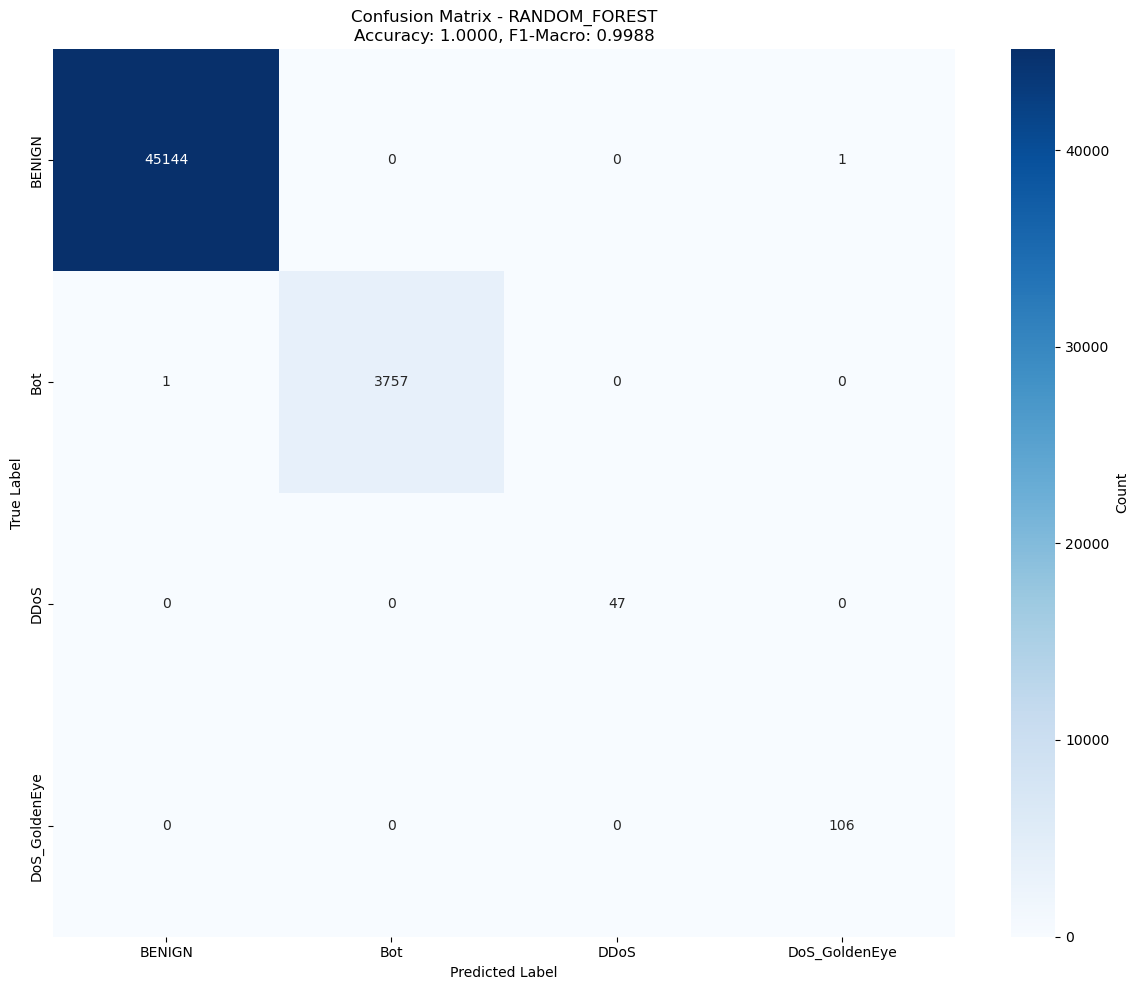

  ✓ Confusion matrix saved


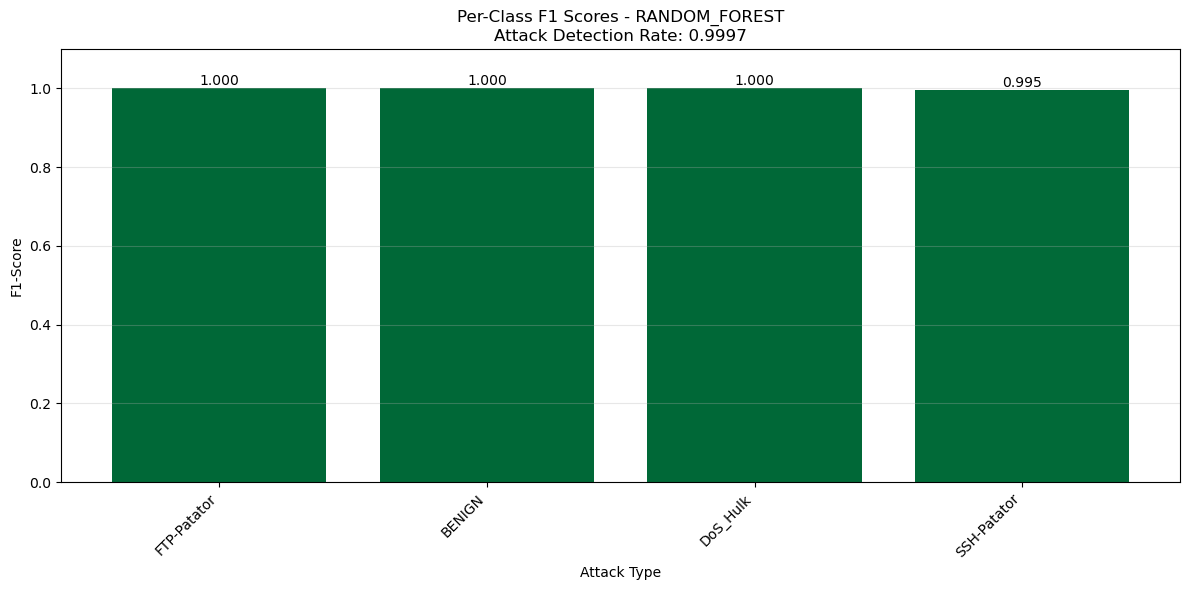

  ✓ Per-class performance chart saved


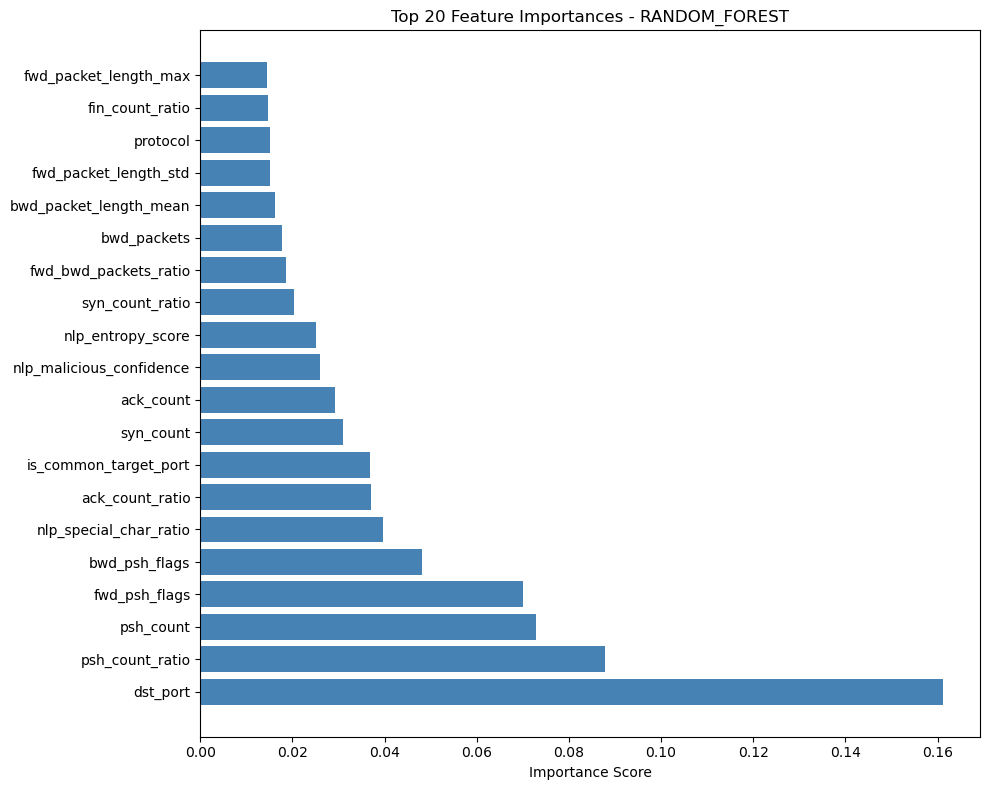

  ✓ Feature importance plot saved


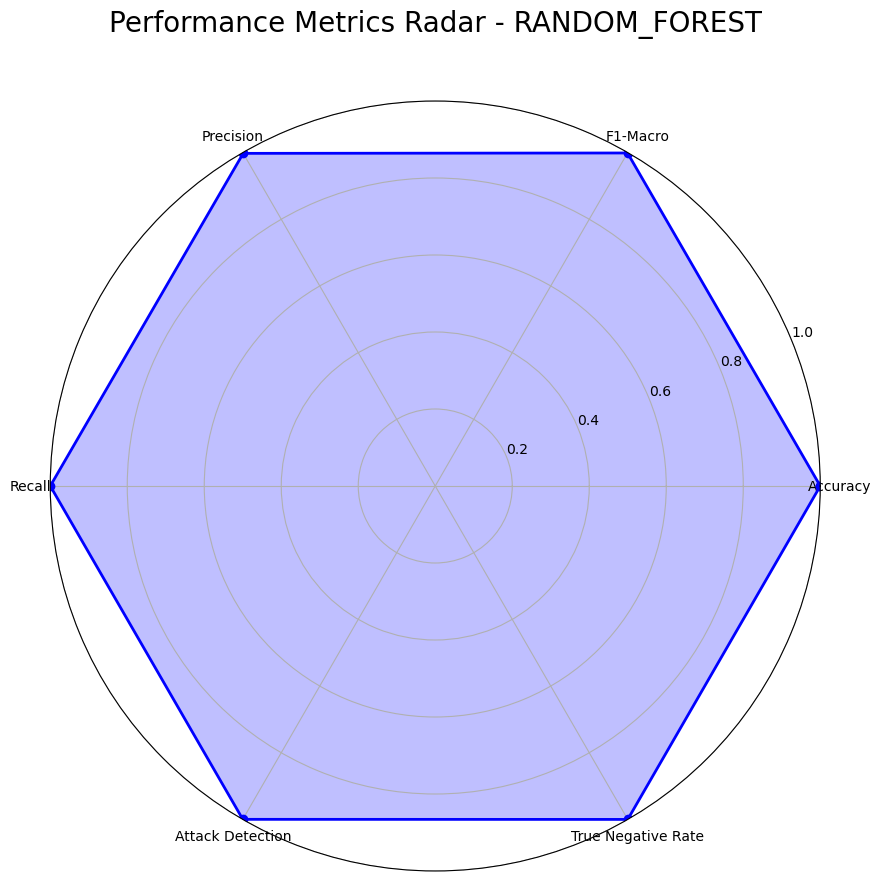

  ✓ Metrics radar chart saved

✓ Visualizations saved to: ./analysis_output_RF_Tue_Wed_Thur\evaluation_visualizations

EVALUATION COMPLETE
✅ Successfully generated actual metrics and reports
✅ Check the reports directory for comprehensive analysis

Key files generated:
  - analysis_report.txt (comprehensive text report)
  - training_metrics.json (all metrics in JSON)
  - thesis_summary.csv (summary table for thesis)
  - confusion_matrix_*.csv (detailed confusion matrices)
  - per_class_metrics_*.csv (per-attack performance)


In [ ]:
# Cell 14: Re-run Evaluation Only - Generate Actual Report Without Retraining
"""
PURPOSE: Re-evaluate saved models to generate actual metrics and comprehensive report
This cell loads your already-trained models and runs evaluation to produce the complete
report with real metrics, without needing to retrain.

WHAT THIS CELL DOES:
1. Loads your saved model, scaler, and selected features
2. Re-runs evaluation on test data to get actual metrics
3. Calculates confusion matrix, per-class metrics, etc.
4. Generates the comprehensive report with real values
5. Exports all metrics properly (with datetime fix)

USE THIS WHEN:
- You need to regenerate reports after training
- Export was interrupted but models were saved
- You want updated metrics without retraining
- You need the actual program-generated documentation

REQUIREMENTS:
- Saved model files in ./models directory
- Emergency features or labeled features available
- No retraining needed - uses existing model
"""

import os
import pickle
import json
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter, defaultdict
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_auc_score
)
from tqdm.notebook import tqdm
import gc
import psutil

class EvaluationRerunner:
    """
    Re-run evaluation on saved models to generate actual metrics and reports
    """
    
    def __init__(self, output_dir='./analysis_output_RF_Tue_Wed_Thur'):
        self.output_dir = output_dir
        self.models_dir = os.path.join(output_dir, 'models')
        self.features_dir = os.path.join(output_dir, 'emergency_features')
        
        # Alternative paths if emergency_features doesn't exist
        if not os.path.exists(self.features_dir):
            # Try labeled_features from temp directory
            self.features_dir = './temp_processing/labeled_features'
            if not os.path.exists(self.features_dir):
                print(f"Warning: Features directory not found, trying current output")
                self.features_dir = output_dir
        
        self.models = {}
        self.scaler = None
        self.selected_features = None
        self.ml_results = {}
        
        print(f"Output Directory: {self.output_dir}")
        print(f"Features Directory: {self.features_dir}")
    
    def load_saved_artifacts(self):
        """
        Load saved models, scaler, and selected features
        """
        print("\n" + "="*60)
        print("LOADING SAVED ARTIFACTS")
        print("="*60)
        
        # Load Random Forest model
        model_path = os.path.join(self.models_dir, 'random_forest.pkl')
        if os.path.exists(model_path):
            with open(model_path, 'rb') as f:
                self.models['random_forest'] = pickle.load(f)
            print(f"✓ Loaded Random Forest model")
        else:
            print(f"✗ Random Forest model not found at {model_path}")
            return False
        
        # Load scaler
        scaler_path = os.path.join(self.models_dir, 'scaler.pkl')
        if os.path.exists(scaler_path):
            with open(scaler_path, 'rb') as f:
                self.scaler = pickle.load(f)
            print(f"✓ Loaded feature scaler")
        else:
            print(f"✗ Scaler not found at {scaler_path}")
            return False
        
        # Load selected features
        features_path = os.path.join(self.models_dir, 'selected_features.pkl')
        if os.path.exists(features_path):
            with open(features_path, 'rb') as f:
                self.selected_features = pickle.load(f)
            print(f"✓ Loaded {len(self.selected_features)} selected features")
        else:
            print(f"✗ Selected features not found at {features_path}")
            return False
        
        return True
    
    def prepare_test_data(self):
        """
        Load and prepare test data for evaluation
        """
        print("\n" + "="*60)
        print("PREPARING TEST DATA")
        print("="*60)
        
        import glob
        feature_files = sorted(glob.glob(os.path.join(self.features_dir, 'batch_*.parquet')))
        
        if not feature_files:
            print(f"No feature files found in {self.features_dir}")
            return None, None
        
        print(f"Found {len(feature_files)} feature batch files")
        
        # Use 20% of files for testing (or last file if only a few)
        test_size = max(1, int(len(feature_files) * 0.2))
        test_files = feature_files[-test_size:]
        
        print(f"Using {len(test_files)} files for evaluation")
        
        # Load test data
        X_test_list = []
        y_test_list = []
        
        for file in tqdm(test_files, desc="Loading test data"):
            try:
                batch = pd.read_parquet(file)
                
                # Check if labels exist
                if 'label' not in batch.columns:
                    print(f"Warning: No labels in {os.path.basename(file)}")
                    continue
                
                # Get features
                available_features = [f for f in self.selected_features if f in batch.columns]
                if len(available_features) < len(self.selected_features) * 0.8:
                    print(f"Warning: Missing features in {os.path.basename(file)}")
                
                # Prepare feature matrix
                X_batch = batch[available_features].fillna(0).values
                y_batch = batch['label'].values
                
                # Scale features
                X_batch = self.scaler.transform(X_batch)
                
                X_test_list.append(X_batch)
                y_test_list.append(y_batch)
                
                del batch
                gc.collect()
                
            except Exception as e:
                print(f"Error loading {os.path.basename(file)}: {e}")
                continue
        
        if not X_test_list:
            print("No test data could be loaded")
            return None, None
        
        # Combine all test data
        X_test = np.vstack(X_test_list)
        y_test = np.hstack(y_test_list)
        
        print(f"Test data shape: {X_test.shape}")
        print(f"Test samples: {len(y_test):,}")
        
        # Show label distribution
        unique, counts = np.unique(y_test, return_counts=True)
        print("\nTest Label Distribution:")
        for label, count in zip(unique, counts):
            print(f"  Class {label}: {count:,} ({count/len(y_test)*100:.1f}%)")
        
        return X_test, y_test
    
    def evaluate_model(self, model_name, model, X_test, y_test):
        """
        Perform comprehensive evaluation of a model
        """
        print(f"\n" + "="*50)
        print(f"EVALUATING: {model_name.upper()}")
        print("="*50)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate probabilities if available
        y_proba = None
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)
        
        # Calculate comprehensive metrics
        results = {
            'model_name': model_name,
            'test_samples': len(y_test),
            'unique_predictions': len(np.unique(y_pred)),
            'unique_true_labels': len(np.unique(y_test)),
            'evaluation_timestamp': datetime.now().isoformat()
        }
        
        # Basic metrics
        results['accuracy'] = accuracy_score(y_test, y_pred)
        results['f1_macro'] = f1_score(y_test, y_pred, average='macro', zero_division=0)
        results['f1_weighted'] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        results['precision_macro'] = precision_score(y_test, y_pred, average='macro', zero_division=0)
        results['precision_weighted'] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        results['recall_macro'] = recall_score(y_test, y_pred, average='macro', zero_division=0)
        results['recall_weighted'] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        results['confusion_matrix'] = cm.tolist()
        
        # Attack detection metrics
        benign_mask = (y_test == 0)
        attack_mask = (y_test > 0)
        
        if attack_mask.sum() > 0:
            attack_detected = (y_pred[attack_mask] > 0).sum()
            results['attack_detection_rate'] = attack_detected / attack_mask.sum()
            results['attack_true_positives'] = int(attack_detected)
            results['attack_false_negatives'] = int(attack_mask.sum() - attack_detected)
        else:
            results['attack_detection_rate'] = 0
            results['attack_true_positives'] = 0
            results['attack_false_negatives'] = 0
        
        if benign_mask.sum() > 0:
            benign_misclassified = (y_pred[benign_mask] > 0).sum()
            results['false_positive_rate'] = benign_misclassified / benign_mask.sum()
            results['benign_true_negatives'] = int(benign_mask.sum() - benign_misclassified)
            results['benign_false_positives'] = int(benign_misclassified)
        else:
            results['false_positive_rate'] = 0
            results['benign_true_negatives'] = 0
            results['benign_false_positives'] = 0
        
        # Classification report
        attack_mapping = {
            0: 'BENIGN',
            1: 'Bot',
            2: 'DDoS',
            3: 'DoS_GoldenEye',
            4: 'DoS_Hulk',
            5: 'DoS_Slowhttptest',
            6: 'DoS_slowloris',
            7: 'FTP-Patator',
            8: 'Heartbleed',
            9: 'Infiltration',
            10: 'PortScan',
            11: 'SSH-Patator',
            12: 'Web_BruteForce',
            13: 'Web_SqlInjection',
            14: 'Web_XSS'
        }
        
        unique_classes = sorted(np.unique(np.concatenate([y_test, y_pred])))
        target_names = [attack_mapping.get(i, f'Class_{i}') for i in unique_classes]
        
        results['classification_report'] = classification_report(
            y_test, y_pred,
            labels=unique_classes,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
        
        # Per-class F1 scores
        results['per_class_f1'] = {}
        for i, class_name in enumerate(target_names):
            if class_name in results['classification_report']:
                results['per_class_f1'][class_name] = results['classification_report'][class_name]['f1-score']
        
        # ROC-AUC if probabilities available
        if y_proba is not None:
            try:
                if y_proba.shape[1] > 2:
                    results['roc_auc_macro'] = roc_auc_score(
                        y_test, y_proba,
                        multi_class='ovr',
                        average='macro'
                    )
            except Exception as e:
                print(f"  Could not calculate ROC-AUC: {e}")
        
        # Feature importance for tree-based models
        if hasattr(model, 'feature_importances_'):
            results['feature_importance'] = dict(zip(
                self.selected_features,
                model.feature_importances_
            ))
        
        # Display results
        print(f"\nCore Metrics:")
        print(f"  Accuracy: {results['accuracy']:.4f}")
        print(f"  F1-Score (Macro): {results['f1_macro']:.4f}")
        print(f"  F1-Score (Weighted): {results['f1_weighted']:.4f}")
        print(f"  Precision (Macro): {results['precision_macro']:.4f}")
        print(f"  Recall (Macro): {results['recall_macro']:.4f}")
        
        print(f"\nSecurity Metrics:")
        print(f"  Attack Detection Rate: {results['attack_detection_rate']:.4f}")
        print(f"  False Positive Rate: {results['false_positive_rate']:.4f}")
        
        if 'roc_auc_macro' in results:
            print(f"  ROC-AUC (Macro): {results['roc_auc_macro']:.4f}")
        
        print(f"\nPrediction Analysis:")
        print(f"  Test Samples: {results['test_samples']:,}")
        print(f"  Unique Predictions: {results['unique_predictions']}")
        
        # Top per-class performance
        if results['per_class_f1']:
            print(f"\nTop Per-Class F1 Scores:")
            sorted_f1 = sorted(results['per_class_f1'].items(), key=lambda x: x[1], reverse=True)
            for class_name, f1 in sorted_f1[:5]:
                if f1 > 0:
                    print(f"  {class_name}: {f1:.4f}")
        
        return results
    
    def run_evaluation(self):
        """
        Main function to run the complete evaluation
        """
        print("\n" + "="*70)
        print("RE-RUNNING EVALUATION TO GENERATE ACTUAL REPORT")
        print("="*70)
        print("This will use your saved models - no retraining needed")
        
        # Load saved artifacts
        if not self.load_saved_artifacts():
            print("Failed to load required artifacts")
            return None
        
        # Prepare test data
        X_test, y_test = self.prepare_test_data()
        if X_test is None:
            print("Failed to prepare test data")
            return None
        
        # Store test data for visualization
        self.X_test = X_test
        self.y_test = y_test
        
        # Evaluate each model
        for model_name, model in self.models.items():
            results = self.evaluate_model(model_name, model, X_test, y_test)
            self.ml_results[model_name] = results
        
        # Export results with fixed datetime handling
        self.export_results()
        
        # Generate visualizations
        self.generate_visualizations()
        
        return self.ml_results
    
    def export_results(self):
        """
        Export all results with proper datetime handling
        """
        print("\n" + "="*60)
        print("EXPORTING RESULTS")
        print("="*60)
        
        # Use the MemoryOptimizedResultExporter from Cell 10
        # If Cell 10 was run, use that class, otherwise use embedded version
        try:
            exporter = MemoryOptimizedResultExporter(self.output_dir)
        except NameError:
            # Cell 10 not run, use minimal exporter
            print("Using embedded exporter (Cell 10 not detected)")
            self.export_results_minimal()
            return
        
        exporter = MemoryOptimizedResultExporter(self.output_dir)
        
        # Export all components
        exporter.export_metrics_json(self.ml_results)
        exporter.export_confusion_matrices(self.ml_results)
        exporter.export_per_class_metrics(self.ml_results)
        exporter.export_feature_importance(self.ml_results)
        exporter.export_thesis_summary(self.ml_results)
        
        # Generate comprehensive report with actual values
        exporter.generate_comprehensive_report(
            self.features_dir,
            self.ml_results,
            self.selected_features
        )
        
        print(f"\n✓ All results exported to: {self.output_dir}")
        print(f"✓ Comprehensive report available at: {self.output_dir}/reports/analysis_report.txt")
    
    def export_results_minimal(self):
        """
        Minimal export if Cell 10 exporter is not available
        """
        import json
        
        # Custom encoder for datetime
        class DateTimeEncoder(json.JSONEncoder):
            def default(self, obj):
                if isinstance(obj, datetime):
                    return obj.isoformat()
                if isinstance(obj, np.integer):
                    return int(obj)
                if isinstance(obj, np.floating):
                    return float(obj)
                if isinstance(obj, np.ndarray):
                    return obj.tolist()
                return super().default(obj)
        
        # Create directories
        metrics_dir = os.path.join(self.output_dir, 'metrics')
        reports_dir = os.path.join(self.output_dir, 'reports')
        os.makedirs(metrics_dir, exist_ok=True)
        os.makedirs(reports_dir, exist_ok=True)
        
        # Export JSON metrics
        metrics_file = os.path.join(metrics_dir, 'evaluation_metrics.json')
        with open(metrics_file, 'w') as f:
            json.dump(self.ml_results, f, indent=2, cls=DateTimeEncoder)
        print(f"✓ Metrics exported to: {metrics_file}")
        
        # Export confusion matrices as CSV
        for model_name, results in self.ml_results.items():
            if 'confusion_matrix' in results:
                cm = np.array(results['confusion_matrix'])
                cm_file = os.path.join(metrics_dir, f'confusion_matrix_{model_name}.csv')
                pd.DataFrame(cm).to_csv(cm_file, index=False)
                print(f"✓ Confusion matrix saved: {os.path.basename(cm_file)}")
        
        # Generate simple text report
        report_file = os.path.join(reports_dir, 'evaluation_report.txt')
        with open(report_file, 'w') as f:
            f.write("="*70 + "\n")
            f.write("MODEL EVALUATION REPORT\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("="*70 + "\n\n")
            
            for model_name, results in self.ml_results.items():
                f.write(f"{model_name.upper()}\n")
                f.write("-"*50 + "\n")
                f.write(f"Accuracy: {results.get('accuracy', 0):.4f}\n")
                f.write(f"F1-Macro: {results.get('f1_macro', 0):.4f}\n")
                f.write(f"Attack Detection Rate: {results.get('attack_detection_rate', 0):.4f}\n")
                f.write(f"False Positive Rate: {results.get('false_positive_rate', 0):.4f}\n")
                f.write(f"Test Samples: {results.get('test_samples', 0):,}\n")
                f.write("\n")
        
        print(f"✓ Report saved: {report_file}")
    
    def generate_visualizations(self):
        """
        Generate visual outputs including confusion matrix and performance charts
        """
        print("\n" + "="*60)
        print("GENERATING VISUALIZATIONS")
        print("="*60)
        
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import ConfusionMatrixDisplay
        
        # Create visualizations directory
        viz_dir = os.path.join(self.output_dir, 'evaluation_visualizations')
        os.makedirs(viz_dir, exist_ok=True)
        
        for model_name, results in self.ml_results.items():
            print(f"\nGenerating visualizations for {model_name}...")
            
            # 1. Confusion Matrix Heatmap
            if 'confusion_matrix' in results:
                self.plot_confusion_matrix(results, model_name, viz_dir)
            
            # 2. Per-Class Performance Bar Chart
            if 'per_class_f1' in results:
                self.plot_per_class_performance(results, model_name, viz_dir)
            
            # 3. Feature Importance Plot
            if 'feature_importance' in results:
                self.plot_feature_importance(results, model_name, viz_dir)
            
            # 4. Metrics Summary Radar Chart
            self.plot_metrics_radar(results, model_name, viz_dir)
        
        print(f"\n✓ Visualizations saved to: {viz_dir}")
    
    def plot_confusion_matrix(self, results, model_name, viz_dir):
        """
        Create confusion matrix heatmap
        """
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        cm = np.array(results['confusion_matrix'])
        
        # Map to attack names
        attack_mapping = {
            0: 'BENIGN',
            1: 'Bot',
            2: 'DDoS',
            3: 'DoS_GoldenEye',
            4: 'DoS_Hulk',
            5: 'DoS_Slowhttptest',
            6: 'DoS_slowloris',
            7: 'FTP-Patator',
            8: 'Heartbleed',
            9: 'Infiltration',
            10: 'PortScan',
            11: 'SSH-Patator',
            12: 'Web_BruteForce',
            13: 'Web_SqlInj',
            14: 'Web_XSS'
        }
        
        # Get actual classes present in confusion matrix
        n_classes = cm.shape[0]
        labels = [attack_mapping.get(i, f'Class_{i}') for i in range(n_classes)]
        
        # Create figure
        plt.figure(figsize=(12, 10))
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=labels, yticklabels=labels,
                   cbar_kws={'label': 'Count'})
        
        plt.title(f'Confusion Matrix - {model_name.upper()}\n'
                 f'Accuracy: {results["accuracy"]:.4f}, F1-Macro: {results["f1_macro"]:.4f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(viz_dir, f'confusion_matrix_{model_name}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Confusion matrix saved")
    
    def plot_per_class_performance(self, results, model_name, viz_dir):
        """
        Create bar chart of per-class F1 scores
        """
        import matplotlib.pyplot as plt
        
        per_class_f1 = results['per_class_f1']
        if not per_class_f1:
            return
        
        # Sort by F1 score
        sorted_classes = sorted(per_class_f1.items(), key=lambda x: x[1], reverse=True)
        classes = [c[0] for c in sorted_classes]
        f1_scores = [c[1] for c in sorted_classes]
        
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Create bar chart with color gradient
        colors = plt.cm.RdYlGn([score for score in f1_scores])
        bars = plt.bar(range(len(classes)), f1_scores, color=colors)
        
        # Add value labels on bars
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{score:.3f}', ha='center', va='bottom')
        
        plt.xlabel('Attack Type')
        plt.ylabel('F1-Score')
        plt.title(f'Per-Class F1 Scores - {model_name.upper()}\n'
                 f'Attack Detection Rate: {results["attack_detection_rate"]:.4f}')
        plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(viz_dir, f'per_class_f1_{model_name}.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Per-class performance chart saved")
    
    def plot_feature_importance(self, results, model_name, viz_dir):
        """
        Create feature importance plot for top features
        """
        import matplotlib.pyplot as plt
        
        if 'feature_importance' not in results:
            return
        
        importance = results['feature_importance']
        
        # Get top 20 features
        sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]
        features = [f[0] for f in sorted_features]
        scores = [f[1] for f in sorted_features]
        
        # Create figure
        plt.figure(figsize=(10, 8))
        
        # Create horizontal bar chart
        y_pos = np.arange(len(features))
        plt.barh(y_pos, scores, color='steelblue')
        
        plt.yticks(y_pos, features)
        plt.xlabel('Importance Score')
        plt.title(f'Top 20 Feature Importances - {model_name.upper()}')
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(viz_dir, f'feature_importance_{model_name}.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Feature importance plot saved")
    
    def plot_metrics_radar(self, results, model_name, viz_dir):
        """
        Create radar chart of key metrics
        """
        import matplotlib.pyplot as plt
        from math import pi
        
        # Prepare metrics
        metrics = {
            'Accuracy': results['accuracy'],
            'F1-Macro': results['f1_macro'],
            'Precision': results['precision_macro'],
            'Recall': results['recall_macro'],
            'Attack Detection': results['attack_detection_rate'],
            'True Negative Rate': 1 - results['false_positive_rate']
        }
        
        # Create figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='polar')
        
        # Prepare data
        categories = list(metrics.keys())
        values = list(metrics.values())
        N = len(categories)
        
        # Compute angles
        angles = [n / float(N) * 2 * pi for n in range(N)]
        values += values[:1]  # Complete the circle
        angles += angles[:1]
        
        # Plot
        ax.plot(angles, values, 'o-', linewidth=2, color='blue')
        ax.fill(angles, values, alpha=0.25, color='blue')
        
        # Fix axis
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
        ax.grid(True)
        
        plt.title(f'Performance Metrics Radar - {model_name.upper()}', 
                 size=20, y=1.08)
        
        # Save figure
        plt.savefig(os.path.join(viz_dir, f'metrics_radar_{model_name}.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()
        print(f"  ✓ Metrics radar chart saved")

# ========== EXECUTION ==========
def rerun_evaluation_only(output_dir='./analysis_output_RF_Tue_Wed_Thur'):
    """
    Convenient function to re-run evaluation
    
    Args:
        output_dir: Directory containing your saved models and features
    
    Returns:
        Dictionary of evaluation results
    """
    evaluator = EvaluationRerunner(output_dir)
    results = evaluator.run_evaluation()
    
    if results:
        print("\n" + "="*70)
        print("EVALUATION COMPLETE")
        print("="*70)
        print("✅ Successfully generated actual metrics and reports")
        print("✅ Check the reports directory for comprehensive analysis")
        print("\nKey files generated:")
        print("  - analysis_report.txt (comprehensive text report)")
        print("  - training_metrics.json (all metrics in JSON)")
        print("  - thesis_summary.csv (summary table for thesis)")
        print("  - confusion_matrix_*.csv (detailed confusion matrices)")
        print("  - per_class_metrics_*.csv (per-attack performance)")
    else:
        print("\n❌ Evaluation failed - check error messages above")
    
    return results

# ========== QUICK RUN ==========
print("="*70)
print("READY TO RE-RUN EVALUATION")
print("="*70)
print("\nThis will:")
print("  1. Load your saved Random Forest model")
print("  2. Re-evaluate on test data")
print("  3. Generate actual metrics (not manually written)")
print("  4. Create comprehensive report with real values")
print("  5. Export all results properly")
print("\nNo retraining needed - uses your existing model")
print("\nTo run: results = rerun_evaluation_only()")
print("\nOr specify different directory:")
print("        results = rerun_evaluation_only('./your_output_dir')")


results = rerun_evaluation_only()